# LSTM, SIR, and NARX Models

### Goals

Attempt to run and optimize an LSTM model, starting with a single location (Hubei Province) to all of China and eventually all locations with confirmed coronavirus cases.

Also attempt to leverage SIR models if LSTM appears unworkable.

### Challenges
1. LSTM needs TONS of training data. Each of ~104 locations has ~80 time steps (days). This sparse matrix is challenging to train on.
  1. Data may need to be imputed using an epidemiological curve. 
    1. See SIR model which can be developed for each location provided population and Ro constants. This model can be adapted to intake an origin-destination flow matrix as well.
    2. Perhaps every location's first "time step" should be considered as "Day 1" regardless of actual date?
2. Spatial temporal aspect is tricky - training one model on multiple location-dependent characteristics to predict values in the time series. 


In [460]:
import pandas as pd
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D

warnings.filterwarnings(action = 'ignore')
sns.set_style('whitegrid')
sns.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Prep

104 of 105 reported locations to which coronavirus has spread are within 500 km of an airport.

In [488]:
df = pd.read_csv('time_series_cases.csv', index_col=0)
df['date'] = pd.to_datetime(df['date']) # datetime format not read in
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13640 entries, 0 to 13639
Data columns (total 16 columns):
Lat                   13640 non-null float64
Long                  13640 non-null float64
Province/State        13640 non-null object
country               13640 non-null object
hospital beds         13640 non-null float64
physicians            13640 non-null float64
GDP_per_capita        13640 non-null float64
SPAR_index            13640 non-null float64
IVDI_score            13640 non-null float64
city_pop              13640 non-null float64
effective_dist        13640 non-null float64
geo_dist              13640 non-null float64
ann_pass_flux         13640 non-null float64
connected_airports    13640 non-null float64
date                  13640 non-null datetime64[ns]
confirmed_cases       13640 non-null float64
dtypes: datetime64[ns](1), float64(13), object(2)
memory usage: 1.8+ MB


Next:

1. Sort the entire dataset by three location variables (a unique combination) to observe confirmed time series.

2. Create location ids in lieu of the unique 3-column combination. This allows us to iterate through the dataset more easily as needed.

In [489]:
df = df.sort_values(by = ['Province/State', 
                          #'city_county_state', 
                          'country', 
                          'date']).reset_index(drop = True)

In [491]:
# df['loc_id'] = df[['Lat', 'Long']].apply(lambda x: list(zip(x[0], x[1])), axis=1)

# a = df.groupby(['Province/State','country']) \
#        .transform(lambda x: pd.factorize(x)[0])
# df['loc_id'] = a

a = df.groupby(['Province/State'])['country'] \
       .transform(lambda x: pd.factorize(x)[0]).astype(str)
df['loc_id'] = df['Province/State'].add(a)

In [492]:
df.head()

Lat     Long Province/State country  hospital beds  physicians  GDP_per_capita  SPAR_index  IVDI_score     city_pop  effective_dist      geo_dist  ann_pass_flux  connected_airports       date  confirmed_cases          loc_id
0  45.5017 -73.5673   Montreal, QC  Canada            2.7      2.6102    48130.255973   99.461538    0.889388  1995.696833       13.935703  11728.445145   3.350359e+06           31.884615 2019-12-08              0.0   Montreal, QC0
1  45.5017 -73.5673   Montreal, QC  Canada            2.7      2.6102    48130.255973   99.461538    0.889388  1995.696833       13.935703  11728.445145   3.350359e+06           31.884615 2019-12-09              0.0   Montreal, QC0
2  45.5017 -73.5673   Montreal, QC  Canada            2.7      2.6102    48130.255973   99.461538    0.889388  1995.696833       13.935703  11728.445145   3.350359e+06           31.884615 2019-12-10              0.0   Montreal, QC0
3  45.5017 -73.5673   Montreal, QC  Canada            2.7      2.6102    48130.255973   99.461538    0.889388  1995.696833       13.935703  11728.445145   3.350359e+06           31.884615 2019-12-11              0.0   Montreal, QC0
4  45.5017 -73.5673   Montreal, QC  Canada            2.7      2.6102    48130.255973   99.461538    0.889388  1995.696833       13.935703  11728.445145   3.350359e+06           31.884615 2019-12-12              0.0   Montreal, QC0

In [493]:
len(df.loc_id.unique())

155

In [463]:
# df['loc_id'] = list_loc
# df['loc_id'] = pd.factorize(df['loc_id'])[0]

# df.head()

# print("Number of Unique Locations: ", len(df.loc_id.unique()))
# print("Number of Countries: ", len(df.country.unique()))

In [494]:
df.describe().T # only numeric variables. min/max scale prior to training.

count          mean           std            min           25%           50%           75%           max
Lat                 13640.0  3.148033e+01  2.093218e+01     -41.454500  2.681540e+01  3.600000e+01  4.300000e+01  6.400000e+01
Long                13640.0  2.308230e+01  8.897913e+01    -123.869500 -7.141280e+01  2.501360e+01  1.097453e+02  1.748860e+02
hospital beds       13640.0  3.655078e+00  2.147893e+00       0.300000  2.700000e+00  2.900000e+00  4.200000e+00  1.380000e+01
physicians          13640.0  2.463388e+00  1.134634e+00       0.000800  1.785500e+00  2.594800e+00  3.007500e+00  6.561700e+00
GDP_per_capita      13640.0  3.838749e+04  2.475390e+04    1955.006208  1.823661e+04  3.443840e+04  6.279459e+04  1.268984e+05
SPAR_index          13640.0  8.222393e+01  1.607716e+01      23.076923  7.407692e+01  9.100000e+01  9.430769e+01  1.000000e+02
IVDI_score          13640.0  7.191899e-01  1.259614e-01       0.257002  6.762941e-01  7.298371e-01  8.197449e-01  8.893884e-01
city_pop            13640.0  1.539136e+03  1.056978e+03     393.604000  1.080220e+03  1.372797e+03  1.689387e+03  7.594105e+03
effective_dist      13640.0  1.150150e+01  3.198013e+00       5.199450  1.081006e+01  1.286664e+01  1.356018e+01  1.757655e+01
geo_dist            13640.0  7.060268e+03  4.448005e+03     341.482235  2.287499e+03  7.795021e+03  1.045108e+04  1.918502e+04
ann_pass_flux       13640.0  4.243952e+06  2.486760e+06  299523.000000  2.268930e+06  3.822455e+06  6.028910e+06  1.149651e+07
connected_airports  13640.0  3.590040e+01  1.738382e+01       3.000000  2.208333e+01  3.306250e+01  4.819444e+01  8.522727e+01
confirmed_cases     13640.0  1.523243e+02  2.568398e+03       0.000000  0.000000e+00  0.000000e+00  0.000000e+00  6.733200e+04

### Missing data
There are some zero case values representing null information between observed cases for a given location. The goal below is to impute value of previous non-zero case count until a new observation of non-zero value.

In [495]:
df.confirmed_cases.value_counts()

0.0        10271
1.0          793
2.0          325
3.0          133
4.0          125
           ...  
62031.0        1
2036.0         1
626.0          1
59989.0        1
1294.0         1
Name: confirmed_cases, Length: 580, dtype: int64

In [496]:
df.confirmed_cases.max()

67332.0

In [5]:
'''code below does not work, need to find a better way'''

# import progressbar

# bar = progressbar.ProgressBar(maxval=len(df.loc_id.unique())).start()

# for location in df.loc_id.unique():
#     for index, case_count in enumerate(df.loc[df['loc_id'] == location].confirmed_cases):
#         while index != 0:
#             if (df.loc[df['loc_id'] == location].confirmed_cases[index] == 0) & (df.loc[df['loc_id'] == location].confirmed_cases[index-1] != 0):
#                 df.loc[df['loc_id'] == location].confirmed_cases[index] = df.confirmed_cases[index-1]
#     bar.update(location)

'code below does not work, need to find a better way'

### Time lag functions

Allowing the model to intake a given number of values and predict the next value.
For example, case counts = [100 200 300] --> prediction for next count = 400.

The first two functions are for univariate models and the last for multivariate.

In [469]:
# function from class for univariate time series.

def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[0:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [556]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [471]:
#  https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:, -1:]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [472]:
# split a univariate sequence into samples and return predictions for multistep output
def split_sequence_multistep(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [473]:
# split a multivariate sequence into samples for multistep output
def split_sequences_multistep(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Timestamps and LSTM

Replace the timestamp with the number of days since Dec 8th to correct an LSTM fit error. The function below is not necessary for LSTM models using time lag implementation (even lag =1).

In [474]:
def date_to_string(df):
    dic = {}
    for index, date in enumerate(df.date.unique()):
        x = {date : index}
        dic.update(x)

    df.date = df.date.map(dic)
    return df

### Cases by location

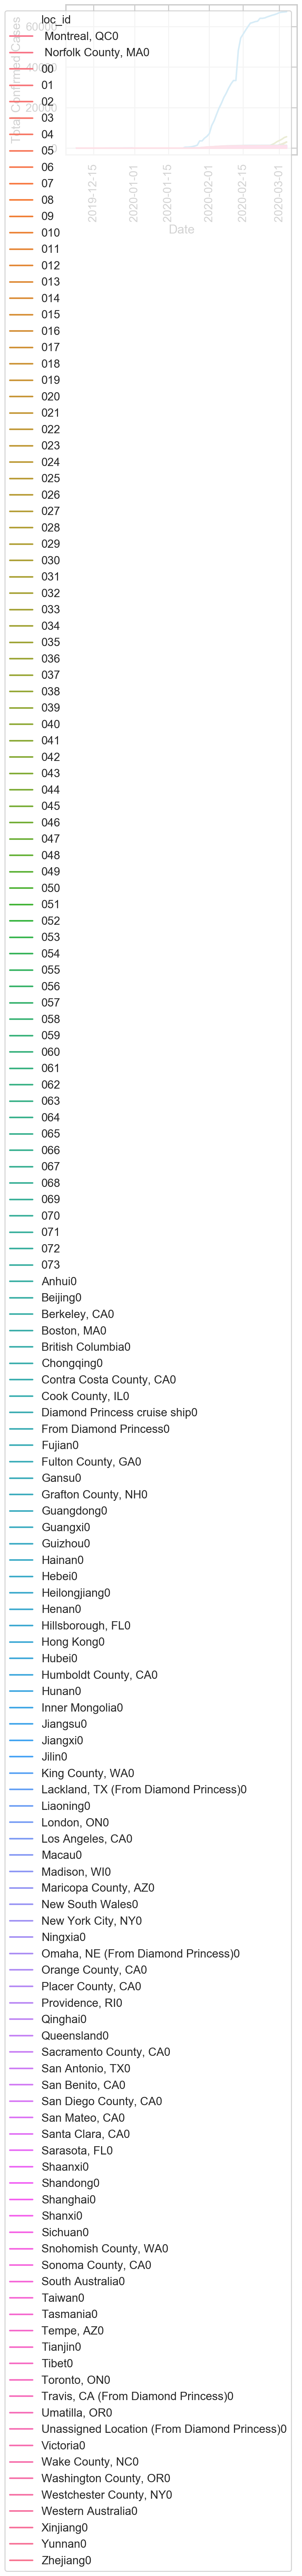

In [498]:
sns.lineplot(y = 'confirmed_cases', x = 'date', hue = 'loc_id', data = df, ci = None)
plt.ylabel('Total Confirmed Cases')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.legend(loc = 'best')
plt.show()

### Cases by country

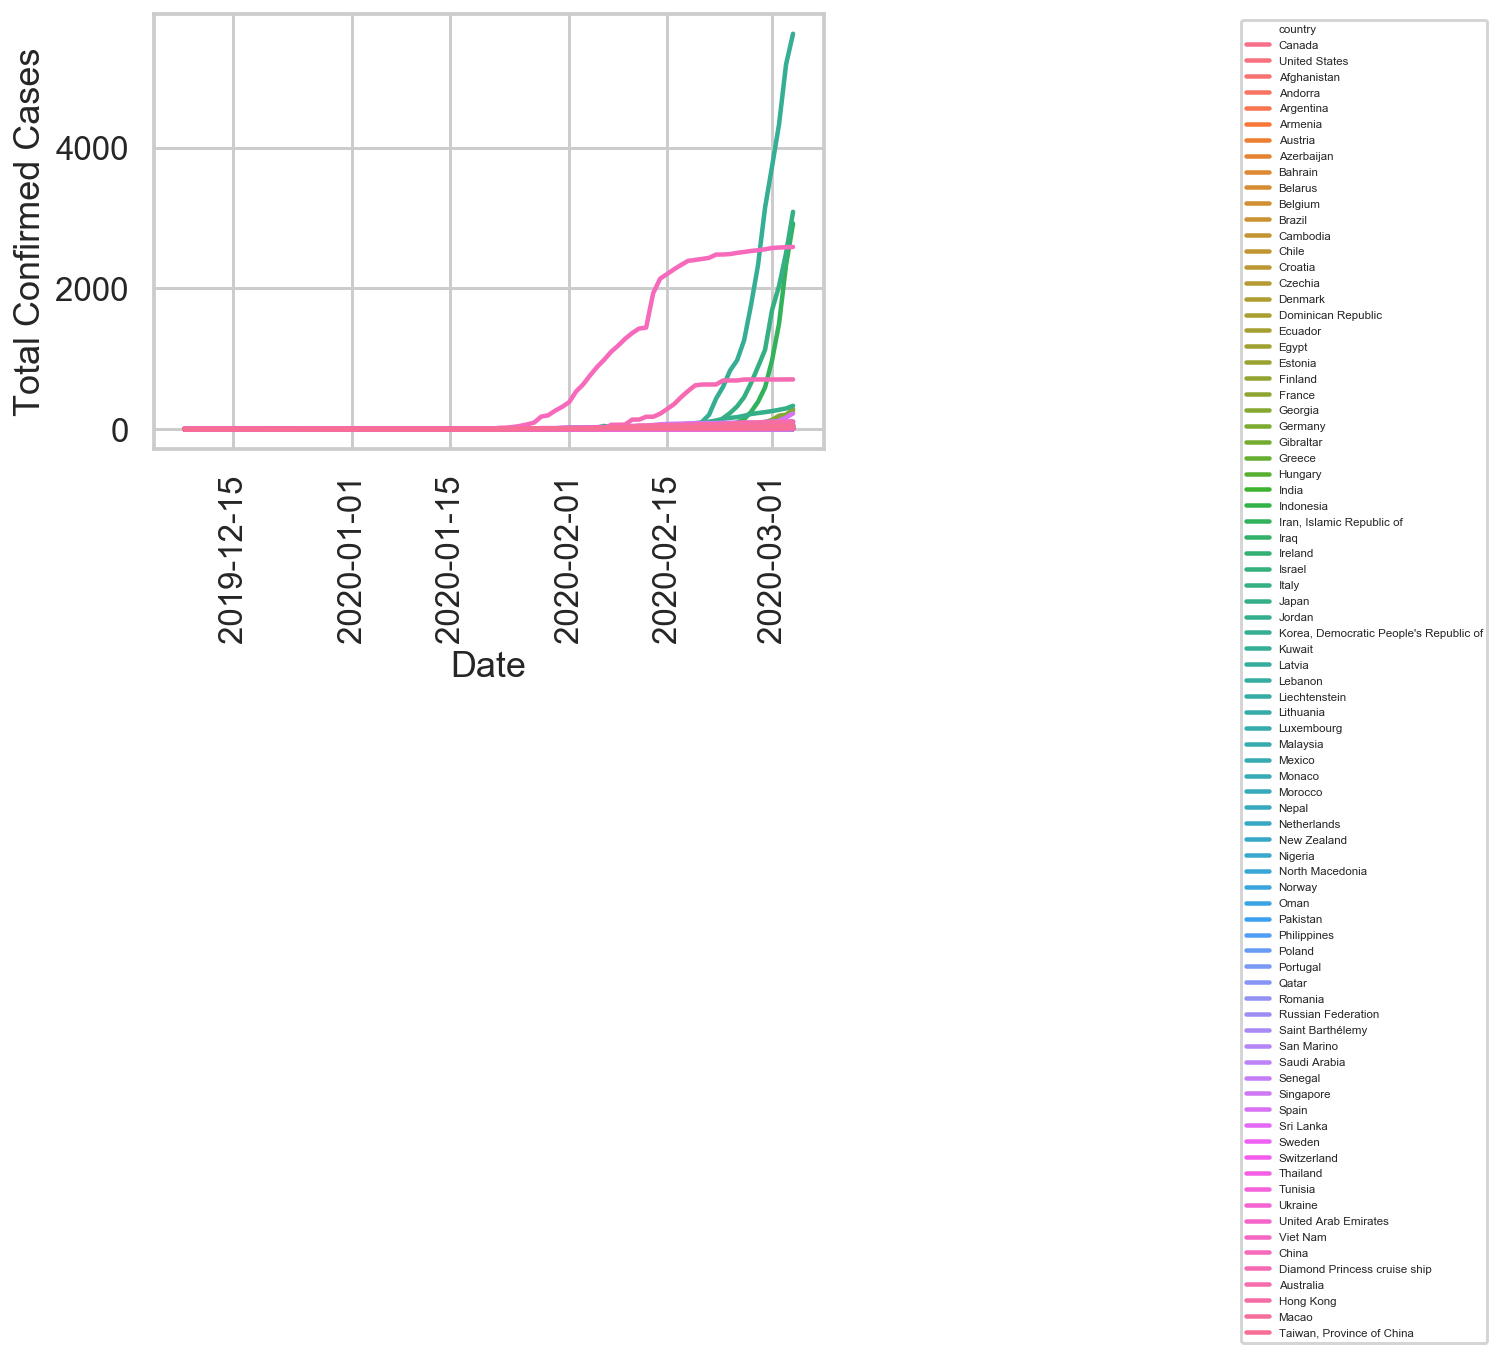

In [499]:
sns.lineplot(y = 'confirmed_cases', x = 'date', hue = 'country', data = df, ci = None,
            palette = sns.color_palette('husl', len(df.country.unique())))
plt.ylabel('Total Confirmed Cases')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor = (1, 0., 1, 1), fontsize = 'xx-small')
plt.show()

In [515]:
china_total_cases = df[df['country'] == 'China'].groupby(['date']).sum().reset_index()
world_m_china_tot_cases = df[df['country'] != 'China'].groupby(['date']).sum().reset_index()
world_m_china_tot_cases.head()

date          Lat       Long  hospital beds  physicians  GDP_per_capita   SPAR_index  IVDI_score       city_pop  effective_dist      geo_dist  ann_pass_flux  connected_airports  confirmed_cases
0 2019-12-08  3838.811769  93.197569     436.337042    326.4747    5.384726e+06  9821.170846   90.509318  196547.796081     1599.042241  1.061437e+06   5.202560e+08         4533.168823              0.0
1 2019-12-09  3838.811769  93.197569     436.337042    326.4747    5.384726e+06  9821.170846   90.509318  196547.796081     1599.042241  1.061437e+06   5.202560e+08         4533.168823              0.0
2 2019-12-10  3838.811769  93.197569     436.337042    326.4747    5.384726e+06  9821.170846   90.509318  196547.796081     1599.042241  1.061437e+06   5.202560e+08         4533.168823              0.0
3 2019-12-11  3838.811769  93.197569     436.337042    326.4747    5.384726e+06  9821.170846   90.509318  196547.796081     1599.042241  1.061437e+06   5.202560e+08         4533.168823              0.0
4 2019-12-12  3838.811769  93.197569     436.337042    326.4747    5.384726e+06  9821.170846   90.509318  196547.796081     1599.042241  1.061437e+06   5.202560e+08         4533.168823              0.0

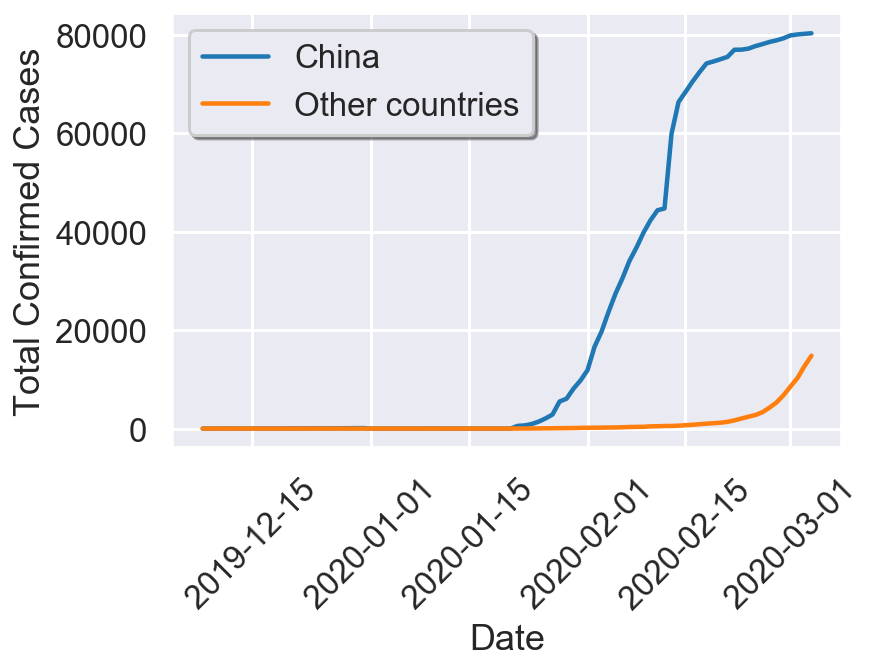

In [525]:
# Plot China v rest of world and travel ban dates as vline
sns.set_context('talk')
sns.set_style('darkgrid')
sns.lineplot(y = 'confirmed_cases', x = 'date', data = china_total_cases , ci = None, label = 'China')
sns.lineplot(y = 'confirmed_cases', x = 'date', data = world_m_china_tot_cases, ci = None, label = 'Other countries')
plt.ylabel('Total Confirmed Cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc = 2, fancybox = True, frameon = True, shadow=True)
plt.show()

## Hubei Province

Hubei Province, China, for which most time series data is available.

In [500]:
hubei_df = df.loc[df['Province/State'] == 'Hubei'].reset_index(drop=True)
hubei_df.head()

Lat   Long Province/State country  hospital beds  physicians  GDP_per_capita  SPAR_index  IVDI_score     city_pop  effective_dist    geo_dist  ann_pass_flux  connected_airports       date  confirmed_cases  loc_id
0  36.0  139.0          Hubei   China            4.2      1.7855    18236.612982   94.307692    0.676294  1154.866872        6.111029  341.482235   2.842581e+06           29.033333 2019-12-08              1.0  Hubei0
1  36.0  139.0          Hubei   China            4.2      1.7855    18236.612982   94.307692    0.676294  1154.866872        6.111029  341.482235   2.842581e+06           29.033333 2019-12-09              0.0  Hubei0
2  36.0  139.0          Hubei   China            4.2      1.7855    18236.612982   94.307692    0.676294  1154.866872        6.111029  341.482235   2.842581e+06           29.033333 2019-12-10              0.0  Hubei0
3  36.0  139.0          Hubei   China            4.2      1.7855    18236.612982   94.307692    0.676294  1154.866872        6.111029  341.482235   2.842581e+06           29.033333 2019-12-11              2.0  Hubei0
4  36.0  139.0          Hubei   China            4.2      1.7855    18236.612982   94.307692    0.676294  1154.866872        6.111029  341.482235   2.842581e+06           29.033333 2019-12-12              5.0  Hubei0

In [557]:
sequence = hubei_df.confirmed_cases
n_steps = 3

X, y = split_sequence(sequence, n_steps)
X.shape

(85, 3)

In [562]:
china_df.loc_id.unique().tolist()

['Anhui0',
 'Beijing0',
 'Chongqing0',
 'Fujian0',
 'Gansu0',
 'Guangdong0',
 'Guangxi0',
 'Guizhou0',
 'Hainan0',
 'Hebei0',
 'Heilongjiang0',
 'Henan0',
 'Hubei0',
 'Hunan0',
 'Inner Mongolia0',
 'Jiangsu0',
 'Jiangxi0',
 'Jilin0',
 'Liaoning0',
 'Ningxia0',
 'Qinghai0',
 'Shaanxi0',
 'Shandong0',
 'Shanghai0',
 'Shanxi0',
 'Sichuan0',
 'Tianjin0',
 'Tibet0',
 'Xinjiang0',
 'Yunnan0',
 'Zhejiang0']

In [579]:
train_size = 0.9
n_steps = 3
n_features = 1 # univariate

seq = hubei_df.confirmed_cases
X, y = split_sequence(seq, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [583]:
X[-1:]

array([[[66907.],
        [67103.],
        [67217.]]])

In [578]:
trainX = X[:-1]
trainy = y[:-3]
testX = X[-3:]
testy = y[-3:]

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.fit(trainX, trainy, epochs=200, verbose=1, validation_split = 0.2, 
          batch_size = 10, shuffle=False)

yhat = model.predict(testX, verbose=1)
y_train_pred = model.predict(trainX, verbose = 1)

score = model.evaluate(testX, testy, batch_size=10)

print(prov, yhat, score)

Train on 65 samples, validate on 17 samples
Epoch 1/200


KeyboardInterrupt: 

In [563]:
china_locs = china_df.loc_id.unique().tolist()
len(china_locs)

31

In [566]:
china_locs

['Anhui0',
 'Beijing0',
 'Chongqing0',
 'Fujian0',
 'Gansu0',
 'Guangdong0',
 'Guangxi0',
 'Guizhou0',
 'Hainan0',
 'Hebei0',
 'Heilongjiang0',
 'Henan0',
 'Hubei0',
 'Hunan0',
 'Inner Mongolia0',
 'Jiangsu0',
 'Jiangxi0',
 'Jilin0',
 'Liaoning0',
 'Ningxia0',
 'Qinghai0',
 'Shaanxi0',
 'Shandong0',
 'Shanghai0',
 'Shanxi0',
 'Sichuan0',
 'Tianjin0',
 'Tibet0',
 'Xinjiang0',
 'Yunnan0',
 'Zhejiang0']

In [574]:
# creating dfs for all provinces
china_df = df[df['country'] == 'China']

prov_list = []
yhat_arrays_list = []
score_list = []

for prov in china_locs:
    
    prov_df = china_df.loc[china_df.loc_id == prov].reset_index()

    train_size = 0.9
    n_steps = 3
    n_features = 1 # univariate
    
    seq = prov_df.confirmed_cases
    X, y = split_sequence(seq, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    trainX = X[:int(train_size*len(X))]
    trainy = y[:int(train_size*len(y))]
    testX = X[int(train_size*len(X)):]
    testy = y[int(train_size*len(y)):]
    
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    model.fit(trainX, trainy, epochs=200, validation_split = 0.2, 
              batch_size = 10, shuffle=False)
    
    yhat = model.predict(testX, verbose=1)
    y_train_pred = model.predict(trainX, verbose = 1)
    
    score = model.evaluate(testX, testy, batch_size=10)
    
    prov_list.append(prov)
    yhat_arrays_list.append(yhat)
    score_list.append(score)

Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 8s 138ms/step - loss: 34194.1601 - acc: 0.6833 - val_loss: 654539.2734 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 1ms/step - loss: 30154.4386 - acc: 0.6833 - val_loss: 564503.1406 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 1ms/step - loss: 28171.5998 - acc: 0.6833 - val_loss: 526541.8555 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 845us/step - loss: 26535.6285 - acc: 0.6833 - val_loss: 477670.4453 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 967us/step - loss: 24546.4571 - acc: 0.6833 - val_loss: 415078.3438 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 1ms/step - loss: 22386.6847 - acc: 0.6833 - val_loss: 368539.9648 - val_acc: 0.0000e+00
Epoch 7/200
60/60 [==============================] - 0s 1ms/step - loss: 20522.7254 - 

60/60 [==============================] - 0s 1ms/step - loss: 64.3649 - acc: 0.6333 - val_loss: 28606.4531 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 0s 1ms/step - loss: 73.9233 - acc: 0.6333 - val_loss: 8648.2611 - val_acc: 0.0000e+00
Epoch 60/200
60/60 [==============================] - 0s 1ms/step - loss: 162.1682 - acc: 0.6500 - val_loss: 36401.9131 - val_acc: 0.0000e+00
Epoch 61/200
60/60 [==============================] - 0s 1ms/step - loss: 123.2252 - acc: 0.6500 - val_loss: 384.7142 - val_acc: 0.0000e+00
Epoch 62/200
60/60 [==============================] - 0s 1ms/step - loss: 170.1027 - acc: 0.6500 - val_loss: 22708.9641 - val_acc: 0.0000e+00
Epoch 63/200
60/60 [==============================] - 0s 1ms/step - loss: 81.1100 - acc: 0.6500 - val_loss: 13679.8810 - val_acc: 0.0000e+00
Epoch 64/200
60/60 [==============================] - 0s 1ms/step - loss: 81.0305 - acc: 0.6833 - val_loss: 50854.8599 - val_acc: 0.0000e+00
Epoch 65/200
60/60 [======

Epoch 116/200
60/60 [==============================] - 0s 1ms/step - loss: 36.6133 - acc: 0.7167 - val_loss: 3248.5871 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 0s 1ms/step - loss: 143.5944 - acc: 0.6833 - val_loss: 34049.7815 - val_acc: 0.0000e+00
Epoch 118/200
60/60 [==============================] - 0s 1ms/step - loss: 159.6666 - acc: 0.6500 - val_loss: 3136.9597 - val_acc: 0.0000e+00
Epoch 119/200
60/60 [==============================] - 0s 1ms/step - loss: 211.7434 - acc: 0.6667 - val_loss: 28813.7744 - val_acc: 0.0000e+00
Epoch 120/200
60/60 [==============================] - 0s 1ms/step - loss: 54.8966 - acc: 0.6500 - val_loss: 11717.8524 - val_acc: 0.0000e+00
Epoch 121/200
60/60 [==============================] - 0s 1ms/step - loss: 32.8884 - acc: 0.7000 - val_loss: 18590.5724 - val_acc: 0.0000e+00
Epoch 122/200
60/60 [==============================] - 0s 997us/step - loss: 34.4532 - acc: 0.7167 - val_loss: 7648.8524 - val_acc: 0.0000e+00
Epoc

60/60 [==============================] - 0s 1ms/step - loss: 187.9323 - acc: 0.6833 - val_loss: 44566.5571 - val_acc: 0.0000e+00
Epoch 174/200
60/60 [==============================] - 0s 1ms/step - loss: 43.5920 - acc: 0.6500 - val_loss: 11132.4243 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 1ms/step - loss: 34.0708 - acc: 0.6833 - val_loss: 40654.9604 - val_acc: 0.0000e+00
Epoch 176/200
60/60 [==============================] - 0s 1ms/step - loss: 55.6496 - acc: 0.6500 - val_loss: 36881.0193 - val_acc: 0.0000e+00
Epoch 177/200
60/60 [==============================] - 0s 1ms/step - loss: 84.4304 - acc: 0.7500 - val_loss: 2357.3350 - val_acc: 0.0000e+00
Epoch 178/200
60/60 [==============================] - 0s 1ms/step - loss: 205.8396 - acc: 0.6667 - val_loss: 76838.2695 - val_acc: 0.0000e+00
Epoch 179/200
60/60 [==============================] - 0s 1ms/step - loss: 94.5152 - acc: 0.6500 - val_loss: 7239.3896 - val_acc: 0.0000e+00
Epoch 180/200
60/60 

60/60 [==============================] - 0s 883us/step - loss: 28.2530 - acc: 0.6500 - val_loss: 1761.8051 - val_acc: 0.0000e+00
Epoch 30/200
60/60 [==============================] - 0s 1000us/step - loss: 33.1905 - acc: 0.6500 - val_loss: 19615.5027 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 893us/step - loss: 149.7586 - acc: 0.6333 - val_loss: 806.5730 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [==============================] - 0s 812us/step - loss: 81.0988 - acc: 0.6667 - val_loss: 3827.5283 - val_acc: 0.0000e+00
Epoch 33/200
60/60 [==============================] - 0s 899us/step - loss: 14.6698 - acc: 0.6667 - val_loss: 3732.9768 - val_acc: 0.0000e+00
Epoch 34/200
60/60 [==============================] - 0s 1ms/step - loss: 13.1059 - acc: 0.6500 - val_loss: 3506.8376 - val_acc: 0.0000e+00
Epoch 35/200
60/60 [==============================] - 0s 850us/step - loss: 12.3947 - acc: 0.6500 - val_loss: 3716.5119 - val_acc: 0.0000e+00
Epoch 36/200
60/60 

Epoch 87/200
60/60 [==============================] - 0s 1ms/step - loss: 23.9369 - acc: 0.6833 - val_loss: 15359.5811 - val_acc: 0.0000e+00
Epoch 88/200
60/60 [==============================] - 0s 848us/step - loss: 22.5083 - acc: 0.6833 - val_loss: 1120.6331 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 916us/step - loss: 28.9993 - acc: 0.6833 - val_loss: 5065.1866 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [==============================] - 0s 842us/step - loss: 17.4404 - acc: 0.7167 - val_loss: 1456.4826 - val_acc: 0.0000e+00
Epoch 91/200
60/60 [==============================] - 0s 865us/step - loss: 23.5441 - acc: 0.6667 - val_loss: 5255.7628 - val_acc: 0.0000e+00
Epoch 92/200
60/60 [==============================] - 0s 962us/step - loss: 18.2294 - acc: 0.7000 - val_loss: 1344.1957 - val_acc: 0.0000e+00
Epoch 93/200
60/60 [==============================] - 0s 811us/step - loss: 25.2093 - acc: 0.6833 - val_loss: 3260.5574 - val_acc: 0.0000e+00
Epoch 9

60/60 [==============================] - 0s 875us/step - loss: 12.3086 - acc: 0.6667 - val_loss: 796.9928 - val_acc: 0.0000e+00
Epoch 145/200
60/60 [==============================] - 0s 969us/step - loss: 29.6296 - acc: 0.6667 - val_loss: 4001.8314 - val_acc: 0.0000e+00
Epoch 146/200
60/60 [==============================] - 0s 879us/step - loss: 19.0826 - acc: 0.6667 - val_loss: 1173.7891 - val_acc: 0.0000e+00
Epoch 147/200
60/60 [==============================] - 0s 902us/step - loss: 26.9026 - acc: 0.6667 - val_loss: 4164.5905 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [==============================] - 0s 874us/step - loss: 13.0483 - acc: 0.7000 - val_loss: 1731.6465 - val_acc: 0.0000e+00
Epoch 149/200
60/60 [==============================] - 0s 878us/step - loss: 15.0403 - acc: 0.6667 - val_loss: 3955.8041 - val_acc: 0.0000e+00
Epoch 150/200
60/60 [==============================] - 0s 820us/step - loss: 15.3151 - acc: 0.6667 - val_loss: 1388.4721 - val_acc: 0.0000e+00
Epoch 151/200


Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 8s 130ms/step - loss: 20687.1751 - acc: 0.6833 - val_loss: 243431.0391 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 947us/step - loss: 17507.8858 - acc: 0.6833 - val_loss: 220227.7578 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 855us/step - loss: 15750.0053 - acc: 0.6833 - val_loss: 200900.1816 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 878us/step - loss: 14607.1581 - acc: 0.6833 - val_loss: 180685.2832 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 872us/step - loss: 13258.9672 - acc: 0.6833 - val_loss: 166613.5723 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 865us/step - loss: 11694.3912 - acc: 0.6833 - val_loss: 107188.9902 - val_acc: 0.0000e+00
Epoch 7/200
60/60 [==============================] - 0s 789us/step - loss: 8871.

60/60 [==============================] - 0s 950us/step - loss: 90.5136 - acc: 0.0167 - val_loss: 104.7457 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 0s 846us/step - loss: 87.7902 - acc: 0.3000 - val_loss: 2995.4199 - val_acc: 0.0000e+00
Epoch 60/200
60/60 [==============================] - 0s 1ms/step - loss: 48.8582 - acc: 0.0167 - val_loss: 134.1172 - val_acc: 0.0625
Epoch 61/200
60/60 [==============================] - 0s 2ms/step - loss: 89.5915 - acc: 0.0167 - val_loss: 5449.7527 - val_acc: 0.0000e+00
Epoch 62/200
60/60 [==============================] - 0s 907us/step - loss: 109.6955 - acc: 0.0167 - val_loss: 1194.0174 - val_acc: 0.0000e+00
Epoch 63/200
60/60 [==============================] - 0s 797us/step - loss: 160.5832 - acc: 0.1500 - val_loss: 4158.7095 - val_acc: 0.0000e+00
Epoch 64/200
60/60 [==============================] - 0s 888us/step - loss: 94.4276 - acc: 0.0333 - val_loss: 170.1562 - val_acc: 0.0625
Epoch 65/200
60/60 [============

60/60 [==============================] - 0s 937us/step - loss: 59.6261 - acc: 0.6667 - val_loss: 186.7672 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 0s 848us/step - loss: 101.9151 - acc: 0.6833 - val_loss: 4722.1812 - val_acc: 0.0000e+00
Epoch 118/200
60/60 [==============================] - 0s 921us/step - loss: 125.7267 - acc: 0.6833 - val_loss: 222.8225 - val_acc: 0.0000e+00
Epoch 119/200
60/60 [==============================] - 0s 818us/step - loss: 142.0029 - acc: 0.6667 - val_loss: 1911.6601 - val_acc: 0.0000e+00
Epoch 120/200
60/60 [==============================] - 0s 1ms/step - loss: 49.1257 - acc: 0.6667 - val_loss: 253.0005 - val_acc: 0.0000e+00
Epoch 121/200
60/60 [==============================] - 0s 783us/step - loss: 49.7715 - acc: 0.6833 - val_loss: 2033.9721 - val_acc: 0.0000e+00
Epoch 122/200
60/60 [==============================] - 0s 969us/step - loss: 35.7068 - acc: 0.6667 - val_loss: 210.5774 - val_acc: 0.0000e+00
Epoch 123/200
60

Epoch 174/200
60/60 [==============================] - 0s 1ms/step - loss: 45.3669 - acc: 0.7000 - val_loss: 155.1938 - val_acc: 0.1875
Epoch 175/200
60/60 [==============================] - 0s 1ms/step - loss: 23.4048 - acc: 0.7000 - val_loss: 263.7160 - val_acc: 0.0625
Epoch 176/200
60/60 [==============================] - 0s 908us/step - loss: 13.3130 - acc: 0.6667 - val_loss: 808.6063 - val_acc: 0.0625
Epoch 177/200
60/60 [==============================] - 0s 842us/step - loss: 14.2416 - acc: 0.7000 - val_loss: 143.9482 - val_acc: 0.0625
Epoch 178/200
60/60 [==============================] - 0s 871us/step - loss: 19.7451 - acc: 0.7167 - val_loss: 6127.1689 - val_acc: 0.0000e+00
Epoch 179/200
60/60 [==============================] - 0s 798us/step - loss: 274.1931 - acc: 0.6667 - val_loss: 458.4245 - val_acc: 0.0000e+00
Epoch 180/200
60/60 [==============================] - 0s 891us/step - loss: 204.2565 - acc: 0.6667 - val_loss: 331.6245 - val_acc: 0.0000e+00
Epoch 181/200
60/60 [==

60/60 [==============================] - 0s 910us/step - loss: 47.5160 - acc: 0.6833 - val_loss: 2488.3311 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 893us/step - loss: 33.5347 - acc: 0.6667 - val_loss: 63.9414 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [==============================] - 0s 834us/step - loss: 36.4495 - acc: 0.6667 - val_loss: 1478.2353 - val_acc: 0.0000e+00
Epoch 33/200
60/60 [==============================] - 0s 871us/step - loss: 23.3859 - acc: 0.6667 - val_loss: 71.3735 - val_acc: 0.1250
Epoch 34/200
60/60 [==============================] - 0s 800us/step - loss: 27.8256 - acc: 0.6667 - val_loss: 1606.9207 - val_acc: 0.0000e+00
Epoch 35/200
60/60 [==============================] - 0s 890us/step - loss: 25.8285 - acc: 0.6667 - val_loss: 42.7566 - val_acc: 0.0000e+00
Epoch 36/200
60/60 [==============================] - 0s 848us/step - loss: 34.6707 - acc: 0.6667 - val_loss: 2112.1499 - val_acc: 0.0000e+00
Epoch 37/200
60/60 [=========

60/60 [==============================] - 0s 999us/step - loss: 18.9294 - acc: 0.6833 - val_loss: 1534.1086 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 974us/step - loss: 15.9271 - acc: 0.6500 - val_loss: 33.9960 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [==============================] - 0s 993us/step - loss: 20.4886 - acc: 0.6833 - val_loss: 2581.3586 - val_acc: 0.0000e+00
Epoch 91/200
60/60 [==============================] - 0s 1ms/step - loss: 15.0431 - acc: 0.6667 - val_loss: 38.7919 - val_acc: 0.0000e+00
Epoch 92/200
60/60 [==============================] - 0s 896us/step - loss: 20.1491 - acc: 0.6833 - val_loss: 1437.1128 - val_acc: 0.0000e+00
Epoch 93/200
60/60 [==============================] - 0s 918us/step - loss: 13.6545 - acc: 0.6500 - val_loss: 41.2934 - val_acc: 0.0000e+00
Epoch 94/200
60/60 [==============================] - 0s 830us/step - loss: 18.0482 - acc: 0.6833 - val_loss: 1424.8395 - val_acc: 0.0000e+00
Epoch 95/200
60/60 [=======

60/60 [==============================] - 0s 891us/step - loss: 10.6703 - acc: 0.6667 - val_loss: 1705.3474 - val_acc: 0.0000e+00
Epoch 147/200
60/60 [==============================] - 0s 914us/step - loss: 13.5020 - acc: 0.6667 - val_loss: 53.4216 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [==============================] - 0s 828us/step - loss: 23.6927 - acc: 0.6667 - val_loss: 3105.2630 - val_acc: 0.0000e+00
Epoch 149/200
60/60 [==============================] - 0s 1ms/step - loss: 13.9695 - acc: 0.6667 - val_loss: 108.8370 - val_acc: 0.0625
Epoch 150/200
60/60 [==============================] - 0s 946us/step - loss: 14.6414 - acc: 0.6667 - val_loss: 1093.2730 - val_acc: 0.0000e+00
Epoch 151/200
60/60 [==============================] - 0s 914us/step - loss: 12.0170 - acc: 0.6500 - val_loss: 96.2327 - val_acc: 0.0000e+00
Epoch 152/200
60/60 [==============================] - 0s 834us/step - loss: 18.0527 - acc: 0.6667 - val_loss: 3056.8053 - val_acc: 0.0000e+00
Epoch 153/200
60/60 [===

Epoch 3/200
60/60 [==============================] - 0s 1ms/step - loss: 412.0564 - acc: 0.7000 - val_loss: 5339.9767 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 916us/step - loss: 386.5168 - acc: 0.7000 - val_loss: 4939.1761 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 976us/step - loss: 358.3247 - acc: 0.7000 - val_loss: 4521.7797 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 917us/step - loss: 327.1304 - acc: 0.7000 - val_loss: 3995.2563 - val_acc: 0.0000e+00
Epoch 7/200
60/60 [==============================] - 0s 858us/step - loss: 292.3960 - acc: 0.7000 - val_loss: 3357.3911 - val_acc: 0.0000e+00
Epoch 8/200
60/60 [==============================] - 0s 1ms/step - loss: 254.7929 - acc: 0.7000 - val_loss: 2632.1269 - val_acc: 0.0000e+00
Epoch 9/200
60/60 [==============================] - 0s 895us/step - loss: 214.8461 - acc: 0.7000 - val_loss: 1793.7784 - val_acc: 0.0000e+00
Epoch 10/2

Epoch 63/200
60/60 [==============================] - 0s 1ms/step - loss: 5.1250 - acc: 0.7000 - val_loss: 177.7773 - val_acc: 0.0625
Epoch 64/200
60/60 [==============================] - 0s 994us/step - loss: 4.3220 - acc: 0.7000 - val_loss: 12.0155 - val_acc: 0.1250
Epoch 65/200
60/60 [==============================] - 0s 915us/step - loss: 4.6524 - acc: 0.6833 - val_loss: 175.4550 - val_acc: 0.0000e+00
Epoch 66/200
60/60 [==============================] - 0s 931us/step - loss: 4.0440 - acc: 0.7000 - val_loss: 12.0043 - val_acc: 0.1250
Epoch 67/200
60/60 [==============================] - 0s 1ms/step - loss: 4.6878 - acc: 0.6833 - val_loss: 199.0909 - val_acc: 0.0625
Epoch 68/200
60/60 [==============================] - 0s 982us/step - loss: 4.3347 - acc: 0.6833 - val_loss: 11.0173 - val_acc: 0.1250
Epoch 69/200
60/60 [==============================] - 0s 906us/step - loss: 4.7262 - acc: 0.6833 - val_loss: 182.9063 - val_acc: 0.0000e+00
Epoch 70/200
60/60 [===========================

60/60 [==============================] - 0s 1ms/step - loss: 3.0199 - acc: 0.7167 - val_loss: 181.1844 - val_acc: 0.0625
Epoch 124/200
60/60 [==============================] - 0s 1ms/step - loss: 2.9049 - acc: 0.7167 - val_loss: 18.2137 - val_acc: 0.0625
Epoch 125/200
60/60 [==============================] - 0s 1ms/step - loss: 3.3338 - acc: 0.7000 - val_loss: 178.9747 - val_acc: 0.0625
Epoch 126/200
60/60 [==============================] - 0s 1ms/step - loss: 2.7685 - acc: 0.7167 - val_loss: 20.0839 - val_acc: 0.0000e+00
Epoch 127/200
60/60 [==============================] - 0s 2ms/step - loss: 2.9426 - acc: 0.7167 - val_loss: 177.0322 - val_acc: 0.0625
Epoch 128/200
60/60 [==============================] - 0s 1ms/step - loss: 2.7013 - acc: 0.7167 - val_loss: 18.5013 - val_acc: 0.0625
Epoch 129/200
60/60 [==============================] - 0s 1ms/step - loss: 3.1334 - acc: 0.7167 - val_loss: 181.8061 - val_acc: 0.0625
Epoch 130/200
60/60 [==============================] - 0s 1ms/step -

Epoch 183/200
60/60 [==============================] - 0s 869us/step - loss: 2.6231 - acc: 0.7000 - val_loss: 211.4255 - val_acc: 0.0625
Epoch 184/200
60/60 [==============================] - 0s 945us/step - loss: 2.3827 - acc: 0.7333 - val_loss: 38.1773 - val_acc: 0.0000e+00
Epoch 185/200
60/60 [==============================] - 0s 1ms/step - loss: 2.5812 - acc: 0.7000 - val_loss: 208.6404 - val_acc: 0.0625
Epoch 186/200
60/60 [==============================] - 0s 1ms/step - loss: 2.3250 - acc: 0.7333 - val_loss: 42.0301 - val_acc: 0.0625
Epoch 187/200
60/60 [==============================] - 0s 1ms/step - loss: 2.5699 - acc: 0.7000 - val_loss: 215.9740 - val_acc: 0.0625
Epoch 188/200
60/60 [==============================] - 0s 1ms/step - loss: 2.2691 - acc: 0.7333 - val_loss: 40.8346 - val_acc: 0.0000e+00
Epoch 189/200
60/60 [==============================] - 0s 1ms/step - loss: 2.4306 - acc: 0.7000 - val_loss: 216.4520 - val_acc: 0.0625
Epoch 190/200
60/60 [=========================

60/60 [==============================] - 0s 928us/step - loss: 583.4169 - acc: 0.6833 - val_loss: 76775.5371 - val_acc: 0.0000e+00
Epoch 40/200
60/60 [==============================] - 0s 1ms/step - loss: 580.6493 - acc: 0.7333 - val_loss: 51873.4634 - val_acc: 0.0000e+00
Epoch 41/200
60/60 [==============================] - 0s 819us/step - loss: 360.7580 - acc: 0.6833 - val_loss: 46420.5796 - val_acc: 0.0000e+00
Epoch 42/200
60/60 [==============================] - 0s 863us/step - loss: 228.4320 - acc: 0.7167 - val_loss: 35642.5081 - val_acc: 0.0000e+00
Epoch 43/200
60/60 [==============================] - 0s 770us/step - loss: 192.7460 - acc: 0.7000 - val_loss: 11040.4968 - val_acc: 0.0000e+00
Epoch 44/200
60/60 [==============================] - 0s 808us/step - loss: 900.7569 - acc: 0.6833 - val_loss: 66781.4287 - val_acc: 0.0000e+00
Epoch 45/200
60/60 [==============================] - 0s 946us/step - loss: 418.6416 - acc: 0.6833 - val_loss: 29545.1204 - val_acc: 0.0000e+00
Epoch 4

Epoch 96/200
60/60 [==============================] - 0s 868us/step - loss: 901.0479 - acc: 0.6833 - val_loss: 35532.8423 - val_acc: 0.0000e+00
Epoch 97/200
60/60 [==============================] - 0s 852us/step - loss: 402.0004 - acc: 0.0500 - val_loss: 5746.2699 - val_acc: 0.0000e+00
Epoch 98/200
60/60 [==============================] - 0s 831us/step - loss: 593.3583 - acc: 0.6833 - val_loss: 30167.4336 - val_acc: 0.0000e+00
Epoch 99/200
60/60 [==============================] - 0s 871us/step - loss: 122.9205 - acc: 0.0500 - val_loss: 18145.4133 - val_acc: 0.0000e+00
Epoch 100/200
60/60 [==============================] - 0s 866us/step - loss: 75.0836 - acc: 0.0833 - val_loss: 35928.6553 - val_acc: 0.0000e+00
Epoch 101/200
60/60 [==============================] - 0s 874us/step - loss: 854.5890 - acc: 0.0500 - val_loss: 273.5436 - val_acc: 0.0000e+00
Epoch 102/200
60/60 [==============================] - 0s 841us/step - loss: 1100.7692 - acc: 0.6833 - val_loss: 21629.0138 - val_acc: 0.0

Epoch 153/200
60/60 [==============================] - 0s 915us/step - loss: 244.9768 - acc: 0.0667 - val_loss: 40212.4829 - val_acc: 0.0000e+00
Epoch 154/200
60/60 [==============================] - 0s 860us/step - loss: 264.9584 - acc: 0.0500 - val_loss: 5502.2494 - val_acc: 0.0000e+00
Epoch 155/200
60/60 [==============================] - 0s 848us/step - loss: 465.8377 - acc: 0.0667 - val_loss: 43618.7461 - val_acc: 0.0000e+00
Epoch 156/200
60/60 [==============================] - 0s 818us/step - loss: 366.0389 - acc: 0.0500 - val_loss: 6829.5171 - val_acc: 0.0000e+00
Epoch 157/200
60/60 [==============================] - 0s 843us/step - loss: 391.3888 - acc: 0.0667 - val_loss: 41279.7092 - val_acc: 0.0000e+00
Epoch 158/200
60/60 [==============================] - 0s 814us/step - loss: 863.4587 - acc: 0.0500 - val_loss: 5504.7193 - val_acc: 0.0000e+00
Epoch 159/200
60/60 [==============================] - 0s 833us/step - loss: 621.7379 - acc: 0.0667 - val_loss: 30872.3496 - val_acc:

60/60 [==============================] - 0s 1ms/step - loss: 1115.1548 - acc: 0.6833 - val_loss: 10041.4867 - val_acc: 0.0000e+00
Epoch 9/200
60/60 [==============================] - 0s 1ms/step - loss: 742.8072 - acc: 0.6833 - val_loss: 5580.6628 - val_acc: 0.0000e+00
Epoch 10/200
60/60 [==============================] - 0s 1ms/step - loss: 541.5612 - acc: 0.6833 - val_loss: 2480.9764 - val_acc: 0.0000e+00
Epoch 11/200
60/60 [==============================] - 0s 1ms/step - loss: 353.8175 - acc: 0.6833 - val_loss: 944.4302 - val_acc: 0.0000e+00
Epoch 12/200
60/60 [==============================] - 0s 1ms/step - loss: 221.3058 - acc: 0.6833 - val_loss: 134.4078 - val_acc: 0.0000e+00
Epoch 13/200
60/60 [==============================] - 0s 1ms/step - loss: 115.5888 - acc: 0.6833 - val_loss: 454.7853 - val_acc: 0.0000e+00
Epoch 14/200
60/60 [==============================] - 0s 850us/step - loss: 44.4391 - acc: 0.6833 - val_loss: 1285.0860 - val_acc: 0.0000e+00
Epoch 15/200
60/60 [=======

60/60 [==============================] - 0s 1ms/step - loss: 14.3223 - acc: 0.6667 - val_loss: 2370.3770 - val_acc: 0.0000e+00
Epoch 67/200
60/60 [==============================] - 0s 1ms/step - loss: 11.2777 - acc: 0.6667 - val_loss: 597.1481 - val_acc: 0.0000e+00
Epoch 68/200
60/60 [==============================] - 0s 1ms/step - loss: 11.1444 - acc: 0.6500 - val_loss: 2660.3261 - val_acc: 0.0000e+00
Epoch 69/200
60/60 [==============================] - 0s 1ms/step - loss: 11.7752 - acc: 0.6667 - val_loss: 353.9200 - val_acc: 0.0000e+00
Epoch 70/200
60/60 [==============================] - 0s 1ms/step - loss: 13.6533 - acc: 0.6500 - val_loss: 2915.3704 - val_acc: 0.0000e+00
Epoch 71/200
60/60 [==============================] - 0s 1ms/step - loss: 11.9631 - acc: 0.6667 - val_loss: 191.6328 - val_acc: 0.0000e+00
Epoch 72/200
60/60 [==============================] - 0s 1ms/step - loss: 13.0805 - acc: 0.6667 - val_loss: 2819.6261 - val_acc: 0.0000e+00
Epoch 73/200
60/60 [================

Epoch 125/200
60/60 [==============================] - 0s 962us/step - loss: 8.3329 - acc: 0.6667 - val_loss: 32.6803 - val_acc: 0.0625
Epoch 126/200
60/60 [==============================] - 0s 939us/step - loss: 10.3885 - acc: 0.6667 - val_loss: 971.6858 - val_acc: 0.0000e+00
Epoch 127/200
60/60 [==============================] - 0s 1ms/step - loss: 5.2146 - acc: 0.6833 - val_loss: 140.0905 - val_acc: 0.0000e+00
Epoch 128/200
60/60 [==============================] - 0s 902us/step - loss: 4.4460 - acc: 0.6833 - val_loss: 1129.5565 - val_acc: 0.0000e+00
Epoch 129/200
60/60 [==============================] - 0s 929us/step - loss: 4.8945 - acc: 0.6833 - val_loss: 119.4367 - val_acc: 0.0000e+00
Epoch 130/200
60/60 [==============================] - 0s 943us/step - loss: 6.3540 - acc: 0.6667 - val_loss: 1634.5610 - val_acc: 0.0000e+00
Epoch 131/200
60/60 [==============================] - 0s 855us/step - loss: 6.6255 - acc: 0.6833 - val_loss: 95.2036 - val_acc: 0.0625
Epoch 132/200
60/60 [=

Epoch 184/200
60/60 [==============================] - 0s 1ms/step - loss: 5.6253 - acc: 0.6667 - val_loss: 1558.0215 - val_acc: 0.0000e+00
Epoch 185/200
60/60 [==============================] - 0s 1ms/step - loss: 4.7090 - acc: 0.6667 - val_loss: 212.9318 - val_acc: 0.0000e+00
Epoch 186/200
60/60 [==============================] - 0s 1ms/step - loss: 5.1020 - acc: 0.6500 - val_loss: 2106.3785 - val_acc: 0.0000e+00
Epoch 187/200
60/60 [==============================] - 0s 1ms/step - loss: 6.6997 - acc: 0.6667 - val_loss: 50.3586 - val_acc: 0.0000e+00
Epoch 188/200
60/60 [==============================] - 0s 1ms/step - loss: 7.6734 - acc: 0.6500 - val_loss: 732.9105 - val_acc: 0.0000e+00
Epoch 189/200
60/60 [==============================] - 0s 2ms/step - loss: 4.8488 - acc: 0.6667 - val_loss: 111.6526 - val_acc: 0.0625
Epoch 190/200
60/60 [==============================] - 0s 1ms/step - loss: 5.4138 - acc: 0.6667 - val_loss: 976.0507 - val_acc: 0.0000e+00
Epoch 191/200
60/60 [=========

60/60 [==============================] - 0s 1ms/step - loss: 3.9467 - acc: 0.7000 - val_loss: 250.5108 - val_acc: 0.0000e+00
Epoch 42/200
60/60 [==============================] - 0s 2ms/step - loss: 3.4062 - acc: 0.7000 - val_loss: 38.2168 - val_acc: 0.1250
Epoch 43/200
60/60 [==============================] - 0s 1ms/step - loss: 3.7727 - acc: 0.7000 - val_loss: 264.2591 - val_acc: 0.0000e+00
Epoch 44/200
60/60 [==============================] - 0s 2ms/step - loss: 3.5549 - acc: 0.7167 - val_loss: 39.3636 - val_acc: 0.0625
Epoch 45/200
60/60 [==============================] - 0s 1ms/step - loss: 3.9045 - acc: 0.7167 - val_loss: 261.8994 - val_acc: 0.0000e+00
Epoch 46/200
60/60 [==============================] - 0s 1ms/step - loss: 3.4329 - acc: 0.7000 - val_loss: 36.9050 - val_acc: 0.1250
Epoch 47/200
60/60 [==============================] - 0s 1ms/step - loss: 3.7109 - acc: 0.7000 - val_loss: 261.3377 - val_acc: 0.0000e+00
Epoch 48/200
60/60 [==============================] - 0s 1ms/s

Epoch 101/200
60/60 [==============================] - 0s 1ms/step - loss: 3.0291 - acc: 0.7167 - val_loss: 398.2462 - val_acc: 0.0000e+00
Epoch 102/200
60/60 [==============================] - 0s 1ms/step - loss: 2.6991 - acc: 0.7333 - val_loss: 40.6385 - val_acc: 0.1875
Epoch 103/200
60/60 [==============================] - 0s 988us/step - loss: 2.9737 - acc: 0.7167 - val_loss: 381.9169 - val_acc: 0.0000e+00
Epoch 104/200
60/60 [==============================] - 0s 1ms/step - loss: 2.6038 - acc: 0.7333 - val_loss: 39.1540 - val_acc: 0.1875
Epoch 105/200
60/60 [==============================] - 0s 1ms/step - loss: 3.0279 - acc: 0.7167 - val_loss: 409.6784 - val_acc: 0.0000e+00
Epoch 106/200
60/60 [==============================] - 0s 997us/step - loss: 2.6230 - acc: 0.7333 - val_loss: 40.9168 - val_acc: 0.1250
Epoch 107/200
60/60 [==============================] - 0s 958us/step - loss: 2.9152 - acc: 0.7167 - val_loss: 391.4867 - val_acc: 0.0000e+00
Epoch 108/200
60/60 [===============

60/60 [==============================] - 0s 987us/step - loss: 2.2607 - acc: 0.7333 - val_loss: 49.0708 - val_acc: 0.0000e+00
Epoch 161/200
60/60 [==============================] - 0s 1ms/step - loss: 2.6164 - acc: 0.7167 - val_loss: 483.4803 - val_acc: 0.0000e+00
Epoch 162/200
60/60 [==============================] - 0s 916us/step - loss: 2.1961 - acc: 0.7167 - val_loss: 56.1047 - val_acc: 0.0000e+00
Epoch 163/200
60/60 [==============================] - 0s 855us/step - loss: 2.3876 - acc: 0.7167 - val_loss: 460.0432 - val_acc: 0.0000e+00
Epoch 164/200
60/60 [==============================] - 0s 823us/step - loss: 2.1786 - acc: 0.7167 - val_loss: 49.7712 - val_acc: 0.0000e+00
Epoch 165/200
60/60 [==============================] - 0s 970us/step - loss: 2.5442 - acc: 0.7000 - val_loss: 491.0447 - val_acc: 0.0000e+00
Epoch 166/200
60/60 [==============================] - 0s 1ms/step - loss: 2.2373 - acc: 0.7167 - val_loss: 56.9660 - val_acc: 0.0000e+00
Epoch 167/200
60/60 [==============

60/60 [==============================] - 0s 2ms/step - loss: 15.0422 - acc: 0.7333 - val_loss: 790.8744 - val_acc: 0.0000e+00
Epoch 18/200
60/60 [==============================] - 0s 1ms/step - loss: 17.2700 - acc: 0.6833 - val_loss: 11.4886 - val_acc: 0.0000e+00
Epoch 19/200
60/60 [==============================] - 0s 1ms/step - loss: 19.7356 - acc: 0.7000 - val_loss: 967.5068 - val_acc: 0.0000e+00
Epoch 20/200
60/60 [==============================] - 0s 1ms/step - loss: 17.1415 - acc: 0.7000 - val_loss: 26.0439 - val_acc: 0.0000e+00
Epoch 21/200
60/60 [==============================] - 0s 1ms/step - loss: 15.8859 - acc: 0.6833 - val_loss: 658.8083 - val_acc: 0.0000e+00
Epoch 22/200
60/60 [==============================] - 0s 1ms/step - loss: 13.0201 - acc: 0.7000 - val_loss: 43.1317 - val_acc: 0.0625
Epoch 23/200
60/60 [==============================] - 0s 2ms/step - loss: 12.8462 - acc: 0.7167 - val_loss: 673.3319 - val_acc: 0.0000e+00
Epoch 24/200
60/60 [===========================

60/60 [==============================] - 0s 1ms/step - loss: 5.0062 - acc: 0.6833 - val_loss: 340.8805 - val_acc: 0.0000e+00
Epoch 78/200
60/60 [==============================] - 0s 1ms/step - loss: 4.6596 - acc: 0.6667 - val_loss: 129.0745 - val_acc: 0.0000e+00
Epoch 79/200
60/60 [==============================] - 0s 1ms/step - loss: 5.3027 - acc: 0.7000 - val_loss: 303.5048 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 4.9580 - acc: 0.6667 - val_loss: 140.2422 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 1ms/step - loss: 5.3081 - acc: 0.7000 - val_loss: 340.9219 - val_acc: 0.0000e+00
Epoch 82/200
60/60 [==============================] - 0s 1ms/step - loss: 4.8565 - acc: 0.6833 - val_loss: 139.8529 - val_acc: 0.0000e+00
Epoch 83/200
60/60 [==============================] - 0s 953us/step - loss: 5.2009 - acc: 0.7000 - val_loss: 336.8471 - val_acc: 0.0000e+00
Epoch 84/200
60/60 [=========================

60/60 [==============================] - 0s 1ms/step - loss: 3.9183 - acc: 0.6667 - val_loss: 32.9011 - val_acc: 0.0000e+00
Epoch 137/200
60/60 [==============================] - 0s 1ms/step - loss: 3.9364 - acc: 0.7000 - val_loss: 178.4820 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 1ms/step - loss: 3.7919 - acc: 0.6667 - val_loss: 38.0827 - val_acc: 0.0625
Epoch 139/200
60/60 [==============================] - 0s 1ms/step - loss: 4.1404 - acc: 0.7000 - val_loss: 206.9878 - val_acc: 0.0000e+00
Epoch 140/200
60/60 [==============================] - 0s 1ms/step - loss: 3.8101 - acc: 0.6667 - val_loss: 45.1561 - val_acc: 0.0000e+00
Epoch 141/200
60/60 [==============================] - 0s 1ms/step - loss: 4.3141 - acc: 0.7000 - val_loss: 207.0671 - val_acc: 0.0000e+00
Epoch 142/200
60/60 [==============================] - 0s 3ms/step - loss: 4.2182 - acc: 0.6667 - val_loss: 52.5340 - val_acc: 0.0000e+00
Epoch 143/200
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.8677 - acc: 0.7000 - val_loss: 349.0686 - val_acc: 0.0000e+00
Epoch 196/200
60/60 [==============================] - 0s 1ms/step - loss: 3.2785 - acc: 0.6833 - val_loss: 14.0642 - val_acc: 0.0000e+00
Epoch 197/200
60/60 [==============================] - 0s 1ms/step - loss: 3.9574 - acc: 0.7167 - val_loss: 382.7858 - val_acc: 0.0000e+00
Epoch 198/200
60/60 [==============================] - 0s 1ms/step - loss: 3.7080 - acc: 0.6833 - val_loss: 13.8401 - val_acc: 0.1250
Epoch 199/200
60/60 [==============================] - 0s 1ms/step - loss: 3.6482 - acc: 0.7167 - val_loss: 342.9896 - val_acc: 0.0000e+00
Epoch 200/200
9/9 [==============================] - 0s 718us/step
Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 10s 169ms/step - loss: 3716.4641 - acc: 0.6833 - val_loss: 105802.2734 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 978us/step -

Epoch 52/200
60/60 [==============================] - 0s 932us/step - loss: 8.5406 - acc: 0.6667 - val_loss: 687.7671 - val_acc: 0.0000e+00
Epoch 53/200
60/60 [==============================] - 0s 984us/step - loss: 11.9678 - acc: 0.7000 - val_loss: 7064.6919 - val_acc: 0.0000e+00
Epoch 54/200
60/60 [==============================] - 0s 1ms/step - loss: 8.4344 - acc: 0.6667 - val_loss: 1520.2842 - val_acc: 0.0000e+00
Epoch 55/200
60/60 [==============================] - 0s 2ms/step - loss: 9.5310 - acc: 0.7167 - val_loss: 6703.7699 - val_acc: 0.0000e+00
Epoch 56/200
60/60 [==============================] - 0s 1ms/step - loss: 7.9982 - acc: 0.6667 - val_loss: 1394.6014 - val_acc: 0.0000e+00
Epoch 57/200
60/60 [==============================] - 0s 2ms/step - loss: 9.6075 - acc: 0.7167 - val_loss: 6572.6743 - val_acc: 0.0000e+00
Epoch 58/200
60/60 [==============================] - 0s 1ms/step - loss: 8.6035 - acc: 0.6667 - val_loss: 912.4560 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [====

Epoch 111/200
60/60 [==============================] - 0s 1ms/step - loss: 8.0110 - acc: 0.7167 - val_loss: 5436.6568 - val_acc: 0.0000e+00
Epoch 112/200
60/60 [==============================] - 0s 1ms/step - loss: 6.0081 - acc: 0.6833 - val_loss: 790.4421 - val_acc: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 0s 1ms/step - loss: 6.7279 - acc: 0.7000 - val_loss: 5118.7426 - val_acc: 0.0000e+00
Epoch 114/200
60/60 [==============================] - 0s 943us/step - loss: 6.3600 - acc: 0.6833 - val_loss: 563.6623 - val_acc: 0.0000e+00
Epoch 115/200
60/60 [==============================] - 0s 1ms/step - loss: 8.3390 - acc: 0.7167 - val_loss: 5538.1378 - val_acc: 0.0000e+00
Epoch 116/200
60/60 [==============================] - 0s 1ms/step - loss: 6.0096 - acc: 0.6833 - val_loss: 923.5499 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 0s 1ms/step - loss: 6.2578 - acc: 0.7000 - val_loss: 5393.7321 - val_acc: 0.0000e+00
Epoch 118/200
60/60 [

Epoch 170/200
60/60 [==============================] - 0s 1ms/step - loss: 4.7798 - acc: 0.6833 - val_loss: 844.6250 - val_acc: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 0s 944us/step - loss: 5.1370 - acc: 0.7167 - val_loss: 4402.6797 - val_acc: 0.0000e+00
Epoch 172/200
60/60 [==============================] - 0s 884us/step - loss: 4.7536 - acc: 0.6833 - val_loss: 738.2509 - val_acc: 0.0000e+00
Epoch 173/200
60/60 [==============================] - 0s 957us/step - loss: 6.2558 - acc: 0.7000 - val_loss: 5274.1589 - val_acc: 0.0000e+00
Epoch 174/200
60/60 [==============================] - 0s 813us/step - loss: 4.6914 - acc: 0.6833 - val_loss: 875.0471 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 970us/step - loss: 5.1677 - acc: 0.7167 - val_loss: 4174.0817 - val_acc: 0.0000e+00
Epoch 176/200
60/60 [==============================] - 0s 932us/step - loss: 4.7830 - acc: 0.6833 - val_loss: 759.7024 - val_acc: 0.0000e+00
Epoch 177/20

60/60 [==============================] - 0s 981us/step - loss: 87.5457 - acc: 0.7000 - val_loss: 23181.6759 - val_acc: 0.0000e+00
Epoch 27/200
60/60 [==============================] - 0s 873us/step - loss: 12.5444 - acc: 0.7000 - val_loss: 25926.4880 - val_acc: 0.0000e+00
Epoch 28/200
60/60 [==============================] - 0s 949us/step - loss: 13.2408 - acc: 0.7000 - val_loss: 18842.3492 - val_acc: 0.0000e+00
Epoch 29/200
60/60 [==============================] - 0s 1ms/step - loss: 19.5558 - acc: 0.7000 - val_loss: 31272.1245 - val_acc: 0.0000e+00
Epoch 30/200
60/60 [==============================] - 0s 992us/step - loss: 46.9320 - acc: 0.7167 - val_loss: 9577.5802 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 911us/step - loss: 52.1686 - acc: 0.7167 - val_loss: 24812.3523 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [==============================] - 0s 1ms/step - loss: 11.1271 - acc: 0.7500 - val_loss: 20987.0524 - val_acc: 0.0000e+00
Epoch 33/200
60/6

60/60 [==============================] - 0s 1ms/step - loss: 10.9258 - acc: 0.6833 - val_loss: 1061.8555 - val_acc: 0.0000e+00
Epoch 85/200
60/60 [==============================] - 0s 1ms/step - loss: 9.0395 - acc: 0.7167 - val_loss: 5930.9655 - val_acc: 0.0000e+00
Epoch 86/200
60/60 [==============================] - 0s 995us/step - loss: 14.0757 - acc: 0.7167 - val_loss: 1866.2542 - val_acc: 0.0000e+00
Epoch 87/200
60/60 [==============================] - 0s 962us/step - loss: 29.6673 - acc: 0.7000 - val_loss: 14951.4956 - val_acc: 0.0000e+00
Epoch 88/200
60/60 [==============================] - 0s 1ms/step - loss: 21.1383 - acc: 0.7167 - val_loss: 977.9880 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 2ms/step - loss: 27.3897 - acc: 0.6833 - val_loss: 8008.6749 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [==============================] - 0s 1ms/step - loss: 10.4407 - acc: 0.7000 - val_loss: 305.0936 - val_acc: 0.0000e+00
Epoch 91/200
60/60 [===========

60/60 [==============================] - 0s 1ms/step - loss: 13.9670 - acc: 0.7000 - val_loss: 711.5434 - val_acc: 0.0000e+00
Epoch 143/200
60/60 [==============================] - 0s 1ms/step - loss: 21.5475 - acc: 0.7000 - val_loss: 8321.7070 - val_acc: 0.0000e+00
Epoch 144/200
60/60 [==============================] - 0s 1ms/step - loss: 11.9383 - acc: 0.7333 - val_loss: 336.8802 - val_acc: 0.0000e+00
Epoch 145/200
60/60 [==============================] - 0s 1ms/step - loss: 15.0330 - acc: 0.6833 - val_loss: 12613.7930 - val_acc: 0.0000e+00
Epoch 146/200
60/60 [==============================] - 0s 1ms/step - loss: 14.8632 - acc: 0.7000 - val_loss: 997.2535 - val_acc: 0.0000e+00
Epoch 147/200
60/60 [==============================] - 0s 1ms/step - loss: 26.0772 - acc: 0.7167 - val_loss: 10495.9432 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [==============================] - 0s 1ms/step - loss: 11.6763 - acc: 0.7333 - val_loss: 359.0572 - val_acc: 0.1250
Epoch 149/200
60/60 [============

9/9 [==============================] - 0s 593us/step
Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 10s 166ms/step - loss: 72071.7839 - acc: 0.6833 - val_loss: 1057143.1328 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 984us/step - loss: 58807.9763 - acc: 0.6833 - val_loss: 999494.6953 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 962us/step - loss: 54709.1327 - acc: 0.6833 - val_loss: 918920.6094 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 877us/step - loss: 51037.8398 - acc: 0.6833 - val_loss: 833124.3047 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 968us/step - loss: 49111.7933 - acc: 0.6833 - val_loss: 877088.0469 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 969us/step - loss: 45813.6000 - acc: 0.6833 - val_loss: 741010.7656 - val_acc: 0.0000e+00
Epoch 7/200
60/60 [======

60/60 [==============================] - 0s 891us/step - loss: 153.1831 - acc: 0.6500 - val_loss: 55555.4722 - val_acc: 0.0000e+00
Epoch 56/200
60/60 [==============================] - 0s 926us/step - loss: 260.3209 - acc: 0.6667 - val_loss: 24125.5763 - val_acc: 0.0000e+00
Epoch 57/200
60/60 [==============================] - 0s 965us/step - loss: 505.4762 - acc: 0.6667 - val_loss: 120707.7568 - val_acc: 0.0000e+00
Epoch 58/200
60/60 [==============================] - 0s 1ms/step - loss: 1604.1753 - acc: 0.6333 - val_loss: 24447.6321 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 0s 977us/step - loss: 624.5271 - acc: 0.6500 - val_loss: 48181.9458 - val_acc: 0.0000e+00
Epoch 60/200
60/60 [==============================] - 0s 898us/step - loss: 194.6748 - acc: 0.6667 - val_loss: 66818.0752 - val_acc: 0.0000e+00
Epoch 61/200
60/60 [==============================] - 0s 1ms/step - loss: 175.6361 - acc: 0.6333 - val_loss: 195319.2783 - val_acc: 0.0000e+00
Epoch 

60/60 [==============================] - 0s 1ms/step - loss: 547.4532 - acc: 0.6833 - val_loss: 63603.2480 - val_acc: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 320.2317 - acc: 0.6667 - val_loss: 10554.8457 - val_acc: 0.0000e+00
Epoch 114/200
60/60 [==============================] - 0s 2ms/step - loss: 393.1588 - acc: 0.6667 - val_loss: 55174.5088 - val_acc: 0.0000e+00
Epoch 115/200
60/60 [==============================] - 0s 1ms/step - loss: 286.4960 - acc: 0.6667 - val_loss: 10044.1848 - val_acc: 0.0000e+00
Epoch 116/200
60/60 [==============================] - 0s 2ms/step - loss: 389.5177 - acc: 0.6833 - val_loss: 57916.1846 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 0s 2ms/step - loss: 383.9627 - acc: 0.6667 - val_loss: 10346.1182 - val_acc: 0.0000e+00
Epoch 118/200
60/60 [==============================] - 0s 2ms/step - loss: 438.2715 - acc: 0.6833 - val_loss: 56516.8433 - val_acc: 0.0000e+00
Epoch 119/200

60/60 [==============================] - 0s 1ms/step - loss: 162.8939 - acc: 0.7000 - val_loss: 20823.9071 - val_acc: 0.0000e+00
Epoch 170/200
60/60 [==============================] - 0s 1ms/step - loss: 101.6724 - acc: 0.7333 - val_loss: 68853.5933 - val_acc: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 0s 1ms/step - loss: 147.6824 - acc: 0.7333 - val_loss: 25870.5676 - val_acc: 0.0000e+00
Epoch 172/200
60/60 [==============================] - 0s 1ms/step - loss: 508.2582 - acc: 0.6833 - val_loss: 102808.1348 - val_acc: 0.0000e+00
Epoch 173/200
60/60 [==============================] - 0s 1ms/step - loss: 1139.6168 - acc: 0.6667 - val_loss: 5734.3398 - val_acc: 0.0000e+00
Epoch 174/200
60/60 [==============================] - 0s 1ms/step - loss: 843.2156 - acc: 0.6833 - val_loss: 52008.5737 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 1ms/step - loss: 166.1347 - acc: 0.6833 - val_loss: 70608.6836 - val_acc: 0.0000e+00
Epoch 176/20

Epoch 24/200
60/60 [==============================] - 0s 1ms/step - loss: 730051.2635 - acc: 0.3333 - val_loss: 39170638.0000 - val_acc: 0.0000e+00
Epoch 25/200
60/60 [==============================] - 0s 1ms/step - loss: 733490.4892 - acc: 0.3333 - val_loss: 52782175.5000 - val_acc: 0.0000e+00
Epoch 26/200
60/60 [==============================] - 0s 1ms/step - loss: 732726.1966 - acc: 0.3333 - val_loss: 28994813.5000 - val_acc: 0.0000e+00
Epoch 27/200
60/60 [==============================] - 0s 1ms/step - loss: 613142.0584 - acc: 0.3167 - val_loss: 88666280.5000 - val_acc: 0.0000e+00
Epoch 28/200
60/60 [==============================] - 0s 1ms/step - loss: 790980.4519 - acc: 0.0167 - val_loss: 43415612.5000 - val_acc: 0.0000e+00
Epoch 29/200
60/60 [==============================] - 0s 1ms/step - loss: 660903.4158 - acc: 0.0167 - val_loss: 200999130.0000 - val_acc: 0.0000e+00
Epoch 30/200
60/60 [==============================] - 0s 996us/step - loss: 586812.7846 - acc: 0.0167 - val_los

Epoch 79/200
60/60 [==============================] - 0s 1ms/step - loss: 631508.9993 - acc: 0.0500 - val_loss: 275111922.0000 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 622003.8355 - acc: 0.0333 - val_loss: 99460333.0000 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 992us/step - loss: 620206.6113 - acc: 0.0500 - val_loss: 304526810.0000 - val_acc: 0.0000e+00
Epoch 82/200
60/60 [==============================] - 0s 1ms/step - loss: 631958.0338 - acc: 0.0333 - val_loss: 157475731.0000 - val_acc: 0.0000e+00
Epoch 83/200
60/60 [==============================] - 0s 1ms/step - loss: 629362.8540 - acc: 0.0833 - val_loss: 306142469.0000 - val_acc: 0.0000e+00
Epoch 84/200
60/60 [==============================] - 0s 934us/step - loss: 634722.6514 - acc: 0.0000e+00 - val_loss: 175481680.5000 - val_acc: 0.0000e+00
Epoch 85/200
60/60 [==============================] - 0s 889us/step - loss: 624507.3245 - acc: 0.05

60/60 [==============================] - 0s 1ms/step - loss: 624609.7107 - acc: 0.0667 - val_loss: 181806357.0000 - val_acc: 0.0000e+00
Epoch 134/200
60/60 [==============================] - 0s 1ms/step - loss: 477844.9751 - acc: 0.0333 - val_loss: 130663731.0000 - val_acc: 0.0000e+00
Epoch 135/200
60/60 [==============================] - 0s 1ms/step - loss: 473450.2008 - acc: 0.0500 - val_loss: 146757052.0000 - val_acc: 0.0000e+00
Epoch 136/200
60/60 [==============================] - 0s 1ms/step - loss: 469209.5236 - acc: 0.0167 - val_loss: 122158918.5000 - val_acc: 0.0000e+00
Epoch 137/200
60/60 [==============================] - 0s 930us/step - loss: 472632.6348 - acc: 0.0500 - val_loss: 227014354.0000 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 945us/step - loss: 500105.6543 - acc: 0.0667 - val_loss: 97277245.0000 - val_acc: 0.0000e+00
Epoch 139/200
60/60 [==============================] - 0s 979us/step - loss: 606234.3262 - acc: 0.0000e+00 - va

60/60 [==============================] - 0s 1ms/step - loss: 513712.5277 - acc: 0.0333 - val_loss: 62959203.5000 - val_acc: 0.0000e+00
Epoch 188/200
60/60 [==============================] - 0s 1ms/step - loss: 306343.0863 - acc: 0.0333 - val_loss: 178999392.0000 - val_acc: 0.0000e+00
Epoch 189/200
60/60 [==============================] - 0s 1ms/step - loss: 341261.5088 - acc: 0.0333 - val_loss: 64879644.0000 - val_acc: 0.0000e+00
Epoch 190/200
60/60 [==============================] - 0s 1ms/step - loss: 279120.4051 - acc: 0.0333 - val_loss: 29436091.0000 - val_acc: 0.0000e+00
Epoch 191/200
60/60 [==============================] - 0s 983us/step - loss: 274476.2226 - acc: 0.0000e+00 - val_loss: 20894106.0625 - val_acc: 0.0000e+00
Epoch 192/200
60/60 [==============================] - 0s 1ms/step - loss: 1066492.8028 - acc: 0.0333 - val_loss: 63738893.6250 - val_acc: 0.0000e+00
Epoch 193/200
60/60 [==============================] - 0s 1ms/step - loss: 468749.1121 - acc: 0.0333 - val_loss:

60/60 [==============================] - 0s 967us/step - loss: 167.5410 - acc: 0.6500 - val_loss: 18027.9111 - val_acc: 0.0000e+00
Epoch 43/200
60/60 [==============================] - 0s 895us/step - loss: 937.4987 - acc: 0.6333 - val_loss: 4731.7674 - val_acc: 0.0000e+00
Epoch 44/200
60/60 [==============================] - 0s 868us/step - loss: 416.7909 - acc: 0.6500 - val_loss: 16695.8136 - val_acc: 0.0000e+00
Epoch 45/200
60/60 [==============================] - 0s 903us/step - loss: 100.4315 - acc: 0.6500 - val_loss: 15646.8066 - val_acc: 0.0000e+00
Epoch 46/200
60/60 [==============================] - 0s 1ms/step - loss: 68.3841 - acc: 0.6667 - val_loss: 12916.6401 - val_acc: 0.0000e+00
Epoch 47/200
60/60 [==============================] - 0s 862us/step - loss: 42.3445 - acc: 0.6667 - val_loss: 12431.3376 - val_acc: 0.0000e+00
Epoch 48/200
60/60 [==============================] - 0s 831us/step - loss: 81.3116 - acc: 0.6667 - val_loss: 37072.4099 - val_acc: 0.0000e+00
Epoch 49/20

Epoch 100/200
60/60 [==============================] - 0s 1ms/step - loss: 291.4876 - acc: 0.6667 - val_loss: 8160.0170 - val_acc: 0.0000e+00
Epoch 101/200
60/60 [==============================] - 0s 1ms/step - loss: 592.9561 - acc: 0.6667 - val_loss: 3408.7375 - val_acc: 0.0625
Epoch 102/200
60/60 [==============================] - 0s 1ms/step - loss: 482.5521 - acc: 0.6667 - val_loss: 5296.7770 - val_acc: 0.0000e+00
Epoch 103/200
60/60 [==============================] - 0s 1ms/step - loss: 26.8905 - acc: 0.7167 - val_loss: 9370.3185 - val_acc: 0.0000e+00
Epoch 104/200
60/60 [==============================] - 0s 983us/step - loss: 44.3338 - acc: 0.7333 - val_loss: 8166.9683 - val_acc: 0.0000e+00
Epoch 105/200
60/60 [==============================] - 0s 930us/step - loss: 185.4461 - acc: 0.7000 - val_loss: 5101.3835 - val_acc: 0.0000e+00
Epoch 106/200
60/60 [==============================] - 0s 903us/step - loss: 467.6185 - acc: 0.6667 - val_loss: 9761.5614 - val_acc: 0.0000e+00
Epoch 

60/60 [==============================] - 0s 1ms/step - loss: 492.2595 - acc: 0.6667 - val_loss: 37702.7119 - val_acc: 0.0000e+00
Epoch 158/200
60/60 [==============================] - 0s 964us/step - loss: 66.6720 - acc: 0.6833 - val_loss: 16216.5653 - val_acc: 0.0000e+00
Epoch 159/200
60/60 [==============================] - 0s 2ms/step - loss: 116.6951 - acc: 0.6667 - val_loss: 4441.5801 - val_acc: 0.0000e+00
Epoch 160/200
60/60 [==============================] - 0s 2ms/step - loss: 317.2047 - acc: 0.6833 - val_loss: 43704.9639 - val_acc: 0.0000e+00
Epoch 161/200
60/60 [==============================] - 0s 2ms/step - loss: 282.2950 - acc: 0.6833 - val_loss: 4033.0776 - val_acc: 0.0000e+00
Epoch 162/200
60/60 [==============================] - 0s 1ms/step - loss: 363.3959 - acc: 0.6667 - val_loss: 53252.1914 - val_acc: 0.0000e+00
Epoch 163/200
60/60 [==============================] - 0s 1ms/step - loss: 217.0105 - acc: 0.7000 - val_loss: 9011.3724 - val_acc: 0.0000e+00
Epoch 164/200
6

60/60 [==============================] - 0s 934us/step - loss: 8.1997 - acc: 0.7167 - val_loss: 456.0223 - val_acc: 0.0000e+00
Epoch 14/200
60/60 [==============================] - 0s 907us/step - loss: 7.0441 - acc: 0.7167 - val_loss: 336.9158 - val_acc: 0.0000e+00
Epoch 15/200
60/60 [==============================] - 0s 1ms/step - loss: 6.2261 - acc: 0.7333 - val_loss: 323.7697 - val_acc: 0.0000e+00
Epoch 16/200
60/60 [==============================] - 0s 947us/step - loss: 5.5895 - acc: 0.7333 - val_loss: 165.7742 - val_acc: 0.0000e+00
Epoch 17/200
60/60 [==============================] - 0s 931us/step - loss: 5.1206 - acc: 0.7333 - val_loss: 432.9991 - val_acc: 0.0000e+00
Epoch 18/200
60/60 [==============================] - 0s 913us/step - loss: 6.4835 - acc: 0.7167 - val_loss: 48.5918 - val_acc: 0.1250
Epoch 19/200
60/60 [==============================] - 0s 1ms/step - loss: 6.1961 - acc: 0.7333 - val_loss: 337.2865 - val_acc: 0.0000e+00
Epoch 20/200
60/60 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.2113 - acc: 0.7667 - val_loss: 128.9672 - val_acc: 0.0000e+00
Epoch 74/200
60/60 [==============================] - 0s 1ms/step - loss: 2.0116 - acc: 0.7000 - val_loss: 8.0372 - val_acc: 0.1250
Epoch 75/200
60/60 [==============================] - 0s 1ms/step - loss: 2.2010 - acc: 0.7667 - val_loss: 132.1147 - val_acc: 0.0000e+00
Epoch 76/200
60/60 [==============================] - 0s 925us/step - loss: 2.0333 - acc: 0.7000 - val_loss: 7.4708 - val_acc: 0.1250
Epoch 77/200
60/60 [==============================] - 0s 901us/step - loss: 2.2156 - acc: 0.7500 - val_loss: 126.5678 - val_acc: 0.0000e+00
Epoch 78/200
60/60 [==============================] - 0s 1ms/step - loss: 1.9303 - acc: 0.7000 - val_loss: 8.3946 - val_acc: 0.1250
Epoch 79/200
60/60 [==============================] - 0s 939us/step - loss: 2.0948 - acc: 0.7667 - val_loss: 123.9322 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 1m

Epoch 133/200
60/60 [==============================] - 0s 986us/step - loss: 1.7017 - acc: 0.7667 - val_loss: 86.4124 - val_acc: 0.0000e+00
Epoch 134/200
60/60 [==============================] - 0s 887us/step - loss: 1.4348 - acc: 0.7500 - val_loss: 6.6752 - val_acc: 0.1250
Epoch 135/200
60/60 [==============================] - 0s 816us/step - loss: 1.5637 - acc: 0.7667 - val_loss: 88.0704 - val_acc: 0.0000e+00
Epoch 136/200
60/60 [==============================] - 0s 817us/step - loss: 1.4370 - acc: 0.7500 - val_loss: 6.7653 - val_acc: 0.1250
Epoch 137/200
60/60 [==============================] - 0s 909us/step - loss: 1.6542 - acc: 0.7667 - val_loss: 87.1612 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 861us/step - loss: 1.4852 - acc: 0.7500 - val_loss: 6.0115 - val_acc: 0.1250
Epoch 139/200
60/60 [==============================] - 0s 905us/step - loss: 1.6521 - acc: 0.7667 - val_loss: 81.7607 - val_acc: 0.0000e+00
Epoch 140/200
60/60 [==============

Epoch 193/200
60/60 [==============================] - 0s 1ms/step - loss: 1.3488 - acc: 0.7500 - val_loss: 55.3379 - val_acc: 0.0000e+00
Epoch 194/200
60/60 [==============================] - 0s 914us/step - loss: 1.2552 - acc: 0.7500 - val_loss: 2.9057 - val_acc: 0.2500
Epoch 195/200
60/60 [==============================] - 0s 907us/step - loss: 1.4052 - acc: 0.7500 - val_loss: 55.4313 - val_acc: 0.0000e+00
Epoch 196/200
60/60 [==============================] - 0s 1ms/step - loss: 1.2356 - acc: 0.7333 - val_loss: 3.3988 - val_acc: 0.2500
Epoch 197/200
60/60 [==============================] - 0s 941us/step - loss: 1.3221 - acc: 0.7667 - val_loss: 52.4180 - val_acc: 0.0000e+00
Epoch 198/200
60/60 [==============================] - 0s 917us/step - loss: 1.2309 - acc: 0.7500 - val_loss: 2.6210 - val_acc: 0.2500
Epoch 199/200
60/60 [==============================] - 0s 846us/step - loss: 1.3717 - acc: 0.7500 - val_loss: 55.5134 - val_acc: 0.0000e+00
Epoch 200/200
9/9 [====================

60/60 [==============================] - 0s 873us/step - loss: 55.4075 - acc: 0.7000 - val_loss: 6729.2729 - val_acc: 0.0000e+00
Epoch 50/200
60/60 [==============================] - 0s 1ms/step - loss: 30.8871 - acc: 0.7000 - val_loss: 2408.7224 - val_acc: 0.0000e+00
Epoch 51/200
60/60 [==============================] - 0s 899us/step - loss: 57.0241 - acc: 0.7000 - val_loss: 5895.4035 - val_acc: 0.0000e+00
Epoch 52/200
60/60 [==============================] - 0s 989us/step - loss: 24.4600 - acc: 0.7000 - val_loss: 2111.6981 - val_acc: 0.0000e+00
Epoch 53/200
60/60 [==============================] - 0s 1ms/step - loss: 85.1749 - acc: 0.7000 - val_loss: 7217.9077 - val_acc: 0.0000e+00
Epoch 54/200
60/60 [==============================] - 0s 875us/step - loss: 23.0090 - acc: 0.7000 - val_loss: 4562.1802 - val_acc: 0.0000e+00
Epoch 55/200
60/60 [==============================] - 0s 935us/step - loss: 38.1198 - acc: 0.7000 - val_loss: 11113.2022 - val_acc: 0.0000e+00
Epoch 56/200
60/60 [==

60/60 [==============================] - 0s 1ms/step - loss: 41.5041 - acc: 0.7000 - val_loss: 7764.8401 - val_acc: 0.0000e+00
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 12.7333 - acc: 0.7167 - val_loss: 4928.2180 - val_acc: 0.0000e+00
Epoch 109/200
60/60 [==============================] - 0s 1ms/step - loss: 15.3406 - acc: 0.7000 - val_loss: 8850.3392 - val_acc: 0.0000e+00
Epoch 110/200
60/60 [==============================] - 0s 1ms/step - loss: 29.3202 - acc: 0.7167 - val_loss: 1839.5211 - val_acc: 0.0000e+00
Epoch 111/200
60/60 [==============================] - 0s 1ms/step - loss: 51.3611 - acc: 0.7000 - val_loss: 4063.0961 - val_acc: 0.0000e+00
Epoch 112/200
60/60 [==============================] - 0s 1ms/step - loss: 26.1356 - acc: 0.7000 - val_loss: 4096.9921 - val_acc: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 0s 1ms/step - loss: 24.3521 - acc: 0.7000 - val_loss: 9142.1605 - val_acc: 0.0000e+00
Epoch 114/200
60/60 [======

60/60 [==============================] - 0s 1ms/step - loss: 23.0969 - acc: 0.7167 - val_loss: 2781.4191 - val_acc: 0.0000e+00
Epoch 166/200
60/60 [==============================] - 0s 1ms/step - loss: 31.0768 - acc: 0.7167 - val_loss: 1335.3313 - val_acc: 0.0000e+00
Epoch 167/200
60/60 [==============================] - 0s 1ms/step - loss: 43.7796 - acc: 0.7167 - val_loss: 366.6237 - val_acc: 0.0625
Epoch 168/200
60/60 [==============================] - 0s 1ms/step - loss: 19.6684 - acc: 0.7167 - val_loss: 558.1648 - val_acc: 0.0000e+00
Epoch 169/200
60/60 [==============================] - 0s 1ms/step - loss: 14.3810 - acc: 0.7333 - val_loss: 6190.5538 - val_acc: 0.0000e+00
Epoch 170/200
60/60 [==============================] - 0s 966us/step - loss: 40.1610 - acc: 0.7167 - val_loss: 1442.1881 - val_acc: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 0s 1ms/step - loss: 45.8948 - acc: 0.7167 - val_loss: 1066.5006 - val_acc: 0.0000e+00
Epoch 172/200
60/60 [==========

60/60 [==============================] - 0s 971us/step - loss: 478.2521 - acc: 0.6833 - val_loss: 5734.0762 - val_acc: 0.0000e+00
Epoch 22/200
60/60 [==============================] - 0s 1ms/step - loss: 416.5725 - acc: 0.6833 - val_loss: 25112.3782 - val_acc: 0.0000e+00
Epoch 23/200
60/60 [==============================] - 0s 1ms/step - loss: 209.0494 - acc: 0.6833 - val_loss: 17419.1338 - val_acc: 0.0000e+00
Epoch 24/200
60/60 [==============================] - 0s 1ms/step - loss: 189.2576 - acc: 0.7000 - val_loss: 44755.1196 - val_acc: 0.0000e+00
Epoch 25/200
60/60 [==============================] - 0s 927us/step - loss: 254.4253 - acc: 0.7000 - val_loss: 7999.7137 - val_acc: 0.0000e+00
Epoch 26/200
60/60 [==============================] - 0s 984us/step - loss: 371.3815 - acc: 0.6833 - val_loss: 34898.4067 - val_acc: 0.0000e+00
Epoch 27/200
60/60 [==============================] - 0s 1ms/step - loss: 252.1828 - acc: 0.6833 - val_loss: 12888.4396 - val_acc: 0.0000e+00
Epoch 28/200
60

Epoch 79/200
60/60 [==============================] - 0s 997us/step - loss: 69.6379 - acc: 0.6667 - val_loss: 26825.0371 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 63.5000 - acc: 0.6833 - val_loss: 10304.0106 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 876us/step - loss: 220.6308 - acc: 0.6833 - val_loss: 59458.6621 - val_acc: 0.0000e+00
Epoch 82/200
60/60 [==============================] - 0s 901us/step - loss: 361.1340 - acc: 0.6667 - val_loss: 8083.1908 - val_acc: 0.0000e+00
Epoch 83/200
60/60 [==============================] - 0s 1ms/step - loss: 248.1283 - acc: 0.6667 - val_loss: 23149.4050 - val_acc: 0.0000e+00
Epoch 84/200
60/60 [==============================] - 0s 1ms/step - loss: 148.3730 - acc: 0.7167 - val_loss: 10846.4379 - val_acc: 0.0000e+00
Epoch 85/200
60/60 [==============================] - 0s 1ms/step - loss: 141.0439 - acc: 0.6667 - val_loss: 37812.2598 - val_acc: 0.0000e+00
Epo

60/60 [==============================] - 0s 937us/step - loss: 100.4250 - acc: 0.6500 - val_loss: 18994.6714 - val_acc: 0.0000e+00
Epoch 137/200
60/60 [==============================] - 0s 1ms/step - loss: 138.5572 - acc: 0.6667 - val_loss: 161010.0576 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 924us/step - loss: 95.8178 - acc: 0.6500 - val_loss: 17997.2031 - val_acc: 0.0000e+00
Epoch 139/200
60/60 [==============================] - 0s 954us/step - loss: 145.9118 - acc: 0.6667 - val_loss: 170501.7031 - val_acc: 0.0000e+00
Epoch 140/200
60/60 [==============================] - 0s 1ms/step - loss: 139.8997 - acc: 0.6500 - val_loss: 8358.4931 - val_acc: 0.0000e+00
Epoch 141/200
60/60 [==============================] - 0s 1ms/step - loss: 224.7141 - acc: 0.6667 - val_loss: 158777.6182 - val_acc: 0.0000e+00
Epoch 142/200
60/60 [==============================] - 0s 1ms/step - loss: 164.3648 - acc: 0.6500 - val_loss: 11344.4981 - val_acc: 0.0000e+00
Epoch 

60/60 [==============================] - 0s 956us/step - loss: 158.4937 - acc: 0.7167 - val_loss: 17399.2988 - val_acc: 0.0000e+00
Epoch 194/200
60/60 [==============================] - 0s 1ms/step - loss: 147.7282 - acc: 0.6833 - val_loss: 27147.4009 - val_acc: 0.0000e+00
Epoch 195/200
60/60 [==============================] - 0s 900us/step - loss: 54.9933 - acc: 0.6833 - val_loss: 51170.9194 - val_acc: 0.0000e+00
Epoch 196/200
60/60 [==============================] - 0s 1ms/step - loss: 30.6054 - acc: 0.6833 - val_loss: 68655.3652 - val_acc: 0.0000e+00
Epoch 197/200
60/60 [==============================] - 0s 1ms/step - loss: 114.7748 - acc: 0.7167 - val_loss: 6816.4813 - val_acc: 0.0000e+00
Epoch 198/200
60/60 [==============================] - 0s 1ms/step - loss: 229.5418 - acc: 0.6833 - val_loss: 41601.2124 - val_acc: 0.0000e+00
Epoch 199/200
60/60 [==============================] - 0s 934us/step - loss: 279.3663 - acc: 0.6667 - val_loss: 6348.1678 - val_acc: 0.0000e+00
Epoch 200/2

60/60 [==============================] - 0s 1ms/step - loss: 2.9773 - acc: 0.7167 - val_loss: 151.0219 - val_acc: 0.0000e+00
Epoch 51/200
60/60 [==============================] - 0s 1ms/step - loss: 2.3532 - acc: 0.7000 - val_loss: 19.9358 - val_acc: 0.0000e+00
Epoch 52/200
60/60 [==============================] - 0s 2ms/step - loss: 2.6968 - acc: 0.7167 - val_loss: 136.8653 - val_acc: 0.0000e+00
Epoch 53/200
60/60 [==============================] - 0s 1ms/step - loss: 2.2863 - acc: 0.7000 - val_loss: 24.0983 - val_acc: 0.0000e+00
Epoch 54/200
60/60 [==============================] - 0s 1ms/step - loss: 2.9034 - acc: 0.7167 - val_loss: 140.2103 - val_acc: 0.0000e+00
Epoch 55/200
60/60 [==============================] - 0s 1ms/step - loss: 2.2635 - acc: 0.7000 - val_loss: 22.4393 - val_acc: 0.0000e+00
Epoch 56/200
60/60 [==============================] - 0s 1ms/step - loss: 2.7088 - acc: 0.7167 - val_loss: 128.4570 - val_acc: 0.0000e+00
Epoch 57/200
60/60 [==============================

60/60 [==============================] - 0s 1ms/step - loss: 1.3321 - acc: 0.7000 - val_loss: 14.2007 - val_acc: 0.0000e+00
Epoch 110/200
60/60 [==============================] - 0s 1ms/step - loss: 1.8511 - acc: 0.7500 - val_loss: 109.3243 - val_acc: 0.0000e+00
Epoch 111/200
60/60 [==============================] - 0s 1ms/step - loss: 1.5778 - acc: 0.7000 - val_loss: 16.5909 - val_acc: 0.0000e+00
Epoch 112/200
60/60 [==============================] - 0s 1000us/step - loss: 2.0816 - acc: 0.7500 - val_loss: 103.4326 - val_acc: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 0s 1ms/step - loss: 1.4139 - acc: 0.7000 - val_loss: 12.2130 - val_acc: 0.0000e+00
Epoch 114/200
60/60 [==============================] - 0s 1ms/step - loss: 1.7472 - acc: 0.7333 - val_loss: 103.7158 - val_acc: 0.0000e+00
Epoch 115/200
60/60 [==============================] - 0s 1ms/step - loss: 1.4298 - acc: 0.7000 - val_loss: 13.5537 - val_acc: 0.0000e+00
Epoch 116/200
60/60 [=====================

60/60 [==============================] - 0s 1ms/step - loss: 1.4786 - acc: 0.7333 - val_loss: 99.8795 - val_acc: 0.0625
Epoch 169/200
60/60 [==============================] - 0s 981us/step - loss: 1.1651 - acc: 0.7000 - val_loss: 6.8006 - val_acc: 0.1875
Epoch 170/200
60/60 [==============================] - 0s 1ms/step - loss: 1.5323 - acc: 0.7333 - val_loss: 108.4682 - val_acc: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 0s 998us/step - loss: 1.3314 - acc: 0.7000 - val_loss: 6.9845 - val_acc: 0.1875
Epoch 172/200
60/60 [==============================] - 0s 955us/step - loss: 1.6503 - acc: 0.7333 - val_loss: 94.1765 - val_acc: 0.0625
Epoch 173/200
60/60 [==============================] - 0s 891us/step - loss: 1.0616 - acc: 0.7000 - val_loss: 5.8219 - val_acc: 0.3750
Epoch 174/200
60/60 [==============================] - 0s 1ms/step - loss: 1.3598 - acc: 0.7333 - val_loss: 103.9285 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 1ms

60/60 [==============================] - 0s 1ms/step - loss: 18.1474 - acc: 0.7167 - val_loss: 95.8466 - val_acc: 0.0000e+00
Epoch 27/200
60/60 [==============================] - 0s 1ms/step - loss: 18.9288 - acc: 0.7000 - val_loss: 203.1434 - val_acc: 0.0000e+00
Epoch 28/200
60/60 [==============================] - 0s 1ms/step - loss: 13.5263 - acc: 0.7167 - val_loss: 60.8737 - val_acc: 0.0000e+00
Epoch 29/200
60/60 [==============================] - 0s 1ms/step - loss: 15.0898 - acc: 0.7167 - val_loss: 251.9295 - val_acc: 0.0000e+00
Epoch 30/200
60/60 [==============================] - 0s 1ms/step - loss: 14.4744 - acc: 0.7000 - val_loss: 88.9022 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 955us/step - loss: 17.8124 - acc: 0.7000 - val_loss: 254.0973 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [==============================] - 0s 1ms/step - loss: 13.8498 - acc: 0.7000 - val_loss: 68.8347 - val_acc: 0.0000e+00
Epoch 33/200
60/60 [======================

60/60 [==============================] - 0s 996us/step - loss: 8.6322 - acc: 0.7333 - val_loss: 243.1953 - val_acc: 0.0000e+00
Epoch 86/200
60/60 [==============================] - 0s 1ms/step - loss: 7.1643 - acc: 0.7167 - val_loss: 10.4182 - val_acc: 0.0000e+00
Epoch 87/200
60/60 [==============================] - 0s 1ms/step - loss: 8.3386 - acc: 0.7333 - val_loss: 239.6849 - val_acc: 0.0000e+00
Epoch 88/200
60/60 [==============================] - 0s 1ms/step - loss: 6.7751 - acc: 0.7167 - val_loss: 8.5376 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 1ms/step - loss: 7.8780 - acc: 0.7333 - val_loss: 247.5670 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [==============================] - 0s 893us/step - loss: 6.8154 - acc: 0.7167 - val_loss: 9.5947 - val_acc: 0.0000e+00
Epoch 91/200
60/60 [==============================] - 0s 1ms/step - loss: 8.2867 - acc: 0.7333 - val_loss: 257.2171 - val_acc: 0.0000e+00
Epoch 92/200
60/60 [============================

Epoch 145/200
60/60 [==============================] - 0s 1ms/step - loss: 4.9418 - acc: 0.7500 - val_loss: 283.9920 - val_acc: 0.0000e+00
Epoch 146/200
60/60 [==============================] - 0s 1ms/step - loss: 4.2382 - acc: 0.7167 - val_loss: 8.0035 - val_acc: 0.1875
Epoch 147/200
60/60 [==============================] - 0s 981us/step - loss: 4.9201 - acc: 0.7500 - val_loss: 286.2025 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [==============================] - 0s 1ms/step - loss: 4.1308 - acc: 0.7167 - val_loss: 8.4598 - val_acc: 0.1250
Epoch 149/200
60/60 [==============================] - 0s 1ms/step - loss: 4.8394 - acc: 0.7500 - val_loss: 290.8229 - val_acc: 0.0000e+00
Epoch 150/200
60/60 [==============================] - 0s 991us/step - loss: 4.1670 - acc: 0.7167 - val_loss: 8.9418 - val_acc: 0.1250
Epoch 151/200
60/60 [==============================] - 0s 979us/step - loss: 4.6810 - acc: 0.7500 - val_loss: 286.9951 - val_acc: 0.0000e+00
Epoch 152/200
60/60 [==================

60/60 [==============================] - 0s 1ms/step - loss: 196.1415 - acc: 0.7000 - val_loss: 4296.2102 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 1ms/step - loss: 191.8442 - acc: 0.7000 - val_loss: 4242.9403 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 1ms/step - loss: 187.6934 - acc: 0.7000 - val_loss: 4180.4751 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 1ms/step - loss: 183.3735 - acc: 0.7000 - val_loss: 4099.9647 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 1ms/step - loss: 178.8326 - acc: 0.7000 - val_loss: 4007.1338 - val_acc: 0.0000e+00
Epoch 7/200
60/60 [==============================] - 0s 1ms/step - loss: 174.1068 - acc: 0.7000 - val_loss: 3901.0587 - val_acc: 0.0000e+00
Epoch 8/200
60/60 [==============================] - 0s 1ms/step - loss: 169.2023 - acc: 0.7000 - val_loss: 3777.8539 - val_acc: 0.0000e+00
Epoch 9/200
60/60 [=============

60/60 [==============================] - 0s 1ms/step - loss: 1.6885 - acc: 0.7167 - val_loss: 40.2212 - val_acc: 0.0000e+00
Epoch 62/200
60/60 [==============================] - 0s 1ms/step - loss: 1.8545 - acc: 0.7667 - val_loss: 76.8989 - val_acc: 0.0000e+00
Epoch 63/200
60/60 [==============================] - 0s 1ms/step - loss: 1.6491 - acc: 0.7167 - val_loss: 40.4194 - val_acc: 0.0000e+00
Epoch 64/200
60/60 [==============================] - 0s 987us/step - loss: 1.8902 - acc: 0.7667 - val_loss: 78.0879 - val_acc: 0.0000e+00
Epoch 65/200
60/60 [==============================] - 0s 1ms/step - loss: 1.5825 - acc: 0.7167 - val_loss: 37.3157 - val_acc: 0.0000e+00
Epoch 66/200
60/60 [==============================] - 0s 916us/step - loss: 1.7722 - acc: 0.7667 - val_loss: 82.6912 - val_acc: 0.0625
Epoch 67/200
60/60 [==============================] - 0s 1ms/step - loss: 1.5902 - acc: 0.7167 - val_loss: 36.9663 - val_acc: 0.0000e+00
Epoch 68/200
60/60 [==============================] - 

60/60 [==============================] - 0s 1ms/step - loss: 1.0792 - acc: 0.8000 - val_loss: 22.7767 - val_acc: 0.0625
Epoch 122/200
60/60 [==============================] - 0s 1ms/step - loss: 1.2975 - acc: 0.7833 - val_loss: 129.6847 - val_acc: 0.0625
Epoch 123/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0126 - acc: 0.8000 - val_loss: 22.5273 - val_acc: 0.0625
Epoch 124/200
60/60 [==============================] - 0s 1ms/step - loss: 1.2435 - acc: 0.7833 - val_loss: 131.5231 - val_acc: 0.0625
Epoch 125/200
60/60 [==============================] - 0s 948us/step - loss: 1.0124 - acc: 0.7833 - val_loss: 22.5125 - val_acc: 0.0625
Epoch 126/200
60/60 [==============================] - 0s 893us/step - loss: 1.2369 - acc: 0.7833 - val_loss: 134.0786 - val_acc: 0.0625
Epoch 127/200
60/60 [==============================] - 0s 982us/step - loss: 1.0221 - acc: 0.7833 - val_loss: 22.5284 - val_acc: 0.0625
Epoch 128/200
60/60 [==============================] - 0s 960us/ste

60/60 [==============================] - 0s 1ms/step - loss: 1.1116 - acc: 0.8000 - val_loss: 149.5736 - val_acc: 0.0000e+00
Epoch 181/200
60/60 [==============================] - 0s 1ms/step - loss: 0.8919 - acc: 0.7833 - val_loss: 24.9050 - val_acc: 0.0625
Epoch 182/200
60/60 [==============================] - 0s 966us/step - loss: 1.0793 - acc: 0.8000 - val_loss: 150.4194 - val_acc: 0.0000e+00
Epoch 183/200
60/60 [==============================] - 0s 901us/step - loss: 0.9020 - acc: 0.7833 - val_loss: 24.7602 - val_acc: 0.0625
Epoch 184/200
60/60 [==============================] - 0s 955us/step - loss: 1.1106 - acc: 0.8000 - val_loss: 154.4626 - val_acc: 0.0000e+00
Epoch 185/200
60/60 [==============================] - 0s 948us/step - loss: 0.9452 - acc: 0.7833 - val_loss: 24.6306 - val_acc: 0.0625
Epoch 186/200
60/60 [==============================] - 0s 857us/step - loss: 1.1445 - acc: 0.8000 - val_loss: 150.3308 - val_acc: 0.0000e+00
Epoch 187/200
60/60 [=========================

60/60 [==============================] - 0s 1ms/step - loss: 0.8176 - acc: 0.7833 - val_loss: 1.7201 - val_acc: 0.0000e+00
Epoch 39/200
60/60 [==============================] - 0s 1ms/step - loss: 0.8196 - acc: 0.8000 - val_loss: 1.3408 - val_acc: 0.0000e+00
Epoch 40/200
60/60 [==============================] - 0s 1ms/step - loss: 0.7969 - acc: 0.7833 - val_loss: 1.6197 - val_acc: 0.0000e+00
Epoch 41/200
60/60 [==============================] - 0s 1ms/step - loss: 0.7984 - acc: 0.7833 - val_loss: 1.3404 - val_acc: 0.0000e+00
Epoch 42/200
60/60 [==============================] - 0s 1ms/step - loss: 0.7891 - acc: 0.7833 - val_loss: 1.6905 - val_acc: 0.0000e+00
Epoch 43/200
60/60 [==============================] - 0s 970us/step - loss: 0.7939 - acc: 0.7833 - val_loss: 1.3394 - val_acc: 0.0000e+00
Epoch 44/200
60/60 [==============================] - 0s 1ms/step - loss: 0.7809 - acc: 0.8000 - val_loss: 1.6934 - val_acc: 0.0000e+00
Epoch 45/200
60/60 [==============================] - 0s 1m

60/60 [==============================] - 0s 1ms/step - loss: 0.5713 - acc: 0.7833 - val_loss: 1.2266 - val_acc: 0.0000e+00
Epoch 99/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5883 - acc: 0.8000 - val_loss: 1.5638 - val_acc: 0.0000e+00
Epoch 100/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5643 - acc: 0.7833 - val_loss: 1.2190 - val_acc: 0.0000e+00
Epoch 101/200
60/60 [==============================] - 0s 996us/step - loss: 0.5838 - acc: 0.8000 - val_loss: 1.6403 - val_acc: 0.0000e+00
Epoch 102/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5638 - acc: 0.7833 - val_loss: 1.2442 - val_acc: 0.0000e+00
Epoch 103/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5813 - acc: 0.8000 - val_loss: 1.6434 - val_acc: 0.0000e+00
Epoch 104/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5586 - acc: 0.7833 - val_loss: 1.2043 - val_acc: 0.0000e+00
Epoch 105/200
60/60 [==============================] -

Epoch 158/200
60/60 [==============================] - 0s 1ms/step - loss: 0.4070 - acc: 0.8167 - val_loss: 0.9011 - val_acc: 0.0000e+00
Epoch 159/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4359 - acc: 0.7833 - val_loss: 1.9550 - val_acc: 0.0000e+00
Epoch 160/200
60/60 [==============================] - 0s 1ms/step - loss: 0.4032 - acc: 0.8167 - val_loss: 0.8816 - val_acc: 0.0000e+00
Epoch 161/200
60/60 [==============================] - 0s 1ms/step - loss: 0.4287 - acc: 0.7833 - val_loss: 1.8825 - val_acc: 0.0000e+00
Epoch 162/200
60/60 [==============================] - 0s 1ms/step - loss: 0.3929 - acc: 0.8167 - val_loss: 0.8793 - val_acc: 0.0000e+00
Epoch 163/200
60/60 [==============================] - 0s 1ms/step - loss: 0.4258 - acc: 0.7833 - val_loss: 1.9127 - val_acc: 0.0000e+00
Epoch 164/200
60/60 [==============================] - 0s 1ms/step - loss: 0.3892 - acc: 0.8167 - val_loss: 0.8649 - val_acc: 0.0000e+00
Epoch 165/200
60/60 [====================

Epoch 16/200
60/60 [==============================] - 0s 1ms/step - loss: 42.0442 - acc: 0.7167 - val_loss: 2595.4627 - val_acc: 0.0000e+00
Epoch 17/200
60/60 [==============================] - 0s 1ms/step - loss: 34.0796 - acc: 0.7333 - val_loss: 159.4866 - val_acc: 0.0000e+00
Epoch 18/200
60/60 [==============================] - 0s 1ms/step - loss: 33.3523 - acc: 0.7167 - val_loss: 4306.2614 - val_acc: 0.0000e+00
Epoch 19/200
60/60 [==============================] - 1s 11ms/step - loss: 32.1368 - acc: 0.7167 - val_loss: 74.1632 - val_acc: 0.0000e+00
Epoch 20/200
60/60 [==============================] - 0s 2ms/step - loss: 38.9642 - acc: 0.7167 - val_loss: 1225.2159 - val_acc: 0.0000e+00
Epoch 21/200
60/60 [==============================] - 0s 2ms/step - loss: 15.5742 - acc: 0.7167 - val_loss: 408.4875 - val_acc: 0.0625
Epoch 22/200
60/60 [==============================] - 0s 1ms/step - loss: 15.1709 - acc: 0.7167 - val_loss: 1570.3987 - val_acc: 0.0000e+00
Epoch 23/200
60/60 [=======

Epoch 75/200
60/60 [==============================] - 0s 1ms/step - loss: 12.3991 - acc: 0.7333 - val_loss: 255.5564 - val_acc: 0.0000e+00
Epoch 76/200
60/60 [==============================] - 0s 2ms/step - loss: 15.3801 - acc: 0.7167 - val_loss: 1519.5502 - val_acc: 0.0000e+00
Epoch 77/200
60/60 [==============================] - 0s 1ms/step - loss: 10.9427 - acc: 0.7333 - val_loss: 303.2681 - val_acc: 0.0000e+00
Epoch 78/200
60/60 [==============================] - 0s 1ms/step - loss: 13.2507 - acc: 0.7167 - val_loss: 1462.4706 - val_acc: 0.0000e+00
Epoch 79/200
60/60 [==============================] - 0s 1ms/step - loss: 10.7238 - acc: 0.7333 - val_loss: 291.6721 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 14.4784 - acc: 0.7167 - val_loss: 1817.5815 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 1ms/step - loss: 10.8622 - acc: 0.7167 - val_loss: 451.3945 - val_acc: 0.0000e+00
Epoch 82/200
60/60 [====

60/60 [==============================] - 0s 1ms/step - loss: 8.3319 - acc: 0.7500 - val_loss: 467.0779 - val_acc: 0.0000e+00
Epoch 134/200
60/60 [==============================] - 0s 2ms/step - loss: 10.2881 - acc: 0.7500 - val_loss: 1277.2928 - val_acc: 0.0000e+00
Epoch 135/200
60/60 [==============================] - 0s 1ms/step - loss: 9.8477 - acc: 0.7333 - val_loss: 359.5586 - val_acc: 0.0000e+00
Epoch 136/200
60/60 [==============================] - 0s 1ms/step - loss: 14.3428 - acc: 0.7500 - val_loss: 1504.8752 - val_acc: 0.0000e+00
Epoch 137/200
60/60 [==============================] - 0s 1ms/step - loss: 9.0334 - acc: 0.7333 - val_loss: 473.8827 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 1ms/step - loss: 10.9991 - acc: 0.7500 - val_loss: 1285.4528 - val_acc: 0.0000e+00
Epoch 139/200
60/60 [==============================] - 0s 1ms/step - loss: 8.6641 - acc: 0.7333 - val_loss: 357.7354 - val_acc: 0.0000e+00
Epoch 140/200
60/60 [==============

60/60 [==============================] - 0s 1ms/step - loss: 7.6820 - acc: 0.7500 - val_loss: 396.2892 - val_acc: 0.0000e+00
Epoch 192/200
60/60 [==============================] - 0s 1ms/step - loss: 11.5284 - acc: 0.7500 - val_loss: 1825.5331 - val_acc: 0.0000e+00
Epoch 193/200
60/60 [==============================] - 0s 1ms/step - loss: 10.7630 - acc: 0.7333 - val_loss: 503.3918 - val_acc: 0.0000e+00
Epoch 194/200
60/60 [==============================] - 0s 1ms/step - loss: 14.6496 - acc: 0.7667 - val_loss: 1871.9027 - val_acc: 0.0000e+00
Epoch 195/200
60/60 [==============================] - 0s 1ms/step - loss: 7.8746 - acc: 0.7333 - val_loss: 622.0007 - val_acc: 0.0625
Epoch 196/200
60/60 [==============================] - 0s 1ms/step - loss: 6.2299 - acc: 0.7500 - val_loss: 1338.9684 - val_acc: 0.0000e+00
Epoch 197/200
60/60 [==============================] - 0s 1ms/step - loss: 8.4966 - acc: 0.7500 - val_loss: 412.7799 - val_acc: 0.0000e+00
Epoch 198/200
60/60 [==================

60/60 [==============================] - 0s 1ms/step - loss: 25.4383 - acc: 0.7000 - val_loss: 3482.5810 - val_acc: 0.0000e+00
Epoch 48/200
60/60 [==============================] - 0s 977us/step - loss: 29.4343 - acc: 0.7000 - val_loss: 9537.9902 - val_acc: 0.0000e+00
Epoch 49/200
60/60 [==============================] - 0s 1ms/step - loss: 25.0592 - acc: 0.7000 - val_loss: 3427.2610 - val_acc: 0.0000e+00
Epoch 50/200
60/60 [==============================] - 0s 1ms/step - loss: 30.7275 - acc: 0.7000 - val_loss: 9531.8809 - val_acc: 0.0000e+00
Epoch 51/200
60/60 [==============================] - 0s 972us/step - loss: 24.6207 - acc: 0.7167 - val_loss: 3506.9263 - val_acc: 0.0000e+00
Epoch 52/200
60/60 [==============================] - 0s 1ms/step - loss: 29.7956 - acc: 0.7000 - val_loss: 9554.9612 - val_acc: 0.0000e+00
Epoch 53/200
60/60 [==============================] - 0s 890us/step - loss: 24.6581 - acc: 0.7000 - val_loss: 3400.6094 - val_acc: 0.0000e+00
Epoch 54/200
60/60 [=======

60/60 [==============================] - 0s 1ms/step - loss: 20.3427 - acc: 0.7000 - val_loss: 4046.6311 - val_acc: 0.0000e+00
Epoch 106/200
60/60 [==============================] - 0s 1ms/step - loss: 24.8327 - acc: 0.7167 - val_loss: 9476.9783 - val_acc: 0.0000e+00
Epoch 107/200
60/60 [==============================] - 0s 904us/step - loss: 20.8122 - acc: 0.7000 - val_loss: 3956.9063 - val_acc: 0.0000e+00
Epoch 108/200
60/60 [==============================] - 0s 1ms/step - loss: 27.3627 - acc: 0.7167 - val_loss: 9563.4761 - val_acc: 0.0000e+00
Epoch 109/200
60/60 [==============================] - 0s 1ms/step - loss: 20.8917 - acc: 0.7000 - val_loss: 4154.6684 - val_acc: 0.0000e+00
Epoch 110/200
60/60 [==============================] - 0s 1ms/step - loss: 23.7215 - acc: 0.7167 - val_loss: 9380.1586 - val_acc: 0.0000e+00
Epoch 111/200
60/60 [==============================] - 0s 996us/step - loss: 19.3915 - acc: 0.7000 - val_loss: 3954.8589 - val_acc: 0.0000e+00
Epoch 112/200
60/60 [==

60/60 [==============================] - 0s 1ms/step - loss: 26.4176 - acc: 0.7000 - val_loss: 9523.5264 - val_acc: 0.0000e+00
Epoch 163/200
60/60 [==============================] - 0s 1ms/step - loss: 20.4694 - acc: 0.7000 - val_loss: 4159.6289 - val_acc: 0.0000e+00
Epoch 164/200
60/60 [==============================] - 0s 1ms/step - loss: 24.1792 - acc: 0.7167 - val_loss: 9491.7104 - val_acc: 0.0000e+00
Epoch 165/200
60/60 [==============================] - 0s 1ms/step - loss: 19.2486 - acc: 0.7000 - val_loss: 4158.7309 - val_acc: 0.0000e+00
Epoch 166/200
60/60 [==============================] - 0s 2ms/step - loss: 23.1132 - acc: 0.7167 - val_loss: 9480.3159 - val_acc: 0.0000e+00
Epoch 167/200
60/60 [==============================] - 0s 4ms/step - loss: 20.0003 - acc: 0.7000 - val_loss: 4078.7701 - val_acc: 0.0000e+00
Epoch 168/200
60/60 [==============================] - 0s 2ms/step - loss: 24.8410 - acc: 0.7167 - val_loss: 9494.4960 - val_acc: 0.0000e+00
Epoch 169/200
60/60 [======

60/60 [==============================] - 0s 3ms/step - loss: 116.3105 - acc: 0.6833 - val_loss: 3167.9539 - val_acc: 0.0000e+00
Epoch 19/200
60/60 [==============================] - 0s 2ms/step - loss: 54.9219 - acc: 0.6833 - val_loss: 684.0166 - val_acc: 0.0000e+00
Epoch 20/200
60/60 [==============================] - 0s 1ms/step - loss: 52.4949 - acc: 0.6833 - val_loss: 2502.3969 - val_acc: 0.0000e+00
Epoch 21/200
60/60 [==============================] - 0s 2ms/step - loss: 64.7199 - acc: 0.7000 - val_loss: 197.3342 - val_acc: 0.0000e+00
Epoch 22/200
60/60 [==============================] - 0s 2ms/step - loss: 75.2484 - acc: 0.6833 - val_loss: 2240.6422 - val_acc: 0.0000e+00
Epoch 23/200
60/60 [==============================] - 0s 4ms/step - loss: 23.8046 - acc: 0.6833 - val_loss: 1128.6160 - val_acc: 0.0000e+00
Epoch 24/200
60/60 [==============================] - 0s 2ms/step - loss: 20.6118 - acc: 0.7000 - val_loss: 1949.2633 - val_acc: 0.0000e+00
Epoch 25/200
60/60 [==============

Epoch 77/200
60/60 [==============================] - 0s 3ms/step - loss: 20.3421 - acc: 0.6833 - val_loss: 114.6795 - val_acc: 0.0000e+00
Epoch 78/200
60/60 [==============================] - 0s 3ms/step - loss: 26.5605 - acc: 0.6667 - val_loss: 2360.0957 - val_acc: 0.0000e+00
Epoch 79/200
60/60 [==============================] - 0s 3ms/step - loss: 21.9106 - acc: 0.6833 - val_loss: 472.4889 - val_acc: 0.0000e+00
Epoch 80/200
60/60 [==============================] - 0s 2ms/step - loss: 27.9535 - acc: 0.6833 - val_loss: 2339.0315 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 2ms/step - loss: 21.3172 - acc: 0.6667 - val_loss: 762.7296 - val_acc: 0.0000e+00
Epoch 82/200
60/60 [==============================] - 0s 2ms/step - loss: 27.7267 - acc: 0.6833 - val_loss: 2373.0744 - val_acc: 0.0000e+00
Epoch 83/200
60/60 [==============================] - 0s 1ms/step - loss: 19.2657 - acc: 0.6667 - val_loss: 571.4004 - val_acc: 0.0000e+00
Epoch 84/200
60/60 [====

60/60 [==============================] - 0s 2ms/step - loss: 15.7021 - acc: 0.7000 - val_loss: 573.4849 - val_acc: 0.0000e+00
Epoch 136/200
60/60 [==============================] - 0s 2ms/step - loss: 24.0193 - acc: 0.6667 - val_loss: 2300.1788 - val_acc: 0.0000e+00
Epoch 137/200
60/60 [==============================] - 0s 3ms/step - loss: 21.8650 - acc: 0.6833 - val_loss: 535.2995 - val_acc: 0.0000e+00
Epoch 138/200
60/60 [==============================] - 0s 2ms/step - loss: 25.1000 - acc: 0.7000 - val_loss: 1990.5543 - val_acc: 0.0000e+00
Epoch 139/200
60/60 [==============================] - 0s 3ms/step - loss: 18.4856 - acc: 0.6833 - val_loss: 636.2662 - val_acc: 0.0000e+00
Epoch 140/200
60/60 [==============================] - 0s 2ms/step - loss: 22.9983 - acc: 0.6833 - val_loss: 2039.1494 - val_acc: 0.0000e+00
Epoch 141/200
60/60 [==============================] - 0s 1ms/step - loss: 18.3949 - acc: 0.6833 - val_loss: 649.9360 - val_acc: 0.0000e+00
Epoch 142/200
60/60 [==========

60/60 [==============================] - 0s 2ms/step - loss: 12.9340 - acc: 0.7000 - val_loss: 605.4785 - val_acc: 0.0000e+00
Epoch 194/200
60/60 [==============================] - 0s 1ms/step - loss: 17.9875 - acc: 0.7000 - val_loss: 2186.4210 - val_acc: 0.0000e+00
Epoch 195/200
60/60 [==============================] - 0s 1ms/step - loss: 19.5136 - acc: 0.6833 - val_loss: 579.4081 - val_acc: 0.0000e+00
Epoch 196/200
60/60 [==============================] - 0s 1ms/step - loss: 28.5520 - acc: 0.6667 - val_loss: 2168.3401 - val_acc: 0.0000e+00
Epoch 197/200
60/60 [==============================] - 0s 1ms/step - loss: 15.6892 - acc: 0.6833 - val_loss: 736.6817 - val_acc: 0.0000e+00
Epoch 198/200
60/60 [==============================] - 0s 2ms/step - loss: 18.1090 - acc: 0.7000 - val_loss: 2078.0998 - val_acc: 0.0000e+00
Epoch 199/200
60/60 [==============================] - 0s 1ms/step - loss: 14.9508 - acc: 0.6833 - val_loss: 645.9928 - val_acc: 0.0000e+00
Epoch 200/200
9/9 [============

60/60 [==============================] - 0s 1ms/step - loss: 7.1525 - acc: 0.7167 - val_loss: 87.9420 - val_acc: 0.0000e+00
Epoch 51/200
60/60 [==============================] - 0s 1ms/step - loss: 7.7205 - acc: 0.7000 - val_loss: 639.8193 - val_acc: 0.0000e+00
Epoch 52/200
60/60 [==============================] - 0s 1ms/step - loss: 6.9522 - acc: 0.7167 - val_loss: 89.4873 - val_acc: 0.0000e+00
Epoch 53/200
60/60 [==============================] - 0s 923us/step - loss: 7.8245 - acc: 0.7167 - val_loss: 603.4257 - val_acc: 0.0000e+00
Epoch 54/200
60/60 [==============================] - 0s 1ms/step - loss: 6.9921 - acc: 0.6833 - val_loss: 76.3290 - val_acc: 0.0000e+00
Epoch 55/200
60/60 [==============================] - 0s 1ms/step - loss: 7.6253 - acc: 0.7167 - val_loss: 616.6593 - val_acc: 0.0000e+00
Epoch 56/200
60/60 [==============================] - 0s 1ms/step - loss: 6.4039 - acc: 0.6833 - val_loss: 104.6561 - val_acc: 0.0625
Epoch 57/200
60/60 [==============================] 

Epoch 110/200
60/60 [==============================] - 0s 1ms/step - loss: 4.8616 - acc: 0.7167 - val_loss: 138.5982 - val_acc: 0.0000e+00
Epoch 111/200
60/60 [==============================] - 0s 1ms/step - loss: 5.2955 - acc: 0.7167 - val_loss: 758.3745 - val_acc: 0.0000e+00
Epoch 112/200
60/60 [==============================] - 0s 1ms/step - loss: 4.6420 - acc: 0.7333 - val_loss: 139.3332 - val_acc: 0.0000e+00
Epoch 113/200
60/60 [==============================] - 0s 910us/step - loss: 5.5965 - acc: 0.7000 - val_loss: 747.0860 - val_acc: 0.0000e+00
Epoch 114/200
60/60 [==============================] - 0s 1ms/step - loss: 5.2562 - acc: 0.7167 - val_loss: 103.6145 - val_acc: 0.0625
Epoch 115/200
60/60 [==============================] - 0s 914us/step - loss: 5.7548 - acc: 0.7000 - val_loss: 716.5151 - val_acc: 0.0000e+00
Epoch 116/200
60/60 [==============================] - 0s 960us/step - loss: 4.7254 - acc: 0.7333 - val_loss: 157.3712 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [====

Epoch 169/200
60/60 [==============================] - 0s 1ms/step - loss: 4.1669 - acc: 0.7500 - val_loss: 699.7896 - val_acc: 0.0000e+00
Epoch 170/200
60/60 [==============================] - 0s 1ms/step - loss: 3.9142 - acc: 0.7167 - val_loss: 132.8820 - val_acc: 0.0000e+00
Epoch 171/200
60/60 [==============================] - 0s 996us/step - loss: 4.4840 - acc: 0.7333 - val_loss: 729.8815 - val_acc: 0.0000e+00
Epoch 172/200
60/60 [==============================] - 0s 988us/step - loss: 4.2398 - acc: 0.7000 - val_loss: 118.1850 - val_acc: 0.0625
Epoch 173/200
60/60 [==============================] - 0s 2ms/step - loss: 4.4133 - acc: 0.7333 - val_loss: 697.1034 - val_acc: 0.0000e+00
Epoch 174/200
60/60 [==============================] - 0s 2ms/step - loss: 3.8901 - acc: 0.7167 - val_loss: 138.1175 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 909us/step - loss: 4.3298 - acc: 0.7500 - val_loss: 694.0332 - val_acc: 0.0000e+00
Epoch 176/200
60/60 [====

60/60 [==============================] - 0s 1ms/step - loss: 184.8685 - acc: 0.7000 - val_loss: 17017.8771 - val_acc: 0.0000e+00
Epoch 26/200
60/60 [==============================] - 0s 1ms/step - loss: 62.8706 - acc: 0.7167 - val_loss: 1142.6834 - val_acc: 0.0000e+00
Epoch 27/200
60/60 [==============================] - 0s 918us/step - loss: 74.2089 - acc: 0.7000 - val_loss: 10027.1462 - val_acc: 0.0000e+00
Epoch 28/200
60/60 [==============================] - 0s 2ms/step - loss: 73.6398 - acc: 0.7000 - val_loss: 90.8557 - val_acc: 0.0625
Epoch 29/200
60/60 [==============================] - 0s 2ms/step - loss: 151.1778 - acc: 0.7000 - val_loss: 3387.3679 - val_acc: 0.0000e+00
Epoch 30/200
60/60 [==============================] - 0s 1ms/step - loss: 16.0015 - acc: 0.7333 - val_loss: 1939.5731 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 1ms/step - loss: 11.7281 - acc: 0.7333 - val_loss: 3568.1113 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [=============

60/60 [==============================] - 0s 1000us/step - loss: 47.0934 - acc: 0.7000 - val_loss: 4757.2777 - val_acc: 0.0000e+00
Epoch 84/200
60/60 [==============================] - 0s 1ms/step - loss: 34.6756 - acc: 0.7167 - val_loss: 403.1159 - val_acc: 0.0000e+00
Epoch 85/200
60/60 [==============================] - 0s 1ms/step - loss: 54.8672 - acc: 0.7000 - val_loss: 4346.9210 - val_acc: 0.0000e+00
Epoch 86/200
60/60 [==============================] - 0s 999us/step - loss: 19.6886 - acc: 0.7000 - val_loss: 1267.2426 - val_acc: 0.0000e+00
Epoch 87/200
60/60 [==============================] - 0s 972us/step - loss: 26.8581 - acc: 0.7167 - val_loss: 4568.5067 - val_acc: 0.0000e+00
Epoch 88/200
60/60 [==============================] - 0s 1ms/step - loss: 32.8661 - acc: 0.7000 - val_loss: 315.8182 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 1ms/step - loss: 66.5470 - acc: 0.7000 - val_loss: 4434.9494 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [========

60/60 [==============================] - 0s 975us/step - loss: 25.1193 - acc: 0.7167 - val_loss: 6399.2195 - val_acc: 0.0000e+00
Epoch 142/200
60/60 [==============================] - 0s 1ms/step - loss: 32.1318 - acc: 0.7167 - val_loss: 719.7056 - val_acc: 0.0000e+00
Epoch 143/200
60/60 [==============================] - 0s 1ms/step - loss: 56.9046 - acc: 0.7000 - val_loss: 4686.5095 - val_acc: 0.0000e+00
Epoch 144/200
60/60 [==============================] - 0s 896us/step - loss: 17.4071 - acc: 0.7167 - val_loss: 1479.3958 - val_acc: 0.0000e+00
Epoch 145/200
60/60 [==============================] - 0s 905us/step - loss: 15.6184 - acc: 0.7167 - val_loss: 3851.1450 - val_acc: 0.0000e+00
Epoch 146/200
60/60 [==============================] - 0s 910us/step - loss: 24.0513 - acc: 0.7167 - val_loss: 637.6932 - val_acc: 0.0000e+00
Epoch 147/200
60/60 [==============================] - 0s 1ms/step - loss: 56.2645 - acc: 0.7000 - val_loss: 4816.3781 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [

60/60 [==============================] - 0s 1ms/step - loss: 89.3286 - acc: 0.7000 - val_loss: 2066.4352 - val_acc: 0.0000e+00
Epoch 200/200
9/9 [==============================] - 0s 491us/step
Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 15s 246ms/step - loss: 539.8418 - acc: 0.7000 - val_loss: 8788.7426 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 1ms/step - loss: 452.8002 - acc: 0.7000 - val_loss: 6909.1519 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 1ms/step - loss: 388.6705 - acc: 0.7000 - val_loss: 5485.3601 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] - 0s 1ms/step - loss: 331.5764 - acc: 0.7000 - val_loss: 4431.6727 - val_acc: 0.0000e+00
Epoch 5/200
60/60 [==============================] - 0s 1ms/step - loss: 275.9514 - acc: 0.7000 - val_loss: 3391.8707 - val_acc: 0.0000e+00
Epoch 6/200
60/60 [==============================] - 0s 1ms

60/60 [==============================] - 0s 1ms/step - loss: 3.0125 - acc: 0.7167 - val_loss: 39.1143 - val_acc: 0.0625
Epoch 58/200
60/60 [==============================] - 0s 1ms/step - loss: 3.5069 - acc: 0.7500 - val_loss: 288.4720 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 0s 1ms/step - loss: 3.4171 - acc: 0.7167 - val_loss: 32.6312 - val_acc: 0.0000e+00
Epoch 60/200
60/60 [==============================] - 0s 1ms/step - loss: 4.1378 - acc: 0.7333 - val_loss: 282.4917 - val_acc: 0.0000e+00
Epoch 61/200
60/60 [==============================] - 0s 1ms/step - loss: 3.1981 - acc: 0.7167 - val_loss: 36.8836 - val_acc: 0.0625
Epoch 62/200
60/60 [==============================] - 0s 1ms/step - loss: 3.7256 - acc: 0.7333 - val_loss: 289.6762 - val_acc: 0.0000e+00
Epoch 63/200
60/60 [==============================] - 0s 1ms/step - loss: 3.3063 - acc: 0.7167 - val_loss: 37.1774 - val_acc: 0.0625
Epoch 64/200
60/60 [==============================] - 0s 1ms/st

60/60 [==============================] - 0s 1ms/step - loss: 2.3518 - acc: 0.7833 - val_loss: 77.3838 - val_acc: 0.0625
Epoch 118/200
60/60 [==============================] - 0s 2ms/step - loss: 2.6302 - acc: 0.7000 - val_loss: 288.0787 - val_acc: 0.0000e+00
Epoch 119/200
60/60 [==============================] - 0s 1ms/step - loss: 2.3141 - acc: 0.7833 - val_loss: 74.9926 - val_acc: 0.0625
Epoch 120/200
60/60 [==============================] - 0s 1ms/step - loss: 2.7104 - acc: 0.7000 - val_loss: 294.4050 - val_acc: 0.0000e+00
Epoch 121/200
60/60 [==============================] - 0s 1ms/step - loss: 2.3678 - acc: 0.7833 - val_loss: 75.1113 - val_acc: 0.0625
Epoch 122/200
60/60 [==============================] - 0s 987us/step - loss: 2.8110 - acc: 0.7000 - val_loss: 290.1039 - val_acc: 0.0000e+00
Epoch 123/200
60/60 [==============================] - 0s 898us/step - loss: 2.3584 - acc: 0.7833 - val_loss: 76.2909 - val_acc: 0.0625
Epoch 124/200
60/60 [==============================] - 0s

Epoch 177/200
60/60 [==============================] - 0s 1ms/step - loss: 1.8837 - acc: 0.7833 - val_loss: 85.6086 - val_acc: 0.0000e+00
Epoch 178/200
60/60 [==============================] - 0s 1ms/step - loss: 2.1829 - acc: 0.7500 - val_loss: 321.5375 - val_acc: 0.0000e+00
Epoch 179/200
60/60 [==============================] - 0s 1ms/step - loss: 2.0462 - acc: 0.7833 - val_loss: 76.1282 - val_acc: 0.0625
Epoch 180/200
60/60 [==============================] - 0s 1ms/step - loss: 2.3117 - acc: 0.7500 - val_loss: 310.2416 - val_acc: 0.0000e+00
Epoch 181/200
60/60 [==============================] - 0s 1ms/step - loss: 1.8846 - acc: 0.7833 - val_loss: 83.5864 - val_acc: 0.0000e+00
Epoch 182/200
60/60 [==============================] - 0s 2ms/step - loss: 2.1376 - acc: 0.7333 - val_loss: 315.5321 - val_acc: 0.0000e+00
Epoch 183/200
60/60 [==============================] - 0s 1ms/step - loss: 1.8370 - acc: 0.7833 - val_loss: 84.0840 - val_acc: 0.0000e+00
Epoch 184/200
60/60 [==============

Epoch 36/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0289 - acc: 0.9667 - val_loss: 5.3184e-04 - val_acc: 1.0000
Epoch 37/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0283 - acc: 0.9667 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 38/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0279 - acc: 0.9667 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 39/200
60/60 [==============================] - 0s 993us/step - loss: 0.0275 - acc: 0.9667 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 40/200
60/60 [==============================] - 0s 996us/step - loss: 0.0272 - acc: 0.9667 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 41/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0270 - acc: 0.9667 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 42/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0267 - acc: 0.9667 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 43/200
60/60 [==============================] - 0s 1ms/step - 

60/60 [==============================] - 0s 1ms/step - loss: 0.0176 - acc: 0.9833 - val_loss: 1.5692e-05 - val_acc: 1.0000
Epoch 98/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0175 - acc: 0.9833 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 99/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0175 - acc: 0.9833 - val_loss: 3.8273e-05 - val_acc: 1.0000
Epoch 100/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0174 - acc: 0.9833 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 101/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0174 - acc: 0.9833 - val_loss: 6.8969e-05 - val_acc: 1.0000
Epoch 102/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0174 - acc: 0.9833 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 103/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0174 - acc: 0.9833 - val_loss: 9.0619e-05 - val_acc: 1.0000
Epoch 104/200
60/60 [==============================] - 0s 1ms/step - 

Epoch 158/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0169 - acc: 0.9833 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 159/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0168 - acc: 0.9833 - val_loss: 3.0746e-04 - val_acc: 1.0000
Epoch 160/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0169 - acc: 0.9833 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 161/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0168 - acc: 0.9833 - val_loss: 3.5276e-04 - val_acc: 1.0000
Epoch 162/200
60/60 [==============================] - 0s 933us/step - loss: 0.0169 - acc: 0.9833 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 163/200
60/60 [==============================] - 0s 1ms/step - loss: 0.0168 - acc: 0.9833 - val_loss: 2.8909e-04 - val_acc: 1.0000
Epoch 164/200
60/60 [==============================] - 0s 982us/step - loss: 0.0168 - acc: 0.9833 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 165/200
60/60 [==============================] 

60/60 [==============================] - 0s 1ms/step - loss: 19.4791 - acc: 0.7000 - val_loss: 165.2833 - val_acc: 0.0000e+00
Epoch 17/200
60/60 [==============================] - 0s 1ms/step - loss: 11.9532 - acc: 0.7000 - val_loss: 29.5548 - val_acc: 0.0000e+00
Epoch 18/200
60/60 [==============================] - 0s 1ms/step - loss: 6.8644 - acc: 0.7000 - val_loss: 12.4799 - val_acc: 0.0625
Epoch 19/200
60/60 [==============================] - 0s 1ms/step - loss: 4.4047 - acc: 0.7333 - val_loss: 42.9682 - val_acc: 0.0625
Epoch 20/200
60/60 [==============================] - 0s 1ms/step - loss: 3.8391 - acc: 0.7167 - val_loss: 29.5607 - val_acc: 0.0625
Epoch 21/200
60/60 [==============================] - 0s 1ms/step - loss: 3.5833 - acc: 0.7167 - val_loss: 17.7681 - val_acc: 0.1875
Epoch 22/200
60/60 [==============================] - 0s 1ms/step - loss: 3.3152 - acc: 0.7167 - val_loss: 8.6658 - val_acc: 0.1250
Epoch 23/200
60/60 [==============================] - 0s 1ms/step - loss

Epoch 77/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0513 - acc: 0.7167 - val_loss: 7.0631 - val_acc: 0.1250
Epoch 78/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0345 - acc: 0.7000 - val_loss: 53.7567 - val_acc: 0.0000e+00
Epoch 79/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0167 - acc: 0.7167 - val_loss: 7.6337 - val_acc: 0.1875
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0051 - acc: 0.7000 - val_loss: 53.4347 - val_acc: 0.0000e+00
Epoch 81/200
60/60 [==============================] - 0s 1ms/step - loss: 1.0048 - acc: 0.7333 - val_loss: 7.8318 - val_acc: 0.1875
Epoch 82/200
60/60 [==============================] - 0s 1ms/step - loss: 0.9544 - acc: 0.7167 - val_loss: 50.8520 - val_acc: 0.0000e+00
Epoch 83/200
60/60 [==============================] - 0s 1ms/step - loss: 0.9612 - acc: 0.7333 - val_loss: 8.2034 - val_acc: 0.1875
Epoch 84/200
60/60 [==============================] - 0s 1ms/

60/60 [==============================] - 0s 1ms/step - loss: 0.6350 - acc: 0.7500 - val_loss: 20.2708 - val_acc: 0.0625
Epoch 138/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5697 - acc: 0.7500 - val_loss: 24.3722 - val_acc: 0.0000e+00
Epoch 139/200
60/60 [==============================] - 0s 1ms/step - loss: 0.6430 - acc: 0.7500 - val_loss: 20.9838 - val_acc: 0.0625
Epoch 140/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5779 - acc: 0.7500 - val_loss: 24.4069 - val_acc: 0.0000e+00
Epoch 141/200
60/60 [==============================] - 0s 1ms/step - loss: 0.6499 - acc: 0.7500 - val_loss: 21.0494 - val_acc: 0.0625
Epoch 142/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5647 - acc: 0.7500 - val_loss: 22.8318 - val_acc: 0.0000e+00
Epoch 143/200
60/60 [==============================] - 0s 1ms/step - loss: 0.6248 - acc: 0.7500 - val_loss: 21.2485 - val_acc: 0.0625
Epoch 144/200
60/60 [==============================] - 0s 1ms/st

Epoch 197/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5304 - acc: 0.7500 - val_loss: 26.9436 - val_acc: 0.0625
Epoch 198/200
60/60 [==============================] - 0s 1ms/step - loss: 0.4996 - acc: 0.7667 - val_loss: 15.6957 - val_acc: 0.0000e+00
Epoch 199/200
60/60 [==============================] - 0s 1ms/step - loss: 0.5498 - acc: 0.7500 - val_loss: 26.5014 - val_acc: 0.0625
Epoch 200/200
9/9 [==============================] - 0s 398us/step
Train on 60 samples, validate on 16 samples
Epoch 1/200
60/60 [==============================] - 15s 255ms/step - loss: 2083.9647 - acc: 0.7000 - val_loss: 21459.1433 - val_acc: 0.0000e+00
Epoch 2/200
60/60 [==============================] - 0s 1ms/step - loss: 1880.9483 - acc: 0.7000 - val_loss: 19289.1399 - val_acc: 0.0000e+00
Epoch 3/200
60/60 [==============================] - 0s 869us/step - loss: 1700.5104 - acc: 0.7000 - val_loss: 16226.6409 - val_acc: 0.0000e+00
Epoch 4/200
60/60 [==============================] -

Epoch 55/200
60/60 [==============================] - 0s 1ms/step - loss: 7.0421 - acc: 0.7167 - val_loss: 16.2676 - val_acc: 0.1250
Epoch 56/200
60/60 [==============================] - 0s 973us/step - loss: 8.3078 - acc: 0.7333 - val_loss: 321.3632 - val_acc: 0.0000e+00
Epoch 57/200
60/60 [==============================] - 0s 903us/step - loss: 11.9093 - acc: 0.7000 - val_loss: 53.4804 - val_acc: 0.0000e+00
Epoch 58/200
60/60 [==============================] - 0s 914us/step - loss: 18.1973 - acc: 0.7000 - val_loss: 304.5192 - val_acc: 0.0000e+00
Epoch 59/200
60/60 [==============================] - 0s 1ms/step - loss: 7.6565 - acc: 0.7167 - val_loss: 11.6336 - val_acc: 0.1250
Epoch 60/200
60/60 [==============================] - 0s 1ms/step - loss: 7.1011 - acc: 0.7500 - val_loss: 262.1934 - val_acc: 0.0000e+00
Epoch 61/200
60/60 [==============================] - 0s 1ms/step - loss: 8.8134 - acc: 0.7000 - val_loss: 43.0638 - val_acc: 0.0000e+00
Epoch 62/200
60/60 [==================

60/60 [==============================] - 0s 929us/step - loss: 12.0116 - acc: 0.7167 - val_loss: 207.3831 - val_acc: 0.0000e+00
Epoch 115/200
60/60 [==============================] - 0s 1ms/step - loss: 6.1562 - acc: 0.7000 - val_loss: 9.6066 - val_acc: 0.2500
Epoch 116/200
60/60 [==============================] - 0s 995us/step - loss: 6.2753 - acc: 0.7167 - val_loss: 164.3044 - val_acc: 0.0000e+00
Epoch 117/200
60/60 [==============================] - 0s 1ms/step - loss: 5.2861 - acc: 0.7000 - val_loss: 16.9644 - val_acc: 0.2500
Epoch 118/200
60/60 [==============================] - 0s 1ms/step - loss: 8.7228 - acc: 0.7167 - val_loss: 187.2287 - val_acc: 0.0000e+00
Epoch 119/200
60/60 [==============================] - 0s 1ms/step - loss: 6.5219 - acc: 0.7000 - val_loss: 15.5352 - val_acc: 0.2500
Epoch 120/200
60/60 [==============================] - 0s 1ms/step - loss: 9.1158 - acc: 0.7333 - val_loss: 182.5640 - val_acc: 0.0000e+00
Epoch 121/200
60/60 [==============================]

60/60 [==============================] - 0s 1ms/step - loss: 5.0547 - acc: 0.7167 - val_loss: 11.4746 - val_acc: 0.1250
Epoch 174/200
60/60 [==============================] - 0s 1ms/step - loss: 6.1716 - acc: 0.7500 - val_loss: 143.4612 - val_acc: 0.0000e+00
Epoch 175/200
60/60 [==============================] - 0s 1ms/step - loss: 5.6464 - acc: 0.7167 - val_loss: 18.8463 - val_acc: 0.1250
Epoch 176/200
60/60 [==============================] - 0s 1ms/step - loss: 8.8511 - acc: 0.7333 - val_loss: 175.7876 - val_acc: 0.0000e+00
Epoch 177/200
60/60 [==============================] - 0s 2ms/step - loss: 4.8071 - acc: 0.7167 - val_loss: 9.0652 - val_acc: 0.1250
Epoch 178/200
60/60 [==============================] - 0s 1ms/step - loss: 5.2895 - acc: 0.7333 - val_loss: 143.1609 - val_acc: 0.0000e+00
Epoch 179/200
60/60 [==============================] - 0s 2ms/step - loss: 5.2928 - acc: 0.7167 - val_loss: 16.3672 - val_acc: 0.2500
Epoch 180/200
60/60 [==============================] - 0s 1ms/

60/60 [==============================] - 0s 1ms/step - loss: 483.7090 - acc: 0.6500 - val_loss: 9599.3442 - val_acc: 0.0000e+00
Epoch 31/200
60/60 [==============================] - 0s 1ms/step - loss: 446.4316 - acc: 0.6500 - val_loss: 37443.5837 - val_acc: 0.0000e+00
Epoch 32/200
60/60 [==============================] - 0s 940us/step - loss: 406.9943 - acc: 0.6667 - val_loss: 10240.2955 - val_acc: 0.0000e+00
Epoch 33/200
60/60 [==============================] - 0s 1ms/step - loss: 438.7144 - acc: 0.6500 - val_loss: 39099.0806 - val_acc: 0.0000e+00
Epoch 34/200
60/60 [==============================] - 0s 2ms/step - loss: 346.4301 - acc: 0.6500 - val_loss: 13597.9130 - val_acc: 0.0000e+00
Epoch 35/200
60/60 [==============================] - 0s 1ms/step - loss: 295.6745 - acc: 0.6333 - val_loss: 32641.0046 - val_acc: 0.0000e+00
Epoch 36/200
60/60 [==============================] - 0s 1ms/step - loss: 1174.1636 - acc: 0.6333 - val_loss: 23574.2827 - val_acc: 0.0000e+00
Epoch 37/200
60/6

Epoch 88/200
60/60 [==============================] - 0s 1ms/step - loss: 199.9968 - acc: 0.6667 - val_loss: 19432.7163 - val_acc: 0.0000e+00
Epoch 89/200
60/60 [==============================] - 0s 1ms/step - loss: 173.1654 - acc: 0.6667 - val_loss: 20801.4363 - val_acc: 0.0000e+00
Epoch 90/200
60/60 [==============================] - 0s 1ms/step - loss: 169.7490 - acc: 0.6667 - val_loss: 20820.2886 - val_acc: 0.0000e+00
Epoch 91/200
60/60 [==============================] - 0s 1ms/step - loss: 169.7799 - acc: 0.6833 - val_loss: 20792.4526 - val_acc: 0.0000e+00
Epoch 92/200
60/60 [==============================] - 0s 1ms/step - loss: 172.5169 - acc: 0.7000 - val_loss: 22070.1296 - val_acc: 0.0000e+00
Epoch 93/200
60/60 [==============================] - 0s 1ms/step - loss: 172.7722 - acc: 0.6833 - val_loss: 18111.6633 - val_acc: 0.0000e+00
Epoch 94/200
60/60 [==============================] - 0s 1ms/step - loss: 188.4857 - acc: 0.6667 - val_loss: 20300.6873 - val_acc: 0.0000e+00
Epoch 

60/60 [==============================] - 0s 1ms/step - loss: 1174.0251 - acc: 0.6667 - val_loss: 1065.0964 - val_acc: 0.0625
Epoch 146/200
60/60 [==============================] - 0s 1ms/step - loss: 710.1061 - acc: 0.6667 - val_loss: 16665.1744 - val_acc: 0.0000e+00
Epoch 147/200
60/60 [==============================] - 0s 1ms/step - loss: 461.1384 - acc: 0.6667 - val_loss: 4786.6985 - val_acc: 0.0000e+00
Epoch 148/200
60/60 [==============================] - 0s 993us/step - loss: 395.9576 - acc: 0.7000 - val_loss: 150954.0879 - val_acc: 0.0000e+00
Epoch 149/200
60/60 [==============================] - 0s 1ms/step - loss: 4506.2627 - acc: 0.7000 - val_loss: 36647.9619 - val_acc: 0.0000e+00
Epoch 150/200
60/60 [==============================] - 0s 986us/step - loss: 1398.7282 - acc: 0.6667 - val_loss: 18586.8108 - val_acc: 0.0000e+00
Epoch 151/200
60/60 [==============================] - 0s 1ms/step - loss: 172.4543 - acc: 0.6667 - val_loss: 14072.2560 - val_acc: 0.0000e+00
Epoch 152/2

In [576]:
len(prov_list)

31

In [577]:
results_df = pd.DataFrame((prov_list, yhat_arrays_list, score_list))
results_df.head()

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7                                                  8                                                  9                                                 10                                                 11                                                 12                                                 13                                                 14                                                 15                                                 16                                                 17                                                 18  \
0                                             Anhui0                                           Beijing0                                         Chongqing0                                            Fujian0                                             Gansu0                                         Guangdong0                                           Guangxi0                                           Guizhou0                                            Hainan0                                             Hebei0                                      Heilongjiang0                                             Henan0                                             Hubei0                                             Hunan0                                    Inner Mongolia0                                           Jiangsu0                                           Jiangxi0                                             Jilin0                                          Liaoning0   
1  [[1292.4001], [1292.4001], [1292.4001], [1292....  [[443.47897], [443.99564], [444.4246], [449.75...  [[651.1147], [651.994], [652.268], [652.268], ...  [[345.24713], [344.89896], [345.7362], [345.90...  [[99.18619], [99.18619], [99.18619], [99.18619...  [[1494.8981], [1497.7532], [1499.1693], [1499....  [[304.85266], [306.28235], [307.66522], [307.8...  [[155.33447], [155.33447], [155.33447], [155.3...  [[170.21333], [170.21333], [170.21333], [170.2...  [[365.09848], [366.58325], [366.99478], [369.1...  [[424.28647], [421.54752], [421.54752], [421.5...  [[1474.9999], [1475.1393], [1475.1393], [1475....  [[70914.33], [77348.4], [77824.484], [78329.79...  [[1173.7683], [1173.7764], [1173.7764], [1175....  [[77.91546], [77.91546], [77.91546], [77.91546...  [[640.89954], [640.89954], [640.89954], [640.8...  [[1200.9219], [1200.9219], [1200.9219], [1200....  [[104.07014], [104.55064], [104.91239], [104.9...  [[126.700035], [126.700035], [126.700035], [12...   
2                               [92093.9453125, 0.0]                          [1778.7149658203125, 0.0]                            [5792.77392578125, 0.0]                             [2658.9814453125, 0.0]                                [67.013671875, 0.0]                              [22889.99609375, 0.0]                           [3063.153076171875, 0.0]                           [87.13237762451172, 0.0]                           [4.898843765258789, 0.0]                           [2977.094482421875, 0.0]                           [3381.948974609375, 0.0]                                 [41637.96875, 0.0]                                 [116542880.0, 0.0]                             [24922.810546875, 0.0]                           [8.499898910522461, 0.0]                           [98.00081634521484, 0.0]                               [70785.6171875, 0.0]                          [138.81118774414062, 0.0]                          [26.215951919555664, 0.0]   

                                                  19                                                 20                                                 21

In [ ]:
tprov_list = []
tyhat_arrays_list = []
tscore_list = []

for prov in china_locs:
    
    prov_df = china_df.loc[china_df.loc_id == prov].reset_index()

#     train_size = 0.9
    n_steps = 3
    n_features = 1 # univariate
    
    seq = prov_df.confirmed_cases
    X, y = split_sequence(seq, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    trainX = X[:-1]
    trainy = y[:-1]
    testX = X[-1:]
    testy = y[-1:]
    
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    model.fit(trainX, trainy, epochs=200, validation_split = 0.2, 
              batch_size = 10, shuffle=False)
    
    yhat = model.predict(testX, verbose=1)
    y_train_pred = model.predict(trainX, verbose = 1)
    
    score = model.evaluate(testX, testy, batch_size=10)
    
    tprov_list.append(prov)
    tyhat_arrays_list.append(yhat)
    tscore_list.append(score)

results_2_df = pd.DataFrame((tprov_list, tyhat_arrays_list, tscore_list))
results_2_df.head()

Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 49s 725ms/step - loss: 102693.4479 - acc: 0.6119 - val_loss: 771549.4228 - val_acc: 0.0000e+00
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 90082.2298 - acc: 0.6119 - val_loss: 651496.6618 - val_acc: 0.0000e+00
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 77941.7379 - acc: 0.6119 - val_loss: 588168.4301 - val_acc: 0.0000e+00
Epoch 4/200
67/67 [==============================] - 0s 923us/step - loss: 71930.8918 - acc: 0.6119 - val_loss: 417318.0257 - val_acc: 0.0000e+00
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 59375.8205 - acc: 0.6119 - val_loss: 354580.8493 - val_acc: 0.0000e+00
Epoch 6/200
67/67 [==============================] - 0s 877us/step - loss: 50734.4388 - acc: 0.6119 - val_loss: 327300.4301 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 45440.5754 

67/67 [==============================] - 0s 2ms/step - loss: 684.7050 - acc: 0.5970 - val_loss: 79.2080 - val_acc: 0.0000e+00
Epoch 59/200
67/67 [==============================] - 0s 4ms/step - loss: 2544.9218 - acc: 0.5821 - val_loss: 3008.4132 - val_acc: 0.0000e+00
Epoch 60/200
67/67 [==============================] - 0s 1ms/step - loss: 1305.1556 - acc: 0.5970 - val_loss: 789.7041 - val_acc: 0.0000e+00
Epoch 61/200
67/67 [==============================] - 0s 1ms/step - loss: 3004.1152 - acc: 0.5970 - val_loss: 7618.3035 - val_acc: 0.0000e+00
Epoch 62/200
67/67 [==============================] - 0s 1ms/step - loss: 1464.1685 - acc: 0.6119 - val_loss: 17728.3949 - val_acc: 0.0000e+00
Epoch 63/200
67/67 [==============================] - 0s 2ms/step - loss: 563.7242 - acc: 0.5821 - val_loss: 5717.4615 - val_acc: 0.0000e+00
Epoch 64/200
67/67 [==============================] - 0s 2ms/step - loss: 537.2719 - acc: 0.5970 - val_loss: 773.1449 - val_acc: 0.0000e+00
Epoch 65/200
67/67 [=====

67/67 [==============================] - 0s 1ms/step - loss: 379.8849 - acc: 0.6269 - val_loss: 4752.5027 - val_acc: 0.0000e+00
Epoch 117/200
67/67 [==============================] - 0s 1ms/step - loss: 887.0937 - acc: 0.6119 - val_loss: 683.6887 - val_acc: 0.0000e+00
Epoch 118/200
67/67 [==============================] - 0s 2ms/step - loss: 221.4451 - acc: 0.6119 - val_loss: 2557.5694 - val_acc: 0.0000e+00
Epoch 119/200
67/67 [==============================] - 0s 1ms/step - loss: 290.7045 - acc: 0.6119 - val_loss: 21944.2252 - val_acc: 0.0000e+00
Epoch 120/200
67/67 [==============================] - 0s 3ms/step - loss: 709.0895 - acc: 0.6119 - val_loss: 28407.0318 - val_acc: 0.0000e+00
Epoch 121/200
67/67 [==============================] - 0s 2ms/step - loss: 1006.3128 - acc: 0.6269 - val_loss: 429.0040 - val_acc: 0.0000e+00
Epoch 122/200
67/67 [==============================] - 0s 1ms/step - loss: 399.1113 - acc: 0.5970 - val_loss: 3706.6419 - val_acc: 0.0000e+00
Epoch 123/200
67/67

67/67 [==============================] - 0s 923us/step - loss: 653.9785 - acc: 0.6269 - val_loss: 713.1885 - val_acc: 0.0000e+00
Epoch 174/200
67/67 [==============================] - 0s 925us/step - loss: 494.2655 - acc: 0.5970 - val_loss: 789.4042 - val_acc: 0.0000e+00
Epoch 175/200
67/67 [==============================] - 0s 1ms/step - loss: 1496.2652 - acc: 0.5970 - val_loss: 14174.0116 - val_acc: 0.0000e+00
Epoch 176/200
67/67 [==============================] - 0s 859us/step - loss: 1732.7711 - acc: 0.6119 - val_loss: 32596.5425 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 815us/step - loss: 1942.5363 - acc: 0.5970 - val_loss: 3998.6968 - val_acc: 0.0000e+00
Epoch 178/200
67/67 [==============================] - 0s 1ms/step - loss: 636.7190 - acc: 0.5970 - val_loss: 991.4106 - val_acc: 0.0000e+00
Epoch 179/200
67/67 [==============================] - 0s 967us/step - loss: 338.5189 - acc: 0.6119 - val_loss: 1097.8529 - val_acc: 0.0000e+00
Epoch 18

67/67 [==============================] - 0s 1ms/step - loss: 90.6741 - acc: 0.6269 - val_loss: 342.2506 - val_acc: 0.0000e+00
Epoch 30/200
67/67 [==============================] - 0s 953us/step - loss: 113.6945 - acc: 0.6269 - val_loss: 151.7920 - val_acc: 0.0000e+00
Epoch 31/200
67/67 [==============================] - 0s 848us/step - loss: 240.4134 - acc: 0.6119 - val_loss: 533.6640 - val_acc: 0.0000e+00
Epoch 32/200
67/67 [==============================] - 0s 933us/step - loss: 186.4574 - acc: 0.6119 - val_loss: 353.4946 - val_acc: 0.0000e+00
Epoch 33/200
67/67 [==============================] - 0s 1ms/step - loss: 46.0633 - acc: 0.5970 - val_loss: 11.0263 - val_acc: 0.1176
Epoch 34/200
67/67 [==============================] - 0s 832us/step - loss: 43.2841 - acc: 0.6119 - val_loss: 69.0470 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 1ms/step - loss: 30.5366 - acc: 0.6119 - val_loss: 634.7055 - val_acc: 0.0000e+00
Epoch 36/200
67/67 [===============

67/67 [==============================] - 0s 902us/step - loss: 73.3255 - acc: 0.6418 - val_loss: 39.1682 - val_acc: 0.0000e+00
Epoch 88/200
67/67 [==============================] - 0s 838us/step - loss: 56.9300 - acc: 0.6269 - val_loss: 20.0207 - val_acc: 0.1176
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 66.7712 - acc: 0.6119 - val_loss: 11.1615 - val_acc: 0.0588
Epoch 90/200
67/67 [==============================] - 0s 852us/step - loss: 41.0540 - acc: 0.6119 - val_loss: 14.6430 - val_acc: 0.1765
Epoch 91/200
67/67 [==============================] - 0s 836us/step - loss: 62.7085 - acc: 0.6119 - val_loss: 14.1321 - val_acc: 0.1765
Epoch 92/200
67/67 [==============================] - 0s 874us/step - loss: 70.7949 - acc: 0.6418 - val_loss: 113.0960 - val_acc: 0.0000e+00
Epoch 93/200
67/67 [==============================] - 0s 892us/step - loss: 110.7377 - acc: 0.6269 - val_loss: 157.1493 - val_acc: 0.0000e+00
Epoch 94/200
67/67 [============================

67/67 [==============================] - 0s 873us/step - loss: 92.8195 - acc: 0.6418 - val_loss: 35.0389 - val_acc: 0.0000e+00
Epoch 146/200
67/67 [==============================] - 0s 917us/step - loss: 43.7851 - acc: 0.6269 - val_loss: 204.7090 - val_acc: 0.0000e+00
Epoch 147/200
67/67 [==============================] - 0s 899us/step - loss: 72.4220 - acc: 0.6567 - val_loss: 48.3267 - val_acc: 0.0000e+00
Epoch 148/200
67/67 [==============================] - 0s 918us/step - loss: 19.7145 - acc: 0.6119 - val_loss: 985.2993 - val_acc: 0.0000e+00
Epoch 149/200
67/67 [==============================] - 0s 1ms/step - loss: 36.2136 - acc: 0.6418 - val_loss: 902.1319 - val_acc: 0.0000e+00
Epoch 150/200
67/67 [==============================] - 0s 950us/step - loss: 56.4238 - acc: 0.6119 - val_loss: 221.1908 - val_acc: 0.0000e+00
Epoch 151/200
67/67 [==============================] - 0s 952us/step - loss: 118.1849 - acc: 0.6119 - val_loss: 131.1775 - val_acc: 0.0000e+00
Epoch 152/200
67/67 [==

Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 33510.7444 - acc: 0.6119 - val_loss: 215449.1774 - val_acc: 0.0000e+00
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 31535.2227 - acc: 0.6119 - val_loss: 202711.0018 - val_acc: 0.0000e+00
Epoch 4/200
67/67 [==============================] - 0s 931us/step - loss: 28820.9678 - acc: 0.6119 - val_loss: 150679.9678 - val_acc: 0.0000e+00
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 22302.2618 - acc: 0.6119 - val_loss: 127163.7909 - val_acc: 0.0000e+00
Epoch 6/200
67/67 [==============================] - 0s 997us/step - loss: 19858.2486 - acc: 0.6119 - val_loss: 114375.1829 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 17860.3108 - acc: 0.6119 - val_loss: 95541.3837 - val_acc: 0.0000e+00
Epoch 8/200
67/67 [==============================] - 0s 986us/step - loss: 15019.4987 - acc: 0.6119 - val_loss: 80727.2459 - val_acc:

67/67 [==============================] - 0s 872us/step - loss: 82.1980 - acc: 0.6119 - val_loss: 1035.4832 - val_acc: 0.0000e+00
Epoch 61/200
67/67 [==============================] - 0s 852us/step - loss: 38.6680 - acc: 0.6119 - val_loss: 505.2487 - val_acc: 0.0000e+00
Epoch 62/200
67/67 [==============================] - 0s 1ms/step - loss: 39.4017 - acc: 0.5970 - val_loss: 285.7862 - val_acc: 0.0000e+00
Epoch 63/200
67/67 [==============================] - 0s 874us/step - loss: 67.1820 - acc: 0.5821 - val_loss: 62.5792 - val_acc: 0.1176
Epoch 64/200
67/67 [==============================] - 0s 1ms/step - loss: 91.2104 - acc: 0.5970 - val_loss: 3710.9592 - val_acc: 0.0000e+00
Epoch 65/200
67/67 [==============================] - 0s 2ms/step - loss: 318.0151 - acc: 0.5821 - val_loss: 180.5662 - val_acc: 0.0000e+00
Epoch 66/200
67/67 [==============================] - 0s 2ms/step - loss: 144.5807 - acc: 0.5970 - val_loss: 907.9065 - val_acc: 0.0000e+00
Epoch 67/200
67/67 [===============

67/67 [==============================] - 0s 900us/step - loss: 61.6599 - acc: 0.6418 - val_loss: 848.9449 - val_acc: 0.0000e+00
Epoch 119/200
67/67 [==============================] - 0s 872us/step - loss: 49.6658 - acc: 0.6418 - val_loss: 257.3121 - val_acc: 0.0000e+00
Epoch 120/200
67/67 [==============================] - 0s 862us/step - loss: 51.1095 - acc: 0.6418 - val_loss: 663.8999 - val_acc: 0.0000e+00
Epoch 121/200
67/67 [==============================] - 0s 834us/step - loss: 94.8366 - acc: 0.6418 - val_loss: 1941.8555 - val_acc: 0.0000e+00
Epoch 122/200
67/67 [==============================] - 0s 1ms/step - loss: 49.1780 - acc: 0.6119 - val_loss: 272.1736 - val_acc: 0.0000e+00
Epoch 123/200
67/67 [==============================] - 0s 983us/step - loss: 118.5537 - acc: 0.6567 - val_loss: 21.1640 - val_acc: 0.1176
Epoch 124/200
67/67 [==============================] - 0s 862us/step - loss: 126.2374 - acc: 0.6418 - val_loss: 233.7053 - val_acc: 0.0000e+00
Epoch 125/200
67/67 [===

67/67 [==============================] - 0s 845us/step - loss: 181.4546 - acc: 0.6119 - val_loss: 1126.8788 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 1ms/step - loss: 37.5487 - acc: 0.5970 - val_loss: 470.8962 - val_acc: 0.0000e+00
Epoch 178/200
67/67 [==============================] - 0s 1ms/step - loss: 29.5223 - acc: 0.6567 - val_loss: 239.1673 - val_acc: 0.0000e+00
Epoch 179/200
67/67 [==============================] - 0s 1ms/step - loss: 29.4223 - acc: 0.7015 - val_loss: 52.3703 - val_acc: 0.0588
Epoch 180/200
67/67 [==============================] - 0s 1ms/step - loss: 138.1747 - acc: 0.6866 - val_loss: 295.1581 - val_acc: 0.0000e+00
Epoch 181/200
67/67 [==============================] - 0s 1ms/step - loss: 224.1941 - acc: 0.6269 - val_loss: 1029.2660 - val_acc: 0.0000e+00
Epoch 182/200
67/67 [==============================] - 0s 1ms/step - loss: 45.7986 - acc: 0.5970 - val_loss: 340.1317 - val_acc: 0.0000e+00
Epoch 183/200
67/67 [===========

67/67 [==============================] - 0s 1ms/step - loss: 17.3181 - acc: 0.5970 - val_loss: 268.8310 - val_acc: 0.0000e+00
Epoch 33/200
67/67 [==============================] - 0s 1ms/step - loss: 15.0572 - acc: 0.6119 - val_loss: 380.0841 - val_acc: 0.0000e+00
Epoch 34/200
67/67 [==============================] - 0s 1ms/step - loss: 13.8542 - acc: 0.6119 - val_loss: 69.8070 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 1ms/step - loss: 59.4742 - acc: 0.5821 - val_loss: 189.4722 - val_acc: 0.0000e+00
Epoch 36/200
67/67 [==============================] - 0s 2ms/step - loss: 42.3091 - acc: 0.5821 - val_loss: 76.7077 - val_acc: 0.0000e+00
Epoch 37/200
67/67 [==============================] - 0s 4ms/step - loss: 9.9482 - acc: 0.5970 - val_loss: 47.8131 - val_acc: 0.0000e+00
Epoch 38/200
67/67 [==============================] - 0s 2ms/step - loss: 6.7316 - acc: 0.5970 - val_loss: 2.4151 - val_acc: 0.2353
Epoch 39/200
67/67 [==============================]

Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 7.7027 - acc: 0.5970 - val_loss: 421.4834 - val_acc: 0.0000e+00
Epoch 93/200
67/67 [==============================] - 0s 1ms/step - loss: 42.2635 - acc: 0.6119 - val_loss: 182.5470 - val_acc: 0.0000e+00
Epoch 94/200
67/67 [==============================] - 0s 976us/step - loss: 6.9699 - acc: 0.5970 - val_loss: 45.5169 - val_acc: 0.0000e+00
Epoch 95/200
67/67 [==============================] - 0s 986us/step - loss: 21.2143 - acc: 0.6418 - val_loss: 25.9760 - val_acc: 0.0000e+00
Epoch 96/200
67/67 [==============================] - 0s 1ms/step - loss: 29.1814 - acc: 0.6119 - val_loss: 430.7774 - val_acc: 0.0000e+00
Epoch 97/200
67/67 [==============================] - 0s 1ms/step - loss: 61.6499 - acc: 0.5821 - val_loss: 183.5883 - val_acc: 0.0000e+00
Epoch 98/200
67/67 [==============================] - 0s 1ms/step - loss: 9.3252 - acc: 0.5970 - val_loss: 115.7646 - val_acc: 0.0000e+00
Epoch 99/200
67/67 [========

67/67 [==============================] - 0s 1ms/step - loss: 5.3303 - acc: 0.6269 - val_loss: 17.1911 - val_acc: 0.1176
Epoch 152/200
67/67 [==============================] - 0s 970us/step - loss: 18.2968 - acc: 0.6119 - val_loss: 2.7380 - val_acc: 0.1765
Epoch 153/200
67/67 [==============================] - 0s 933us/step - loss: 19.4836 - acc: 0.6716 - val_loss: 90.7130 - val_acc: 0.0000e+00
Epoch 154/200
67/67 [==============================] - 0s 963us/step - loss: 35.9099 - acc: 0.6119 - val_loss: 168.9376 - val_acc: 0.0000e+00
Epoch 155/200
67/67 [==============================] - 0s 1ms/step - loss: 8.9433 - acc: 0.6567 - val_loss: 46.7567 - val_acc: 0.0000e+00
Epoch 156/200
67/67 [==============================] - 0s 1ms/step - loss: 16.6319 - acc: 0.6418 - val_loss: 12.0320 - val_acc: 0.1176
Epoch 157/200
67/67 [==============================] - 0s 943us/step - loss: 18.8847 - acc: 0.6567 - val_loss: 4.4817 - val_acc: 0.1176
Epoch 158/200
67/67 [==============================]

Epoch 9/200
67/67 [==============================] - 0s 932us/step - loss: 179.7836 - acc: 0.6269 - val_loss: 232.8063 - val_acc: 0.0000e+00
Epoch 10/200
67/67 [==============================] - 0s 1ms/step - loss: 52.7517 - acc: 0.6269 - val_loss: 18.1231 - val_acc: 0.0000e+00
Epoch 11/200
67/67 [==============================] - 0s 877us/step - loss: 20.9112 - acc: 0.6418 - val_loss: 4.3439 - val_acc: 0.0000e+00
Epoch 12/200
67/67 [==============================] - 0s 845us/step - loss: 19.2612 - acc: 0.6269 - val_loss: 1.6565 - val_acc: 0.0000e+00
Epoch 13/200
67/67 [==============================] - 0s 973us/step - loss: 15.9745 - acc: 0.6269 - val_loss: 26.9656 - val_acc: 0.0000e+00
Epoch 14/200
67/67 [==============================] - 0s 859us/step - loss: 14.5781 - acc: 0.6418 - val_loss: 23.6029 - val_acc: 0.0000e+00
Epoch 15/200
67/67 [==============================] - 0s 1ms/step - loss: 10.1581 - acc: 0.6418 - val_loss: 60.0689 - val_acc: 0.0000e+00
Epoch 16/200
67/67 [=====

67/67 [==============================] - 0s 1ms/step - loss: 3.5303 - acc: 0.6716 - val_loss: 0.3968 - val_acc: 0.1765
Epoch 69/200
67/67 [==============================] - 0s 1ms/step - loss: 4.3491 - acc: 0.6418 - val_loss: 12.3044 - val_acc: 0.0000e+00
Epoch 70/200
67/67 [==============================] - 0s 984us/step - loss: 5.2412 - acc: 0.6418 - val_loss: 2.8895 - val_acc: 0.0000e+00
Epoch 71/200
67/67 [==============================] - 0s 875us/step - loss: 6.7173 - acc: 0.5970 - val_loss: 49.3628 - val_acc: 0.0000e+00
Epoch 72/200
67/67 [==============================] - 0s 944us/step - loss: 5.1173 - acc: 0.6567 - val_loss: 26.1973 - val_acc: 0.0000e+00
Epoch 73/200
67/67 [==============================] - 0s 939us/step - loss: 3.2359 - acc: 0.6716 - val_loss: 1.1655 - val_acc: 0.0588
Epoch 74/200
67/67 [==============================] - 0s 889us/step - loss: 3.9135 - acc: 0.6269 - val_loss: 11.5230 - val_acc: 0.0000e+00
Epoch 75/200
67/67 [==============================] - 0

Epoch 128/200
67/67 [==============================] - 0s 1ms/step - loss: 4.1443 - acc: 0.6269 - val_loss: 4.8575 - val_acc: 0.0000e+00
Epoch 129/200
67/67 [==============================] - 0s 1ms/step - loss: 3.5819 - acc: 0.6269 - val_loss: 24.0926 - val_acc: 0.0000e+00
Epoch 130/200
67/67 [==============================] - 0s 1ms/step - loss: 5.6205 - acc: 0.6269 - val_loss: 41.1254 - val_acc: 0.0000e+00
Epoch 131/200
67/67 [==============================] - 0s 1ms/step - loss: 2.7296 - acc: 0.6269 - val_loss: 13.2926 - val_acc: 0.0000e+00
Epoch 132/200
67/67 [==============================] - 0s 2ms/step - loss: 2.1280 - acc: 0.6716 - val_loss: 0.0760 - val_acc: 0.9412
Epoch 133/200
67/67 [==============================] - 0s 918us/step - loss: 3.5023 - acc: 0.6119 - val_loss: 9.5945 - val_acc: 0.0000e+00
Epoch 134/200
67/67 [==============================] - 0s 880us/step - loss: 4.0401 - acc: 0.6716 - val_loss: 26.5651 - val_acc: 0.0000e+00
Epoch 135/200
67/67 [================

67/67 [==============================] - 0s 1ms/step - loss: 4.7812 - acc: 0.6269 - val_loss: 48.1019 - val_acc: 0.0000e+00
Epoch 188/200
67/67 [==============================] - 0s 1ms/step - loss: 2.6212 - acc: 0.6866 - val_loss: 9.1753 - val_acc: 0.0000e+00
Epoch 189/200
67/67 [==============================] - 0s 1ms/step - loss: 2.0265 - acc: 0.7313 - val_loss: 1.7901 - val_acc: 0.0000e+00
Epoch 190/200
67/67 [==============================] - 0s 911us/step - loss: 3.0192 - acc: 0.7015 - val_loss: 0.0852 - val_acc: 0.9412
Epoch 191/200
67/67 [==============================] - 0s 983us/step - loss: 1.8260 - acc: 0.6866 - val_loss: 30.6946 - val_acc: 0.0000e+00
Epoch 192/200
67/67 [==============================] - 0s 971us/step - loss: 5.0645 - acc: 0.6567 - val_loss: 42.9698 - val_acc: 0.0000e+00
Epoch 193/200
67/67 [==============================] - 0s 903us/step - loss: 2.4866 - acc: 0.7164 - val_loss: 6.5546 - val_acc: 0.0000e+00
Epoch 194/200
67/67 [===========================

67/67 [==============================] - 0s 909us/step - loss: 695.6189 - acc: 0.0299 - val_loss: 4653.9221 - val_acc: 0.0000e+00
Epoch 44/200
67/67 [==============================] - 0s 991us/step - loss: 531.0145 - acc: 0.0149 - val_loss: 2546.0729 - val_acc: 0.0000e+00
Epoch 45/200
67/67 [==============================] - 0s 1ms/step - loss: 3533.8740 - acc: 0.0299 - val_loss: 606.7368 - val_acc: 0.0000e+00
Epoch 46/200
67/67 [==============================] - 0s 895us/step - loss: 3527.7928 - acc: 0.0448 - val_loss: 2114.2827 - val_acc: 0.0000e+00
Epoch 47/200
67/67 [==============================] - 0s 882us/step - loss: 12520.2725 - acc: 0.0448 - val_loss: 15860.8436 - val_acc: 0.0000e+00
Epoch 48/200
67/67 [==============================] - 0s 856us/step - loss: 6339.6495 - acc: 0.0448 - val_loss: 30591.4013 - val_acc: 0.0000e+00
Epoch 49/200
67/67 [==============================] - 0s 2ms/step - loss: 1987.7305 - acc: 0.0448 - val_loss: 75235.8130 - val_acc: 0.0000e+00
Epoch 50

67/67 [==============================] - 0s 2ms/step - loss: 7613.5816 - acc: 0.0746 - val_loss: 39616.7358 - val_acc: 0.0000e+00
Epoch 101/200
67/67 [==============================] - 0s 1ms/step - loss: 3683.0675 - acc: 0.0597 - val_loss: 39412.7463 - val_acc: 0.0000e+00
Epoch 102/200
67/67 [==============================] - 0s 942us/step - loss: 3918.5796 - acc: 0.0746 - val_loss: 41775.5345 - val_acc: 0.0000e+00
Epoch 103/200
67/67 [==============================] - 0s 989us/step - loss: 1288.6171 - acc: 0.0746 - val_loss: 2025.7829 - val_acc: 0.0000e+00
Epoch 104/200
67/67 [==============================] - 0s 863us/step - loss: 1880.0014 - acc: 0.0597 - val_loss: 9284.6032 - val_acc: 0.0000e+00
Epoch 105/200
67/67 [==============================] - 0s 838us/step - loss: 2551.8429 - acc: 0.0597 - val_loss: 2077.0139 - val_acc: 0.0000e+00
Epoch 106/200
67/67 [==============================] - 0s 903us/step - loss: 1342.7783 - acc: 0.0597 - val_loss: 102.6363 - val_acc: 0.0000e+00
E

67/67 [==============================] - 0s 942us/step - loss: 8210.8391 - acc: 0.0597 - val_loss: 25160.1774 - val_acc: 0.0000e+00
Epoch 158/200
67/67 [==============================] - 0s 893us/step - loss: 4257.5351 - acc: 0.0597 - val_loss: 48141.2796 - val_acc: 0.0000e+00
Epoch 159/200
67/67 [==============================] - 0s 878us/step - loss: 2270.5924 - acc: 0.0597 - val_loss: 41777.5682 - val_acc: 0.0000e+00
Epoch 160/200
67/67 [==============================] - 0s 869us/step - loss: 1678.0720 - acc: 0.0597 - val_loss: 769.0568 - val_acc: 0.0000e+00
Epoch 161/200
67/67 [==============================] - 0s 918us/step - loss: 819.9090 - acc: 0.0597 - val_loss: 337.8342 - val_acc: 0.0000e+00
Epoch 162/200
67/67 [==============================] - 0s 854us/step - loss: 1318.9157 - acc: 0.0597 - val_loss: 4378.1694 - val_acc: 0.0000e+00
Epoch 163/200
67/67 [==============================] - 0s 1ms/step - loss: 1696.5377 - acc: 0.0597 - val_loss: 794.8539 - val_acc: 0.0588
Epoch 

Epoch 13/200
67/67 [==============================] - 0s 951us/step - loss: 96.2002 - acc: 0.6119 - val_loss: 146.0989 - val_acc: 0.0000e+00
Epoch 14/200
67/67 [==============================] - 0s 835us/step - loss: 74.2026 - acc: 0.6119 - val_loss: 116.1335 - val_acc: 0.0000e+00
Epoch 15/200
67/67 [==============================] - 0s 823us/step - loss: 53.8984 - acc: 0.6119 - val_loss: 28.0801 - val_acc: 0.0000e+00
Epoch 16/200
67/67 [==============================] - 0s 894us/step - loss: 42.2842 - acc: 0.6119 - val_loss: 85.0032 - val_acc: 0.0000e+00
Epoch 17/200
67/67 [==============================] - 0s 899us/step - loss: 28.9795 - acc: 0.6418 - val_loss: 357.4965 - val_acc: 0.0000e+00
Epoch 18/200
67/67 [==============================] - 0s 823us/step - loss: 20.1012 - acc: 0.6119 - val_loss: 19.9717 - val_acc: 0.0000e+00
Epoch 19/200
67/67 [==============================] - 0s 914us/step - loss: 118.5559 - acc: 0.6119 - val_loss: 43.2857 - val_acc: 0.0000e+00
Epoch 20/200
67/

Epoch 72/200
67/67 [==============================] - 0s 1ms/step - loss: 14.1407 - acc: 0.6119 - val_loss: 47.2167 - val_acc: 0.0000e+00
Epoch 73/200
67/67 [==============================] - 0s 924us/step - loss: 10.3449 - acc: 0.6119 - val_loss: 732.1563 - val_acc: 0.0000e+00
Epoch 74/200
67/67 [==============================] - 0s 1ms/step - loss: 57.9116 - acc: 0.5821 - val_loss: 270.3155 - val_acc: 0.0000e+00
Epoch 75/200
67/67 [==============================] - 0s 991us/step - loss: 13.5582 - acc: 0.5970 - val_loss: 18.5413 - val_acc: 0.0000e+00
Epoch 76/200
67/67 [==============================] - 0s 863us/step - loss: 19.2866 - acc: 0.5970 - val_loss: 9.6527 - val_acc: 0.1176
Epoch 77/200
67/67 [==============================] - 0s 1ms/step - loss: 14.0505 - acc: 0.5970 - val_loss: 14.9279 - val_acc: 0.1765
Epoch 78/200
67/67 [==============================] - 0s 1ms/step - loss: 7.3551 - acc: 0.6119 - val_loss: 13.9900 - val_acc: 0.1765
Epoch 79/200
67/67 [====================

67/67 [==============================] - 0s 954us/step - loss: 49.2059 - acc: 0.6119 - val_loss: 503.3501 - val_acc: 0.0000e+00
Epoch 132/200
67/67 [==============================] - 0s 1ms/step - loss: 11.1509 - acc: 0.6716 - val_loss: 5.9416 - val_acc: 0.1765
Epoch 133/200
67/67 [==============================] - 0s 857us/step - loss: 16.2388 - acc: 0.6269 - val_loss: 17.3334 - val_acc: 0.0588
Epoch 134/200
67/67 [==============================] - 0s 898us/step - loss: 3.8176 - acc: 0.6269 - val_loss: 50.5933 - val_acc: 0.0588
Epoch 135/200
67/67 [==============================] - 0s 892us/step - loss: 12.2118 - acc: 0.6269 - val_loss: 927.7525 - val_acc: 0.0000e+00
Epoch 136/200
67/67 [==============================] - 0s 1ms/step - loss: 17.7854 - acc: 0.6269 - val_loss: 145.9629 - val_acc: 0.0000e+00
Epoch 137/200
67/67 [==============================] - 0s 982us/step - loss: 23.1687 - acc: 0.6119 - val_loss: 60.1281 - val_acc: 0.0000e+00
Epoch 138/200
67/67 [=====================

67/67 [==============================] - 0s 2ms/step - loss: 3.4861 - acc: 0.6716 - val_loss: 5.9527 - val_acc: 0.0588
Epoch 191/200
67/67 [==============================] - 0s 907us/step - loss: 21.9193 - acc: 0.6716 - val_loss: 89.6866 - val_acc: 0.0000e+00
Epoch 192/200
67/67 [==============================] - 0s 856us/step - loss: 28.4384 - acc: 0.6119 - val_loss: 942.2883 - val_acc: 0.0000e+00
Epoch 193/200
67/67 [==============================] - 0s 1ms/step - loss: 41.3031 - acc: 0.5970 - val_loss: 298.4223 - val_acc: 0.0000e+00
Epoch 194/200
67/67 [==============================] - 0s 899us/step - loss: 10.4948 - acc: 0.6567 - val_loss: 33.1755 - val_acc: 0.0000e+00
Epoch 195/200
67/67 [==============================] - 0s 909us/step - loss: 12.8500 - acc: 0.5970 - val_loss: 14.2720 - val_acc: 0.1765
Epoch 196/200
67/67 [==============================] - 0s 997us/step - loss: 16.5534 - acc: 0.6716 - val_loss: 60.4612 - val_acc: 0.0000e+00
Epoch 197/200
67/67 [==================

67/67 [==============================] - 0s 1ms/step - loss: 4.9356 - acc: 0.6418 - val_loss: 210.5150 - val_acc: 0.0000e+00
Epoch 48/200
67/67 [==============================] - 0s 880us/step - loss: 5.2038 - acc: 0.6716 - val_loss: 31.6904 - val_acc: 0.0000e+00
Epoch 49/200
67/67 [==============================] - 0s 906us/step - loss: 3.5724 - acc: 0.7015 - val_loss: 163.2738 - val_acc: 0.0000e+00
Epoch 50/200
67/67 [==============================] - 0s 1ms/step - loss: 4.6560 - acc: 0.6716 - val_loss: 605.2428 - val_acc: 0.0000e+00
Epoch 51/200
67/67 [==============================] - 0s 3ms/step - loss: 6.6801 - acc: 0.6716 - val_loss: 12.2629 - val_acc: 0.0000e+00
Epoch 52/200
67/67 [==============================] - 0s 2ms/step - loss: 8.9587 - acc: 0.6418 - val_loss: 507.7010 - val_acc: 0.0000e+00
Epoch 53/200
67/67 [==============================] - 0s 1ms/step - loss: 7.8047 - acc: 0.6866 - val_loss: 3.5219 - val_acc: 0.0000e+00
Epoch 54/200
67/67 [===========================

67/67 [==============================] - 0s 1ms/step - loss: 5.5289 - acc: 0.6418 - val_loss: 255.8560 - val_acc: 0.0000e+00
Epoch 107/200
67/67 [==============================] - 0s 935us/step - loss: 5.4991 - acc: 0.6716 - val_loss: 2.9697 - val_acc: 0.0588
Epoch 108/200
67/67 [==============================] - 0s 924us/step - loss: 6.3334 - acc: 0.6269 - val_loss: 275.4009 - val_acc: 0.0000e+00
Epoch 109/200
67/67 [==============================] - 0s 947us/step - loss: 6.1699 - acc: 0.6716 - val_loss: 3.7193 - val_acc: 0.0000e+00
Epoch 110/200
67/67 [==============================] - 0s 1ms/step - loss: 6.8921 - acc: 0.6418 - val_loss: 259.1230 - val_acc: 0.0000e+00
Epoch 111/200
67/67 [==============================] - 0s 1ms/step - loss: 6.3771 - acc: 0.6716 - val_loss: 6.5661 - val_acc: 0.0000e+00
Epoch 112/200
67/67 [==============================] - 0s 1ms/step - loss: 7.2826 - acc: 0.6418 - val_loss: 242.1522 - val_acc: 0.0000e+00
Epoch 113/200
67/67 [========================

67/67 [==============================] - 0s 2ms/step - loss: 5.4581 - acc: 0.6567 - val_loss: 2.1257 - val_acc: 0.0588
Epoch 166/200
67/67 [==============================] - 0s 2ms/step - loss: 6.5028 - acc: 0.6418 - val_loss: 217.3847 - val_acc: 0.0000e+00
Epoch 167/200
67/67 [==============================] - 0s 2ms/step - loss: 5.1581 - acc: 0.6716 - val_loss: 4.2032 - val_acc: 0.0000e+00
Epoch 168/200
67/67 [==============================] - 0s 2ms/step - loss: 5.9007 - acc: 0.6418 - val_loss: 202.3627 - val_acc: 0.0000e+00
Epoch 169/200
67/67 [==============================] - 0s 2ms/step - loss: 4.5078 - acc: 0.6716 - val_loss: 6.5244 - val_acc: 0.0588
Epoch 170/200
67/67 [==============================] - 0s 2ms/step - loss: 4.8382 - acc: 0.6716 - val_loss: 193.2250 - val_acc: 0.0000e+00
Epoch 171/200
67/67 [==============================] - 0s 2ms/step - loss: 3.9810 - acc: 0.6716 - val_loss: 5.8163 - val_acc: 0.0000e+00
Epoch 172/200
67/67 [==============================] - 0s

67/67 [==============================] - 0s 2ms/step - loss: 16.8538 - acc: 0.6119 - val_loss: 23.1617 - val_acc: 0.0588
Epoch 24/200
67/67 [==============================] - 0s 2ms/step - loss: 17.3817 - acc: 0.6418 - val_loss: 106.1453 - val_acc: 0.0000e+00
Epoch 25/200
67/67 [==============================] - 0s 2ms/step - loss: 20.4957 - acc: 0.6418 - val_loss: 56.0066 - val_acc: 0.0000e+00
Epoch 26/200
67/67 [==============================] - 0s 1ms/step - loss: 9.1777 - acc: 0.6418 - val_loss: 74.0403 - val_acc: 0.0000e+00
Epoch 27/200
67/67 [==============================] - 0s 1ms/step - loss: 7.6607 - acc: 0.6866 - val_loss: 3.3711 - val_acc: 0.0000e+00
Epoch 28/200
67/67 [==============================] - 0s 2ms/step - loss: 12.3753 - acc: 0.6716 - val_loss: 191.1965 - val_acc: 0.0000e+00
Epoch 29/200
67/67 [==============================] - 0s 2ms/step - loss: 19.1785 - acc: 0.6716 - val_loss: 120.1258 - val_acc: 0.0000e+00
Epoch 30/200
67/67 [==============================]

Epoch 83/200
67/67 [==============================] - 0s 1ms/step - loss: 7.1872 - acc: 0.5821 - val_loss: 245.9738 - val_acc: 0.0000e+00
Epoch 84/200
67/67 [==============================] - 0s 1ms/step - loss: 5.9956 - acc: 0.6567 - val_loss: 35.0806 - val_acc: 0.0000e+00
Epoch 85/200
67/67 [==============================] - 0s 2ms/step - loss: 13.5169 - acc: 0.6418 - val_loss: 5.5160 - val_acc: 0.0000e+00
Epoch 86/200
67/67 [==============================] - 0s 2ms/step - loss: 10.4102 - acc: 0.6567 - val_loss: 87.2195 - val_acc: 0.0000e+00
Epoch 87/200
67/67 [==============================] - 0s 1ms/step - loss: 5.0881 - acc: 0.5970 - val_loss: 61.7159 - val_acc: 0.0000e+00
Epoch 88/200
67/67 [==============================] - 0s 2ms/step - loss: 3.5321 - acc: 0.6269 - val_loss: 2.5673 - val_acc: 0.0588
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 9.5329 - acc: 0.6119 - val_loss: 47.1435 - val_acc: 0.0000e+00
Epoch 90/200
67/67 [========================

67/67 [==============================] - 0s 2ms/step - loss: 9.9878 - acc: 0.6567 - val_loss: 160.9115 - val_acc: 0.0000e+00
Epoch 143/200
67/67 [==============================] - 0s 1ms/step - loss: 9.2664 - acc: 0.6119 - val_loss: 249.1384 - val_acc: 0.0000e+00
Epoch 144/200
67/67 [==============================] - 0s 2ms/step - loss: 5.1003 - acc: 0.6269 - val_loss: 10.1175 - val_acc: 0.0000e+00
Epoch 145/200
67/67 [==============================] - 0s 1ms/step - loss: 12.1847 - acc: 0.6119 - val_loss: 43.3076 - val_acc: 0.0000e+00
Epoch 146/200
67/67 [==============================] - 0s 990us/step - loss: 8.7065 - acc: 0.7015 - val_loss: 98.5860 - val_acc: 0.0000e+00
Epoch 147/200
67/67 [==============================] - 0s 1ms/step - loss: 6.8151 - acc: 0.6119 - val_loss: 242.8169 - val_acc: 0.0000e+00
Epoch 148/200
67/67 [==============================] - 0s 1ms/step - loss: 5.0688 - acc: 0.6418 - val_loss: 4.0751 - val_acc: 0.1176
Epoch 149/200
67/67 [==========================

1/1 [==============================] - 0s 6ms/step
Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 21s 309ms/step - loss: 9430.5563 - acc: 0.6119 - val_loss: 77999.6944 - val_acc: 0.0000e+00
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 7723.6573 - acc: 0.6119 - val_loss: 70706.9752 - val_acc: 0.0000e+00
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 6913.0560 - acc: 0.6119 - val_loss: 60774.6390 - val_acc: 0.0000e+00
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 6190.8462 - acc: 0.6119 - val_loss: 54708.5404 - val_acc: 0.0000e+00
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 5212.2796 - acc: 0.6119 - val_loss: 43399.3929 - val_acc: 0.0000e+00
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 4369.9495 - acc: 0.6119 - val_loss: 32089.8713 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [==============================]

67/67 [==============================] - 0s 1ms/step - loss: 32.9720 - acc: 0.6119 - val_loss: 757.6925 - val_acc: 0.0000e+00
Epoch 59/200
67/67 [==============================] - 0s 2ms/step - loss: 11.3571 - acc: 0.5970 - val_loss: 103.1890 - val_acc: 0.0000e+00
Epoch 60/200
67/67 [==============================] - 0s 1ms/step - loss: 17.6125 - acc: 0.6269 - val_loss: 16.2283 - val_acc: 0.0588
Epoch 61/200
67/67 [==============================] - 0s 1ms/step - loss: 15.8064 - acc: 0.6418 - val_loss: 1148.2968 - val_acc: 0.0000e+00
Epoch 62/200
67/67 [==============================] - 0s 1ms/step - loss: 17.1830 - acc: 0.6119 - val_loss: 1697.2583 - val_acc: 0.0000e+00
Epoch 63/200
67/67 [==============================] - 0s 2ms/step - loss: 9.0579 - acc: 0.6119 - val_loss: 575.5878 - val_acc: 0.0000e+00
Epoch 64/200
67/67 [==============================] - 0s 2ms/step - loss: 33.6253 - acc: 0.6269 - val_loss: 7.5837 - val_acc: 0.2941
Epoch 65/200
67/67 [==============================

67/67 [==============================] - 0s 1ms/step - loss: 22.2557 - acc: 0.6567 - val_loss: 1093.8941 - val_acc: 0.0000e+00
Epoch 118/200
67/67 [==============================] - 0s 1ms/step - loss: 10.6959 - acc: 0.6269 - val_loss: 29.1213 - val_acc: 0.1176
Epoch 119/200
67/67 [==============================] - 0s 2ms/step - loss: 24.7418 - acc: 0.6269 - val_loss: 25.7226 - val_acc: 0.0000e+00
Epoch 120/200
67/67 [==============================] - 0s 1ms/step - loss: 17.1256 - acc: 0.6567 - val_loss: 1290.3958 - val_acc: 0.0000e+00
Epoch 121/200
67/67 [==============================] - 0s 1ms/step - loss: 8.1378 - acc: 0.6418 - val_loss: 758.5376 - val_acc: 0.0000e+00
Epoch 122/200
67/67 [==============================] - 0s 1ms/step - loss: 9.1692 - acc: 0.6269 - val_loss: 15.5490 - val_acc: 0.2353
Epoch 123/200
67/67 [==============================] - 0s 2ms/step - loss: 23.7211 - acc: 0.6269 - val_loss: 185.9513 - val_acc: 0.0000e+00
Epoch 124/200
67/67 [========================

67/67 [==============================] - 0s 2ms/step - loss: 7.6213 - acc: 0.6269 - val_loss: 84.9592 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 1ms/step - loss: 34.3481 - acc: 0.6269 - val_loss: 595.5294 - val_acc: 0.0000e+00
Epoch 178/200
67/67 [==============================] - 0s 1ms/step - loss: 5.4363 - acc: 0.5970 - val_loss: 222.2610 - val_acc: 0.0588
Epoch 179/200
67/67 [==============================] - 0s 1ms/step - loss: 17.1332 - acc: 0.6418 - val_loss: 38.9128 - val_acc: 0.0000e+00
Epoch 180/200
67/67 [==============================] - 0s 1ms/step - loss: 21.5735 - acc: 0.6269 - val_loss: 1299.4961 - val_acc: 0.0000e+00
Epoch 181/200
67/67 [==============================] - 0s 1ms/step - loss: 9.9268 - acc: 0.6119 - val_loss: 322.6618 - val_acc: 0.0000e+00
Epoch 182/200
67/67 [==============================] - 0s 2ms/step - loss: 9.3966 - acc: 0.6418 - val_loss: 29.2653 - val_acc: 0.0000e+00
Epoch 183/200
67/67 [=======================

67/67 [==============================] - 0s 2ms/step - loss: 49.4759 - acc: 0.6119 - val_loss: 2725.2739 - val_acc: 0.0000e+00
Epoch 34/200
67/67 [==============================] - 0s 3ms/step - loss: 150.5738 - acc: 0.6418 - val_loss: 2974.2307 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 2ms/step - loss: 118.7424 - acc: 0.6418 - val_loss: 9168.0195 - val_acc: 0.0000e+00
Epoch 36/200
67/67 [==============================] - 0s 2ms/step - loss: 143.3567 - acc: 0.6269 - val_loss: 822.7212 - val_acc: 0.0000e+00
Epoch 37/200
67/67 [==============================] - 0s 2ms/step - loss: 113.6291 - acc: 0.6119 - val_loss: 1410.9887 - val_acc: 0.0000e+00
Epoch 38/200
67/67 [==============================] - 0s 2ms/step - loss: 29.0987 - acc: 0.6418 - val_loss: 1901.3667 - val_acc: 0.0000e+00
Epoch 39/200
67/67 [==============================] - 0s 2ms/step - loss: 21.5333 - acc: 0.6269 - val_loss: 901.6157 - val_acc: 0.0588
Epoch 40/200
67/67 [===============

Epoch 92/200
67/67 [==============================] - 0s 2ms/step - loss: 340.2756 - acc: 0.6418 - val_loss: 157.0910 - val_acc: 0.0000e+00
Epoch 93/200
67/67 [==============================] - 0s 4ms/step - loss: 131.1791 - acc: 0.6269 - val_loss: 989.6704 - val_acc: 0.0000e+00
Epoch 94/200
67/67 [==============================] - 0s 3ms/step - loss: 17.4528 - acc: 0.6567 - val_loss: 1732.5449 - val_acc: 0.0000e+00
Epoch 95/200
67/67 [==============================] - 0s 2ms/step - loss: 18.0822 - acc: 0.6567 - val_loss: 1277.7290 - val_acc: 0.0000e+00
Epoch 96/200
67/67 [==============================] - 0s 2ms/step - loss: 28.9050 - acc: 0.6418 - val_loss: 622.7261 - val_acc: 0.0000e+00
Epoch 97/200
67/67 [==============================] - 0s 1ms/step - loss: 32.5202 - acc: 0.6567 - val_loss: 3850.8001 - val_acc: 0.0000e+00
Epoch 98/200
67/67 [==============================] - 0s 967us/step - loss: 112.5087 - acc: 0.6119 - val_loss: 3914.0255 - val_acc: 0.0000e+00
Epoch 99/200
67/67

Epoch 150/200
67/67 [==============================] - 0s 3ms/step - loss: 105.1635 - acc: 0.6418 - val_loss: 151.8086 - val_acc: 0.0000e+00
Epoch 151/200
67/67 [==============================] - 0s 2ms/step - loss: 84.4458 - acc: 0.6567 - val_loss: 3471.3239 - val_acc: 0.0000e+00
Epoch 152/200
67/67 [==============================] - 0s 3ms/step - loss: 43.3723 - acc: 0.6119 - val_loss: 2454.3120 - val_acc: 0.0000e+00
Epoch 153/200
67/67 [==============================] - 0s 2ms/step - loss: 20.9200 - acc: 0.6716 - val_loss: 1083.1838 - val_acc: 0.0000e+00
Epoch 154/200
67/67 [==============================] - 0s 4ms/step - loss: 15.3019 - acc: 0.6716 - val_loss: 917.8890 - val_acc: 0.0000e+00
Epoch 155/200
67/67 [==============================] - 0s 4ms/step - loss: 13.9482 - acc: 0.6716 - val_loss: 1610.3603 - val_acc: 0.0000e+00
Epoch 156/200
67/67 [==============================] - 0s 6ms/step - loss: 15.9520 - acc: 0.6418 - val_loss: 8805.4300 - val_acc: 0.0000e+00
Epoch 157/200


67/67 [==============================] - 0s 1ms/step - loss: 125753.1272 - acc: 0.6119 - val_loss: 838496.4522 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 111627.9734 - acc: 0.6119 - val_loss: 728629.2206 - val_acc: 0.0000e+00
Epoch 8/200
67/67 [==============================] - 0s 1ms/step - loss: 86334.4158 - acc: 0.6119 - val_loss: 451337.5221 - val_acc: 0.0000e+00
Epoch 9/200
67/67 [==============================] - 0s 1ms/step - loss: 49864.5921 - acc: 0.6119 - val_loss: 185580.3033 - val_acc: 0.0000e+00
Epoch 10/200
67/67 [==============================] - 0s 965us/step - loss: 30594.6882 - acc: 0.6119 - val_loss: 65270.9646 - val_acc: 0.0000e+00
Epoch 11/200
67/67 [==============================] - 0s 876us/step - loss: 14104.8000 - acc: 0.6119 - val_loss: 654.3768 - val_acc: 0.0000e+00
Epoch 12/200
67/67 [==============================] - 0s 955us/step - loss: 2177.9418 - acc: 0.6119 - val_loss: 17629.2201 - val_acc: 0.0000e+00

Epoch 64/200
67/67 [==============================] - 0s 1ms/step - loss: 4103.8119 - acc: 0.5821 - val_loss: 3659.5503 - val_acc: 0.0000e+00
Epoch 65/200
67/67 [==============================] - 0s 861us/step - loss: 2269.5247 - acc: 0.5672 - val_loss: 8935.4752 - val_acc: 0.0000e+00
Epoch 66/200
67/67 [==============================] - 0s 895us/step - loss: 536.8561 - acc: 0.5821 - val_loss: 11905.7116 - val_acc: 0.0000e+00
Epoch 67/200
67/67 [==============================] - 0s 1ms/step - loss: 1102.1890 - acc: 0.5821 - val_loss: 1377.4639 - val_acc: 0.0000e+00
Epoch 68/200
67/67 [==============================] - 0s 981us/step - loss: 892.2846 - acc: 0.5970 - val_loss: 3298.2426 - val_acc: 0.0000e+00
Epoch 69/200
67/67 [==============================] - 0s 995us/step - loss: 265.6932 - acc: 0.5821 - val_loss: 2749.4835 - val_acc: 0.0000e+00
Epoch 70/200
67/67 [==============================] - 0s 962us/step - loss: 409.6368 - acc: 0.5821 - val_loss: 16185.8956 - val_acc: 0.0000e+0

67/67 [==============================] - 0s 2ms/step - loss: 128.3226 - acc: 0.6418 - val_loss: 941.0347 - val_acc: 0.0000e+00
Epoch 122/200
67/67 [==============================] - 0s 2ms/step - loss: 95.6500 - acc: 0.6418 - val_loss: 3553.9348 - val_acc: 0.0000e+00
Epoch 123/200
67/67 [==============================] - 0s 2ms/step - loss: 1423.1712 - acc: 0.6269 - val_loss: 10578.2121 - val_acc: 0.0000e+00
Epoch 124/200
67/67 [==============================] - 0s 1ms/step - loss: 2061.3103 - acc: 0.6418 - val_loss: 17224.0108 - val_acc: 0.0000e+00
Epoch 125/200
67/67 [==============================] - 0s 978us/step - loss: 740.3141 - acc: 0.6119 - val_loss: 1797.4571 - val_acc: 0.0000e+00
Epoch 126/200
67/67 [==============================] - 0s 1ms/step - loss: 1312.1438 - acc: 0.6418 - val_loss: 1258.1194 - val_acc: 0.0000e+00
Epoch 127/200
67/67 [==============================] - 0s 1ms/step - loss: 419.9444 - acc: 0.6418 - val_loss: 4516.1333 - val_acc: 0.0000e+00
Epoch 128/200
6

67/67 [==============================] - 0s 1ms/step - loss: 1403.4080 - acc: 0.6119 - val_loss: 6057.3367 - val_acc: 0.0000e+00
Epoch 179/200
67/67 [==============================] - 0s 1ms/step - loss: 1227.3952 - acc: 0.6567 - val_loss: 6831.3971 - val_acc: 0.0000e+00
Epoch 180/200
67/67 [==============================] - 0s 1ms/step - loss: 268.4664 - acc: 0.6418 - val_loss: 1487.8374 - val_acc: 0.0000e+00
Epoch 181/200
67/67 [==============================] - 0s 1ms/step - loss: 1646.2205 - acc: 0.6418 - val_loss: 5235.1670 - val_acc: 0.0000e+00
Epoch 182/200
67/67 [==============================] - 0s 1ms/step - loss: 2577.8739 - acc: 0.6418 - val_loss: 28685.8651 - val_acc: 0.0000e+00
Epoch 183/200
67/67 [==============================] - 0s 955us/step - loss: 1067.3179 - acc: 0.6418 - val_loss: 15651.6668 - val_acc: 0.0000e+00
Epoch 184/200
67/67 [==============================] - 0s 957us/step - loss: 7866.0944 - acc: 0.6269 - val_loss: 2165.6461 - val_acc: 0.0000e+00
Epoch 18

67/67 [==============================] - 0s 1ms/step - loss: 2601952.4909 - acc: 0.0149 - val_loss: 59553922.3529 - val_acc: 0.0000e+00
Epoch 33/200
67/67 [==============================] - 0s 1ms/step - loss: 5354424.6490 - acc: 0.0448 - val_loss: 2883088.5368 - val_acc: 0.0000e+00
Epoch 34/200
67/67 [==============================] - 0s 1ms/step - loss: 2927292.8446 - acc: 0.0149 - val_loss: 99861893.1765 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 1ms/step - loss: 6190111.4633 - acc: 0.0448 - val_loss: 53014500.7059 - val_acc: 0.0000e+00
Epoch 36/200
67/67 [==============================] - 0s 967us/step - loss: 2780053.4360 - acc: 0.0299 - val_loss: 75664481.4118 - val_acc: 0.0000e+00
Epoch 37/200
67/67 [==============================] - 0s 1ms/step - loss: 2641238.8805 - acc: 0.0299 - val_loss: 124726831.0588 - val_acc: 0.0000e+00
Epoch 38/200
67/67 [==============================] - 0s 939us/step - loss: 2877946.6193 - acc: 0.0149 - val_loss: 61

Epoch 87/200
67/67 [==============================] - 0s 1ms/step - loss: 2853046.5560 - acc: 0.0448 - val_loss: 6617688.8529 - val_acc: 0.0000e+00
Epoch 88/200
67/67 [==============================] - 0s 1ms/step - loss: 4150433.7351 - acc: 0.0299 - val_loss: 128454490.3529 - val_acc: 0.0000e+00
Epoch 89/200
67/67 [==============================] - 0s 2ms/step - loss: 3886896.4061 - acc: 0.0448 - val_loss: 33706683.2941 - val_acc: 0.0000e+00
Epoch 90/200
67/67 [==============================] - 0s 1ms/step - loss: 4746193.2025 - acc: 0.0448 - val_loss: 1364427.0331 - val_acc: 0.0000e+00
Epoch 91/200
67/67 [==============================] - 0s 981us/step - loss: 3478285.9193 - acc: 0.0597 - val_loss: 104819067.7647 - val_acc: 0.0000e+00
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 3510529.2886 - acc: 0.0448 - val_loss: 80739511.5294 - val_acc: 0.0000e+00
Epoch 93/200
67/67 [==============================] - 0s 986us/step - loss: 3414241.8888 - acc: 0.0149 -

67/67 [==============================] - 0s 1ms/step - loss: 3614220.7354 - acc: 0.0597 - val_loss: 33035012.2353 - val_acc: 0.0000e+00
Epoch 142/200
67/67 [==============================] - 0s 1ms/step - loss: 2490733.4952 - acc: 0.0000e+00 - val_loss: 89578954.8235 - val_acc: 0.0000e+00
Epoch 143/200
67/67 [==============================] - 0s 1ms/step - loss: 2426057.7294 - acc: 0.0149 - val_loss: 38053943.7647 - val_acc: 0.0000e+00
Epoch 144/200
67/67 [==============================] - 0s 1ms/step - loss: 2444975.2184 - acc: 0.0448 - val_loss: 56281217.8824 - val_acc: 0.0000e+00
Epoch 145/200
67/67 [==============================] - 0s 943us/step - loss: 2523754.1413 - acc: 0.0746 - val_loss: 66617051.7647 - val_acc: 0.0000e+00
Epoch 146/200
67/67 [==============================] - 0s 962us/step - loss: 2551215.8719 - acc: 0.0299 - val_loss: 34839128.2353 - val_acc: 0.0000e+00
Epoch 147/200
67/67 [==============================] - 0s 957us/step - loss: 3112987.5712 - acc: 0.0149 - 

67/67 [==============================] - 0s 1ms/step - loss: 2053451.0455 - acc: 0.0597 - val_loss: 105506739.7647 - val_acc: 0.0000e+00
Epoch 196/200
67/67 [==============================] - 0s 920us/step - loss: 2126890.3520 - acc: 0.0299 - val_loss: 86189726.1176 - val_acc: 0.0000e+00
Epoch 197/200
67/67 [==============================] - 0s 884us/step - loss: 3121531.8891 - acc: 0.0299 - val_loss: 43076921.2941 - val_acc: 0.0000e+00
Epoch 198/200
67/67 [==============================] - 0s 935us/step - loss: 3040523.1675 - acc: 0.0448 - val_loss: 24533367.1765 - val_acc: 0.0000e+00
Epoch 199/200
67/67 [==============================] - 0s 1ms/step - loss: 2550949.6617 - acc: 0.0000e+00 - val_loss: 133265800.4706 - val_acc: 0.0000e+00
Epoch 200/200
1/1 [==============================] - 0s 4ms/step
Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 22s 321ms/step - loss: 136240.2996 - acc: 0.6119 - val_loss: 914581.1360 - val_acc: 0.0000

67/67 [==============================] - 0s 2ms/step - loss: 473.3251 - acc: 0.5821 - val_loss: 981.7833 - val_acc: 0.0000e+00
Epoch 51/200
67/67 [==============================] - 0s 2ms/step - loss: 213.3163 - acc: 0.5970 - val_loss: 408.4175 - val_acc: 0.0000e+00
Epoch 52/200
67/67 [==============================] - 0s 2ms/step - loss: 380.4952 - acc: 0.6119 - val_loss: 7799.9064 - val_acc: 0.0000e+00
Epoch 53/200
67/67 [==============================] - 0s 2ms/step - loss: 302.7117 - acc: 0.5821 - val_loss: 650.2706 - val_acc: 0.0000e+00
Epoch 54/200
67/67 [==============================] - 0s 2ms/step - loss: 3778.0995 - acc: 0.5821 - val_loss: 809.2108 - val_acc: 0.0000e+00
Epoch 55/200
67/67 [==============================] - 0s 976us/step - loss: 568.4016 - acc: 0.5821 - val_loss: 367.0701 - val_acc: 0.0000e+00
Epoch 56/200
67/67 [==============================] - 0s 1ms/step - loss: 2139.3326 - acc: 0.6269 - val_loss: 15339.1162 - val_acc: 0.0000e+00
Epoch 57/200
67/67 [======

Epoch 108/200
67/67 [==============================] - 0s 948us/step - loss: 195.7877 - acc: 0.5970 - val_loss: 6384.0458 - val_acc: 0.0000e+00
Epoch 109/200
67/67 [==============================] - 0s 998us/step - loss: 78.9598 - acc: 0.6269 - val_loss: 2001.5872 - val_acc: 0.0000e+00
Epoch 110/200
67/67 [==============================] - 0s 877us/step - loss: 1767.9526 - acc: 0.6119 - val_loss: 37.8264 - val_acc: 0.0000e+00
Epoch 111/200
67/67 [==============================] - 0s 858us/step - loss: 660.4244 - acc: 0.6119 - val_loss: 142.8226 - val_acc: 0.0000e+00
Epoch 112/200
67/67 [==============================] - 0s 903us/step - loss: 660.1867 - acc: 0.6119 - val_loss: 508.2881 - val_acc: 0.0000e+00
Epoch 113/200
67/67 [==============================] - 0s 861us/step - loss: 2747.0512 - acc: 0.5970 - val_loss: 3474.7235 - val_acc: 0.0000e+00
Epoch 114/200
67/67 [==============================] - 0s 1ms/step - loss: 878.2079 - acc: 0.5970 - val_loss: 41.6837 - val_acc: 0.0000e+00

67/67 [==============================] - 0s 1ms/step - loss: 438.9647 - acc: 0.6119 - val_loss: 53.2212 - val_acc: 0.0000e+00
Epoch 166/200
67/67 [==============================] - 0s 899us/step - loss: 352.8529 - acc: 0.6119 - val_loss: 2138.0353 - val_acc: 0.0000e+00
Epoch 167/200
67/67 [==============================] - 0s 901us/step - loss: 272.7057 - acc: 0.6418 - val_loss: 7269.2763 - val_acc: 0.0000e+00
Epoch 168/200
67/67 [==============================] - 0s 978us/step - loss: 577.6202 - acc: 0.6269 - val_loss: 800.8520 - val_acc: 0.0000e+00
Epoch 169/200
67/67 [==============================] - 0s 1ms/step - loss: 654.8885 - acc: 0.5970 - val_loss: 702.8483 - val_acc: 0.0000e+00
Epoch 170/200
67/67 [==============================] - 0s 882us/step - loss: 5852.6040 - acc: 0.6269 - val_loss: 11183.6102 - val_acc: 0.0000e+00
Epoch 171/200
67/67 [==============================] - 0s 1ms/step - loss: 659.3998 - acc: 0.6119 - val_loss: 5913.3458 - val_acc: 0.0000e+00
Epoch 172/200


67/67 [==============================] - 0s 1ms/step - loss: 6.0527 - acc: 0.6567 - val_loss: 1.0092 - val_acc: 0.0588
Epoch 22/200
67/67 [==============================] - 0s 917us/step - loss: 3.2204 - acc: 0.7164 - val_loss: 56.1367 - val_acc: 0.0000e+00
Epoch 23/200
67/67 [==============================] - 0s 928us/step - loss: 4.9024 - acc: 0.6716 - val_loss: 86.3467 - val_acc: 0.0000e+00
Epoch 24/200
67/67 [==============================] - 0s 942us/step - loss: 3.4327 - acc: 0.6716 - val_loss: 1.2670 - val_acc: 0.7059
Epoch 25/200
67/67 [==============================] - 0s 939us/step - loss: 6.0942 - acc: 0.6567 - val_loss: 30.4001 - val_acc: 0.0000e+00
Epoch 26/200
67/67 [==============================] - 0s 875us/step - loss: 5.2038 - acc: 0.7015 - val_loss: 13.6468 - val_acc: 0.0000e+00
Epoch 27/200
67/67 [==============================] - 0s 952us/step - loss: 3.5132 - acc: 0.7015 - val_loss: 52.2279 - val_acc: 0.0000e+00
Epoch 28/200
67/67 [==============================] 

Epoch 81/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5537 - acc: 0.6866 - val_loss: 86.7586 - val_acc: 0.0000e+00
Epoch 82/200
67/67 [==============================] - 0s 1ms/step - loss: 2.9658 - acc: 0.6567 - val_loss: 102.7007 - val_acc: 0.0000e+00
Epoch 83/200
67/67 [==============================] - 0s 1ms/step - loss: 1.7777 - acc: 0.7015 - val_loss: 4.0846 - val_acc: 0.0000e+00
Epoch 84/200
67/67 [==============================] - 0s 944us/step - loss: 3.9740 - acc: 0.6567 - val_loss: 14.1347 - val_acc: 0.0000e+00
Epoch 85/200
67/67 [==============================] - 0s 913us/step - loss: 2.6293 - acc: 0.6716 - val_loss: 8.3601 - val_acc: 0.1176
Epoch 86/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5502 - acc: 0.7015 - val_loss: 76.6734 - val_acc: 0.0000e+00
Epoch 87/200
67/67 [==============================] - 0s 868us/step - loss: 2.1013 - acc: 0.6866 - val_loss: 89.3744 - val_acc: 0.0000e+00
Epoch 88/200
67/67 [====================

67/67 [==============================] - 0s 1ms/step - loss: 1.0728 - acc: 0.7313 - val_loss: 53.0529 - val_acc: 0.0000e+00
Epoch 141/200
67/67 [==============================] - 0s 965us/step - loss: 3.0271 - acc: 0.7015 - val_loss: 92.5867 - val_acc: 0.0000e+00
Epoch 142/200
67/67 [==============================] - 0s 1ms/step - loss: 1.7232 - acc: 0.7313 - val_loss: 2.7070 - val_acc: 0.6471
Epoch 143/200
67/67 [==============================] - 0s 981us/step - loss: 3.3122 - acc: 0.6567 - val_loss: 3.4305 - val_acc: 0.0000e+00
Epoch 144/200
67/67 [==============================] - 0s 1ms/step - loss: 1.8812 - acc: 0.7164 - val_loss: 2.0808 - val_acc: 0.0588
Epoch 145/200
67/67 [==============================] - 0s 915us/step - loss: 1.0997 - acc: 0.6866 - val_loss: 22.4282 - val_acc: 0.0000e+00
Epoch 146/200
67/67 [==============================] - 0s 911us/step - loss: 2.3317 - acc: 0.6716 - val_loss: 100.0768 - val_acc: 0.0000e+00
Epoch 147/200
67/67 [=============================

Epoch 200/200
1/1 [==============================] - 0s 4ms/step
Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 41s 611ms/step - loss: 48621.5676 - acc: 0.6269 - val_loss: 424053.1305 - val_acc: 0.0000e+00
Epoch 2/200
67/67 [==============================] - 0s 948us/step - loss: 46792.3930 - acc: 0.6269 - val_loss: 399679.0239 - val_acc: 0.0000e+00
Epoch 3/200
67/67 [==============================] - 0s 875us/step - loss: 44980.9049 - acc: 0.6269 - val_loss: 396353.7960 - val_acc: 0.0000e+00
Epoch 4/200
67/67 [==============================] - 0s 1ms/step - loss: 44290.7780 - acc: 0.6269 - val_loss: 383452.8382 - val_acc: 0.0000e+00
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 43171.4979 - acc: 0.6269 - val_loss: 370778.9173 - val_acc: 0.0000e+00
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 41962.3287 - acc: 0.6269 - val_loss: 358024.5496 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [=

67/67 [==============================] - 0s 963us/step - loss: 203.8245 - acc: 0.6418 - val_loss: 132.0047 - val_acc: 0.0000e+00
Epoch 57/200
67/67 [==============================] - 0s 1ms/step - loss: 198.3243 - acc: 0.6418 - val_loss: 3018.5731 - val_acc: 0.0000e+00
Epoch 58/200
67/67 [==============================] - 0s 969us/step - loss: 88.5691 - acc: 0.6269 - val_loss: 74.5016 - val_acc: 0.0588
Epoch 59/200
67/67 [==============================] - 0s 1ms/step - loss: 157.8034 - acc: 0.6269 - val_loss: 2103.9494 - val_acc: 0.0000e+00
Epoch 60/200
67/67 [==============================] - 0s 1ms/step - loss: 51.0145 - acc: 0.6418 - val_loss: 5370.4116 - val_acc: 0.0000e+00
Epoch 61/200
67/67 [==============================] - 0s 976us/step - loss: 21.7075 - acc: 0.6418 - val_loss: 966.3758 - val_acc: 0.0000e+00
Epoch 62/200
67/67 [==============================] - 0s 939us/step - loss: 216.7028 - acc: 0.6418 - val_loss: 322.7647 - val_acc: 0.0000e+00
Epoch 63/200
67/67 [==========

67/67 [==============================] - 0s 1ms/step - loss: 26.3804 - acc: 0.6418 - val_loss: 4261.1537 - val_acc: 0.0000e+00
Epoch 115/200
67/67 [==============================] - 0s 968us/step - loss: 29.1848 - acc: 0.6716 - val_loss: 3644.4194 - val_acc: 0.0000e+00
Epoch 116/200
67/67 [==============================] - 0s 1ms/step - loss: 238.1626 - acc: 0.6716 - val_loss: 1022.5639 - val_acc: 0.0000e+00
Epoch 117/200
67/67 [==============================] - 0s 1ms/step - loss: 107.5862 - acc: 0.6866 - val_loss: 1278.4221 - val_acc: 0.0000e+00
Epoch 118/200
67/67 [==============================] - 0s 1ms/step - loss: 72.0169 - acc: 0.6418 - val_loss: 1241.6243 - val_acc: 0.0000e+00
Epoch 119/200
67/67 [==============================] - 0s 1ms/step - loss: 44.7410 - acc: 0.6866 - val_loss: 1845.1463 - val_acc: 0.0000e+00
Epoch 120/200
67/67 [==============================] - 0s 1ms/step - loss: 108.0637 - acc: 0.6567 - val_loss: 4255.0969 - val_acc: 0.0000e+00
Epoch 121/200
67/67 [=

Epoch 172/200
67/67 [==============================] - 0s 2ms/step - loss: 12.6103 - acc: 0.6866 - val_loss: 9458.8593 - val_acc: 0.0000e+00
Epoch 173/200
67/67 [==============================] - 0s 2ms/step - loss: 122.1550 - acc: 0.6269 - val_loss: 7653.0909 - val_acc: 0.0000e+00
Epoch 174/200
67/67 [==============================] - 0s 2ms/step - loss: 80.4995 - acc: 0.6567 - val_loss: 535.5036 - val_acc: 0.0588
Epoch 175/200
67/67 [==============================] - 0s 1ms/step - loss: 165.8301 - acc: 0.6567 - val_loss: 1417.8545 - val_acc: 0.0000e+00
Epoch 176/200
67/67 [==============================] - 0s 2ms/step - loss: 195.0150 - acc: 0.6269 - val_loss: 63.6350 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 992us/step - loss: 196.3078 - acc: 0.6418 - val_loss: 4122.5899 - val_acc: 0.0000e+00
Epoch 178/200
67/67 [==============================] - 0s 978us/step - loss: 28.5492 - acc: 0.6269 - val_loss: 2322.4456 - val_acc: 0.0000e+00
Epoch 179/20

67/67 [==============================] - 0s 939us/step - loss: 305.7240 - acc: 0.6269 - val_loss: 1187.3478 - val_acc: 0.0000e+00
Epoch 29/200
67/67 [==============================] - 0s 945us/step - loss: 1325.6436 - acc: 0.6269 - val_loss: 3958.4683 - val_acc: 0.0000e+00
Epoch 30/200
67/67 [==============================] - 0s 966us/step - loss: 1055.2648 - acc: 0.6119 - val_loss: 54636.9490 - val_acc: 0.0000e+00
Epoch 31/200
67/67 [==============================] - 0s 865us/step - loss: 475.9992 - acc: 0.6119 - val_loss: 612.3280 - val_acc: 0.0000e+00
Epoch 32/200
67/67 [==============================] - 0s 832us/step - loss: 1016.1606 - acc: 0.6119 - val_loss: 92747.9775 - val_acc: 0.0000e+00
Epoch 33/200
67/67 [==============================] - 0s 887us/step - loss: 6231.4278 - acc: 0.6269 - val_loss: 23.6136 - val_acc: 0.0588
Epoch 34/200
67/67 [==============================] - 0s 848us/step - loss: 693.5524 - acc: 0.6119 - val_loss: 60152.9414 - val_acc: 0.0000e+00
Epoch 35/200

Epoch 86/200
67/67 [==============================] - 0s 891us/step - loss: 98.5377 - acc: 0.6269 - val_loss: 15.2888 - val_acc: 0.0000e+00
Epoch 87/200
67/67 [==============================] - 0s 948us/step - loss: 2881.8678 - acc: 0.5970 - val_loss: 2265.3211 - val_acc: 0.0000e+00
Epoch 88/200
67/67 [==============================] - 0s 968us/step - loss: 867.8415 - acc: 0.5970 - val_loss: 17578.1330 - val_acc: 0.0000e+00
Epoch 89/200
67/67 [==============================] - 0s 873us/step - loss: 802.9040 - acc: 0.5970 - val_loss: 6905.1502 - val_acc: 0.0000e+00
Epoch 90/200
67/67 [==============================] - 0s 887us/step - loss: 272.0402 - acc: 0.5970 - val_loss: 643.0849 - val_acc: 0.0000e+00
Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 396.7612 - acc: 0.5970 - val_loss: 1837.0330 - val_acc: 0.0000e+00
Epoch 92/200
67/67 [==============================] - 0s 921us/step - loss: 3723.3190 - acc: 0.6119 - val_loss: 12699.4509 - val_acc: 0.0000e+00
E

67/67 [==============================] - 0s 1ms/step - loss: 542.4227 - acc: 0.5970 - val_loss: 398.7324 - val_acc: 0.0000e+00
Epoch 144/200
67/67 [==============================] - 0s 927us/step - loss: 3187.1180 - acc: 0.5970 - val_loss: 1562.9951 - val_acc: 0.0000e+00
Epoch 145/200
67/67 [==============================] - 0s 892us/step - loss: 1232.8800 - acc: 0.5970 - val_loss: 831.0057 - val_acc: 0.0000e+00
Epoch 146/200
67/67 [==============================] - 0s 899us/step - loss: 629.5292 - acc: 0.6119 - val_loss: 754.3732 - val_acc: 0.0000e+00
Epoch 147/200
67/67 [==============================] - 0s 875us/step - loss: 301.4584 - acc: 0.6119 - val_loss: 712.3507 - val_acc: 0.0000e+00
Epoch 148/200
67/67 [==============================] - 0s 873us/step - loss: 515.9585 - acc: 0.5970 - val_loss: 1684.9736 - val_acc: 0.0000e+00
Epoch 149/200
67/67 [==============================] - 0s 842us/step - loss: 1026.8565 - acc: 0.5970 - val_loss: 1077.3834 - val_acc: 0.0000e+00
Epoch 150

1/1 [==============================] - 0s 3ms/step
Train on 67 samples, validate on 17 samples
Epoch 1/200
67/67 [==============================] - 21s 320ms/step - loss: 1160.6047 - acc: 0.6269 - val_loss: 9077.5414 - val_acc: 0.0000e+00
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 1047.0354 - acc: 0.6269 - val_loss: 8324.1845 - val_acc: 0.0000e+00
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 962.6231 - acc: 0.6269 - val_loss: 7536.6820 - val_acc: 0.0000e+00
Epoch 4/200
67/67 [==============================] - 0s 1ms/step - loss: 877.9593 - acc: 0.6269 - val_loss: 6702.0650 - val_acc: 0.0000e+00
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 784.5126 - acc: 0.6269 - val_loss: 5831.7141 - val_acc: 0.0000e+00
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 661.1881 - acc: 0.6269 - val_loss: 4422.1616 - val_acc: 0.0000e+00
Epoch 7/200
67/67 [==============================] - 0s 1ms/

67/67 [==============================] - 0s 960us/step - loss: 0.9807 - acc: 0.7164 - val_loss: 22.1648 - val_acc: 0.0000e+00
Epoch 59/200
67/67 [==============================] - 0s 967us/step - loss: 1.6343 - acc: 0.6567 - val_loss: 290.3511 - val_acc: 0.0000e+00
Epoch 60/200
67/67 [==============================] - 0s 972us/step - loss: 4.2963 - acc: 0.6716 - val_loss: 77.7454 - val_acc: 0.0000e+00
Epoch 61/200
67/67 [==============================] - 0s 1ms/step - loss: 4.1455 - acc: 0.6418 - val_loss: 155.6109 - val_acc: 0.0000e+00
Epoch 62/200
67/67 [==============================] - 0s 1ms/step - loss: 8.9882 - acc: 0.6418 - val_loss: 148.0235 - val_acc: 0.0000e+00
Epoch 63/200
67/67 [==============================] - 0s 956us/step - loss: 3.7915 - acc: 0.6269 - val_loss: 8.4668 - val_acc: 0.0000e+00
Epoch 64/200
67/67 [==============================] - 0s 1ms/step - loss: 2.1269 - acc: 0.6418 - val_loss: 20.9659 - val_acc: 0.0000e+00
Epoch 65/200
67/67 [========================

67/67 [==============================] - 0s 923us/step - loss: 5.0915 - acc: 0.6269 - val_loss: 146.7644 - val_acc: 0.0000e+00
Epoch 118/200
67/67 [==============================] - 0s 992us/step - loss: 2.9104 - acc: 0.6567 - val_loss: 23.0420 - val_acc: 0.0000e+00
Epoch 119/200
67/67 [==============================] - 0s 2ms/step - loss: 3.0191 - acc: 0.6567 - val_loss: 0.4995 - val_acc: 0.7059
Epoch 120/200
67/67 [==============================] - 0s 983us/step - loss: 0.6604 - acc: 0.7313 - val_loss: 7.4703 - val_acc: 0.0000e+00
Epoch 121/200
67/67 [==============================] - 0s 988us/step - loss: 1.8577 - acc: 0.6567 - val_loss: 236.2517 - val_acc: 0.0000e+00
Epoch 122/200
67/67 [==============================] - 0s 1ms/step - loss: 4.0946 - acc: 0.6716 - val_loss: 0.4441 - val_acc: 0.7647
Epoch 123/200
67/67 [==============================] - 0s 979us/step - loss: 4.0082 - acc: 0.6716 - val_loss: 111.4027 - val_acc: 0.0000e+00
Epoch 124/200
67/67 [=========================

67/67 [==============================] - 0s 988us/step - loss: 2.2051 - acc: 0.6567 - val_loss: 3.3719 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 956us/step - loss: 1.3131 - acc: 0.6716 - val_loss: 0.9794 - val_acc: 0.5294
Epoch 178/200
67/67 [==============================] - 0s 935us/step - loss: 0.5859 - acc: 0.7463 - val_loss: 26.2032 - val_acc: 0.0000e+00
Epoch 179/200
67/67 [==============================] - 0s 975us/step - loss: 4.0401 - acc: 0.6567 - val_loss: 131.8016 - val_acc: 0.0000e+00
Epoch 180/200
67/67 [==============================] - 0s 941us/step - loss: 3.2352 - acc: 0.6418 - val_loss: 7.0938 - val_acc: 0.0000e+00
Epoch 181/200
67/67 [==============================] - 0s 2ms/step - loss: 2.6054 - acc: 0.6567 - val_loss: 1.1405 - val_acc: 0.1765
Epoch 182/200
67/67 [==============================] - 0s 957us/step - loss: 0.6403 - acc: 0.7015 - val_loss: 9.4343 - val_acc: 0.0000e+00
Epoch 183/200
67/67 [===========================

67/67 [==============================] - 0s 1ms/step - loss: 9.3657 - acc: 0.6418 - val_loss: 84.8572 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 1ms/step - loss: 7.3887 - acc: 0.6866 - val_loss: 1.0530 - val_acc: 0.7647
Epoch 36/200
67/67 [==============================] - 0s 1ms/step - loss: 14.2334 - acc: 0.6418 - val_loss: 4.5443 - val_acc: 0.0000e+00
Epoch 37/200
67/67 [==============================] - 0s 990us/step - loss: 11.1205 - acc: 0.6567 - val_loss: 13.8217 - val_acc: 0.0000e+00
Epoch 38/200
67/67 [==============================] - 0s 989us/step - loss: 6.2728 - acc: 0.6866 - val_loss: 27.4712 - val_acc: 0.0000e+00
Epoch 39/200
67/67 [==============================] - 0s 2ms/step - loss: 5.6419 - acc: 0.6418 - val_loss: 54.4058 - val_acc: 0.0000e+00
Epoch 40/200
67/67 [==============================] - 0s 2ms/step - loss: 5.2487 - acc: 0.7015 - val_loss: 1.8443 - val_acc: 0.0588
Epoch 41/200
67/67 [==============================] - 0s 1m

Epoch 95/200
67/67 [==============================] - 0s 1ms/step - loss: 4.8175 - acc: 0.6418 - val_loss: 1.8657 - val_acc: 0.0588
Epoch 96/200
67/67 [==============================] - 0s 1ms/step - loss: 5.7292 - acc: 0.6567 - val_loss: 0.9498 - val_acc: 0.1765
Epoch 97/200
67/67 [==============================] - 0s 997us/step - loss: 4.6513 - acc: 0.6866 - val_loss: 5.4244 - val_acc: 0.0588
Epoch 98/200
67/67 [==============================] - 0s 954us/step - loss: 2.6379 - acc: 0.6567 - val_loss: 34.2621 - val_acc: 0.0000e+00
Epoch 99/200
67/67 [==============================] - 0s 1ms/step - loss: 6.1565 - acc: 0.6418 - val_loss: 53.7634 - val_acc: 0.0000e+00
Epoch 100/200
67/67 [==============================] - 0s 2ms/step - loss: 5.0245 - acc: 0.6418 - val_loss: 2.1380 - val_acc: 0.0588
Epoch 101/200
67/67 [==============================] - 0s 2ms/step - loss: 5.5048 - acc: 0.6866 - val_loss: 1.9507 - val_acc: 0.0588
Epoch 102/200
67/67 [==============================] - 0s 1m

67/67 [==============================] - 0s 2ms/step - loss: 10.0230 - acc: 0.6567 - val_loss: 1.9568 - val_acc: 0.0588
Epoch 156/200
67/67 [==============================] - 0s 2ms/step - loss: 4.5057 - acc: 0.6866 - val_loss: 13.0484 - val_acc: 0.0000e+00
Epoch 157/200
67/67 [==============================] - 0s 2ms/step - loss: 1.9580 - acc: 0.7015 - val_loss: 24.0096 - val_acc: 0.0000e+00
Epoch 158/200
67/67 [==============================] - 0s 2ms/step - loss: 1.6160 - acc: 0.7015 - val_loss: 27.4105 - val_acc: 0.0000e+00
Epoch 159/200
67/67 [==============================] - 0s 2ms/step - loss: 3.2805 - acc: 0.6567 - val_loss: 2.0472 - val_acc: 0.0000e+00
Epoch 160/200
67/67 [==============================] - 0s 2ms/step - loss: 5.7951 - acc: 0.7015 - val_loss: 1.0027 - val_acc: 0.7647
Epoch 161/200
67/67 [==============================] - 0s 1ms/step - loss: 3.7288 - acc: 0.6716 - val_loss: 7.4928 - val_acc: 0.1176
Epoch 162/200
67/67 [==============================] - 0s 2ms/s

Epoch 14/200
67/67 [==============================] - 0s 1ms/step - loss: 6.4873 - acc: 0.6418 - val_loss: 10.9252 - val_acc: 0.0588
Epoch 15/200
67/67 [==============================] - 0s 1ms/step - loss: 6.0229 - acc: 0.6418 - val_loss: 17.2360 - val_acc: 0.0000e+00
Epoch 16/200
67/67 [==============================] - 0s 1ms/step - loss: 4.8454 - acc: 0.6418 - val_loss: 26.5596 - val_acc: 0.0000e+00
Epoch 17/200
67/67 [==============================] - 0s 1ms/step - loss: 4.0855 - acc: 0.6716 - val_loss: 104.6769 - val_acc: 0.0000e+00
Epoch 18/200
67/67 [==============================] - 0s 1ms/step - loss: 7.3986 - acc: 0.6567 - val_loss: 305.2092 - val_acc: 0.0000e+00
Epoch 19/200
67/67 [==============================] - 0s 1ms/step - loss: 5.0414 - acc: 0.6418 - val_loss: 12.5543 - val_acc: 0.0000e+00
Epoch 20/200
67/67 [==============================] - 0s 1ms/step - loss: 4.3361 - acc: 0.6567 - val_loss: 31.7329 - val_acc: 0.0000e+00
Epoch 21/200
67/67 [=======================

67/67 [==============================] - 0s 1ms/step - loss: 2.6534 - acc: 0.6866 - val_loss: 150.6843 - val_acc: 0.0000e+00
Epoch 75/200
67/67 [==============================] - 0s 1ms/step - loss: 3.6302 - acc: 0.6866 - val_loss: 122.5981 - val_acc: 0.0000e+00
Epoch 76/200
67/67 [==============================] - 0s 2ms/step - loss: 0.9362 - acc: 0.7164 - val_loss: 28.4669 - val_acc: 0.0000e+00
Epoch 77/200
67/67 [==============================] - 0s 1ms/step - loss: 1.1787 - acc: 0.6866 - val_loss: 4.1044 - val_acc: 0.0588
Epoch 78/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3130 - acc: 0.7313 - val_loss: 38.1356 - val_acc: 0.0000e+00
Epoch 79/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0878 - acc: 0.6866 - val_loss: 239.5025 - val_acc: 0.0000e+00
Epoch 80/200
67/67 [==============================] - 0s 1ms/step - loss: 2.0639 - acc: 0.6866 - val_loss: 157.3509 - val_acc: 0.0000e+00
Epoch 81/200
67/67 [==============================] - 0

Epoch 134/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5922 - acc: 0.7015 - val_loss: 23.6636 - val_acc: 0.0000e+00
Epoch 135/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8302 - acc: 0.7463 - val_loss: 76.2158 - val_acc: 0.0000e+00
Epoch 136/200
67/67 [==============================] - 0s 1ms/step - loss: 0.7068 - acc: 0.7612 - val_loss: 206.1255 - val_acc: 0.0000e+00
Epoch 137/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0493 - acc: 0.7612 - val_loss: 181.2082 - val_acc: 0.0000e+00
Epoch 138/200
67/67 [==============================] - 0s 1ms/step - loss: 1.6463 - acc: 0.7612 - val_loss: 3.2015 - val_acc: 0.0588
Epoch 139/200
67/67 [==============================] - 0s 1ms/step - loss: 2.7878 - acc: 0.7463 - val_loss: 91.3308 - val_acc: 0.0000e+00
Epoch 140/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6756 - acc: 0.7761 - val_loss: 48.3394 - val_acc: 0.0000e+00
Epoch 141/200
67/67 [================

67/67 [==============================] - 0s 1ms/step - loss: 0.7373 - acc: 0.7761 - val_loss: 11.9817 - val_acc: 0.0000e+00
Epoch 194/200
67/67 [==============================] - 0s 2ms/step - loss: 1.8125 - acc: 0.7015 - val_loss: 23.4866 - val_acc: 0.0000e+00
Epoch 195/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8456 - acc: 0.7761 - val_loss: 56.7608 - val_acc: 0.0000e+00
Epoch 196/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5911 - acc: 0.7761 - val_loss: 102.7946 - val_acc: 0.0000e+00
Epoch 197/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4939 - acc: 0.7910 - val_loss: 59.5553 - val_acc: 0.0000e+00
Epoch 198/200
67/67 [==============================] - 0s 1ms/step - loss: 3.1451 - acc: 0.7313 - val_loss: 13.4430 - val_acc: 0.0000e+00
Epoch 199/200
67/67 [==============================] - 0s 2ms/step - loss: 1.3841 - acc: 0.7612 - val_loss: 97.6319 - val_acc: 0.0000e+00
Epoch 200/200
1/1 [============================

67/67 [==============================] - 0s 1ms/step - loss: 0.6477 - acc: 0.7313 - val_loss: 1.8883 - val_acc: 0.0000e+00
Epoch 53/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6214 - acc: 0.8507 - val_loss: 0.1345 - val_acc: 1.0000
Epoch 54/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8406 - acc: 0.7761 - val_loss: 0.6582 - val_acc: 0.0000e+00
Epoch 55/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6695 - acc: 0.8209 - val_loss: 0.1913 - val_acc: 1.0000
Epoch 56/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5369 - acc: 0.9254 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 57/200
67/67 [==============================] - 0s 1ms/step - loss: 0.5459 - acc: 0.9104 - val_loss: 0.8423 - val_acc: 0.0000e+00
Epoch 58/200
67/67 [==============================] - 0s 1ms/step - loss: 0.6305 - acc: 0.7463 - val_loss: 1.6226 - val_acc: 0.0000e+00
Epoch 59/200
67/67 [==============================] - 0s 1ms/step - loss:

Epoch 113/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4257 - acc: 0.7761 - val_loss: 1.3089 - val_acc: 0.0000e+00
Epoch 114/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4674 - acc: 0.8358 - val_loss: 0.4166 - val_acc: 0.0000e+00
Epoch 115/200
67/67 [==============================] - 0s 2ms/step - loss: 0.3473 - acc: 0.8657 - val_loss: 0.1573 - val_acc: 1.0000
Epoch 116/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4886 - acc: 0.7761 - val_loss: 1.0361 - val_acc: 0.0000e+00
Epoch 117/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3852 - acc: 0.8657 - val_loss: 0.1216 - val_acc: 1.0000
Epoch 118/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3668 - acc: 0.7612 - val_loss: 1.0936 - val_acc: 0.0000e+00
Epoch 119/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4940 - acc: 0.7164 - val_loss: 0.8020 - val_acc: 0.0000e+00
Epoch 120/200
67/67 [============================

67/67 [==============================] - 0s 2ms/step - loss: 0.2451 - acc: 0.8507 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 174/200
67/67 [==============================] - 0s 1ms/step - loss: 0.2424 - acc: 0.9104 - val_loss: 0.9842 - val_acc: 0.0000e+00
Epoch 175/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3060 - acc: 0.7612 - val_loss: 0.7544 - val_acc: 0.0000e+00
Epoch 176/200
67/67 [==============================] - 0s 2ms/step - loss: 0.2420 - acc: 0.8806 - val_loss: 0.7008 - val_acc: 0.0000e+00
Epoch 177/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4346 - acc: 0.7313 - val_loss: 0.6356 - val_acc: 0.0000e+00
Epoch 178/200
67/67 [==============================] - 0s 2ms/step - loss: 0.2625 - acc: 0.8209 - val_loss: 0.0728 - val_acc: 1.0000
Epoch 179/200
67/67 [==============================] - 0s 2ms/step - loss: 0.2158 - acc: 0.9104 - val_loss: 0.1623 - val_acc: 1.0000
Epoch 180/200
67/67 [==============================] - 0s 2ms/step 

67/67 [==============================] - 0s 1ms/step - loss: 22.4618 - acc: 0.7164 - val_loss: 5.1961 - val_acc: 0.0588
Epoch 32/200
67/67 [==============================] - 0s 1ms/step - loss: 46.2700 - acc: 0.6418 - val_loss: 237.7098 - val_acc: 0.0000e+00
Epoch 33/200
67/67 [==============================] - 0s 1ms/step - loss: 24.7002 - acc: 0.6567 - val_loss: 249.5220 - val_acc: 0.0000e+00
Epoch 34/200
67/67 [==============================] - 0s 1ms/step - loss: 20.2793 - acc: 0.6866 - val_loss: 28.1767 - val_acc: 0.0000e+00
Epoch 35/200
67/67 [==============================] - 0s 1ms/step - loss: 38.9958 - acc: 0.6418 - val_loss: 6.3224 - val_acc: 0.0588
Epoch 36/200
67/67 [==============================] - 0s 1ms/step - loss: 10.6420 - acc: 0.6716 - val_loss: 33.6794 - val_acc: 0.0588
Epoch 37/200
67/67 [==============================] - 0s 1ms/step - loss: 39.0922 - acc: 0.6567 - val_loss: 279.7062 - val_acc: 0.0000e+00
Epoch 38/200
67/67 [==============================] - 0s 2

Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 30.6961 - acc: 0.6418 - val_loss: 55.6814 - val_acc: 0.0000e+00
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 12.5303 - acc: 0.6716 - val_loss: 39.8960 - val_acc: 0.0000e+00
Epoch 93/200
67/67 [==============================] - 0s 1ms/step - loss: 5.9489 - acc: 0.7015 - val_loss: 162.7146 - val_acc: 0.0000e+00
Epoch 94/200
67/67 [==============================] - 0s 1ms/step - loss: 71.2228 - acc: 0.6567 - val_loss: 119.4673 - val_acc: 0.0000e+00
Epoch 95/200
67/67 [==============================] - 0s 1ms/step - loss: 6.9250 - acc: 0.6716 - val_loss: 4.1559 - val_acc: 0.1176
Epoch 96/200
67/67 [==============================] - 0s 1ms/step - loss: 10.2817 - acc: 0.6567 - val_loss: 67.0652 - val_acc: 0.0000e+00
Epoch 97/200
67/67 [==============================] - 0s 1ms/step - loss: 23.3656 - acc: 0.6418 - val_loss: 62.4607 - val_acc: 0.0000e+00
Epoch 98/200
67/67 [===================

67/67 [==============================] - 0s 1ms/step - loss: 6.8525 - acc: 0.7015 - val_loss: 4.3929 - val_acc: 0.0588
Epoch 151/200
67/67 [==============================] - 0s 1ms/step - loss: 4.6227 - acc: 0.7164 - val_loss: 22.1721 - val_acc: 0.0588
Epoch 152/200
67/67 [==============================] - 0s 1ms/step - loss: 44.5998 - acc: 0.6716 - val_loss: 110.3805 - val_acc: 0.0000e+00
Epoch 153/200
67/67 [==============================] - 0s 1ms/step - loss: 10.7353 - acc: 0.6716 - val_loss: 4.4234 - val_acc: 0.0588
Epoch 154/200
67/67 [==============================] - 0s 1ms/step - loss: 17.2620 - acc: 0.6567 - val_loss: 16.6885 - val_acc: 0.0000e+00
Epoch 155/200
67/67 [==============================] - 0s 1ms/step - loss: 21.6691 - acc: 0.6716 - val_loss: 50.8410 - val_acc: 0.0000e+00
Epoch 156/200
67/67 [==============================] - 0s 1ms/step - loss: 13.4957 - acc: 0.6716 - val_loss: 14.4453 - val_acc: 0.0000e+00
Epoch 157/200
67/67 [==============================] - 0

Epoch 8/200
67/67 [==============================] - 0s 1ms/step - loss: 18709.0165 - acc: 0.6269 - val_loss: 194969.6213 - val_acc: 0.0000e+00
Epoch 9/200
67/67 [==============================] - 0s 1ms/step - loss: 15613.6295 - acc: 0.6269 - val_loss: 136161.5708 - val_acc: 0.0000e+00
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 12169.9157 - acc: 0.6269 - val_loss: 117190.8295 - val_acc: 0.0000e+00
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 10318.3176 - acc: 0.6269 - val_loss: 90271.7394 - val_acc: 0.0000e+00
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 8603.5005 - acc: 0.6269 - val_loss: 62868.3516 - val_acc: 0.0000e+00
Epoch 13/200
67/67 [==============================] - 0s 2ms/step - loss: 6069.1459 - acc: 0.6269 - val_loss: 34756.4443 - val_acc: 0.0000e+00
Epoch 14/200
67/67 [==============================] - 0s 1ms/step - loss: 3685.2876 - acc: 0.6269 - val_loss: 11549.8044 - val_acc: 0.000

67/67 [==============================] - 0s 1ms/step - loss: 186.0010 - acc: 0.6269 - val_loss: 2761.7048 - val_acc: 0.0588
Epoch 67/200
67/67 [==============================] - 0s 1ms/step - loss: 110.5226 - acc: 0.6567 - val_loss: 2824.4015 - val_acc: 0.0000e+00
Epoch 68/200
67/67 [==============================] - 0s 1ms/step - loss: 56.5316 - acc: 0.6418 - val_loss: 3165.7382 - val_acc: 0.0000e+00
Epoch 69/200
67/67 [==============================] - 0s 1ms/step - loss: 24.1263 - acc: 0.6567 - val_loss: 4242.1021 - val_acc: 0.0000e+00
Epoch 70/200
67/67 [==============================] - 0s 1ms/step - loss: 57.0519 - acc: 0.6567 - val_loss: 3193.2232 - val_acc: 0.0000e+00
Epoch 71/200
67/67 [==============================] - 0s 1ms/step - loss: 260.7163 - acc: 0.6418 - val_loss: 2406.6959 - val_acc: 0.0588
Epoch 72/200
67/67 [==============================] - 0s 1ms/step - loss: 78.4135 - acc: 0.6269 - val_loss: 6017.0069 - val_acc: 0.0000e+00
Epoch 73/200
67/67 [==================

67/67 [==============================] - 0s 1ms/step - loss: 148.8441 - acc: 0.6269 - val_loss: 2409.5060 - val_acc: 0.0000e+00
Epoch 125/200
67/67 [==============================] - 0s 1ms/step - loss: 67.4623 - acc: 0.6716 - val_loss: 2357.0962 - val_acc: 0.0588
Epoch 126/200
67/67 [==============================] - 0s 1ms/step - loss: 20.4032 - acc: 0.6418 - val_loss: 2589.7779 - val_acc: 0.0000e+00
Epoch 127/200
67/67 [==============================] - 0s 1ms/step - loss: 115.9868 - acc: 0.6418 - val_loss: 2759.8995 - val_acc: 0.0000e+00
Epoch 128/200
67/67 [==============================] - 0s 1ms/step - loss: 181.1634 - acc: 0.6567 - val_loss: 3241.5960 - val_acc: 0.0000e+00
Epoch 129/200
67/67 [==============================] - 0s 1ms/step - loss: 326.1775 - acc: 0.6418 - val_loss: 4764.9593 - val_acc: 0.0000e+00
Epoch 130/200
67/67 [==============================] - 0s 1ms/step - loss: 195.0376 - acc: 0.6418 - val_loss: 116749.3456 - val_acc: 0.0000e+00
Epoch 131/200
67/67 [===

67/67 [==============================] - 0s 1ms/step - loss: 39.4875 - acc: 0.6269 - val_loss: 3950.5404 - val_acc: 0.0000e+00
Epoch 183/200
67/67 [==============================] - 0s 1ms/step - loss: 128.2204 - acc: 0.6269 - val_loss: 5960.1878 - val_acc: 0.0000e+00
Epoch 184/200
67/67 [==============================] - 0s 1ms/step - loss: 77.6031 - acc: 0.6567 - val_loss: 4192.9953 - val_acc: 0.0000e+00
Epoch 185/200
67/67 [==============================] - 0s 1ms/step - loss: 162.0159 - acc: 0.6269 - val_loss: 3347.5730 - val_acc: 0.0000e+00
Epoch 186/200
67/67 [==============================] - 0s 1ms/step - loss: 56.1259 - acc: 0.6567 - val_loss: 2293.4452 - val_acc: 0.0000e+00
Epoch 187/200
67/67 [==============================] - 0s 1ms/step - loss: 20.8968 - acc: 0.6418 - val_loss: 2772.6625 - val_acc: 0.0000e+00
Epoch 188/200
67/67 [==============================] - 0s 1ms/step - loss: 68.4595 - acc: 0.6567 - val_loss: 9647.8747 - val_acc: 0.0000e+00
Epoch 189/200
67/67 [====

67/67 [==============================] - 0s 2ms/step - loss: 106.7548 - acc: 0.6269 - val_loss: 34.5377 - val_acc: 0.0000e+00
Epoch 40/200
67/67 [==============================] - 0s 2ms/step - loss: 31.8847 - acc: 0.6119 - val_loss: 11.1046 - val_acc: 0.0588
Epoch 41/200
67/67 [==============================] - 0s 2ms/step - loss: 45.1566 - acc: 0.6119 - val_loss: 496.4899 - val_acc: 0.0000e+00
Epoch 42/200
67/67 [==============================] - 0s 2ms/step - loss: 134.6224 - acc: 0.6418 - val_loss: 58.4383 - val_acc: 0.0588
Epoch 43/200
67/67 [==============================] - 0s 2ms/step - loss: 25.1022 - acc: 0.6269 - val_loss: 11.9632 - val_acc: 0.0588
Epoch 44/200
67/67 [==============================] - 0s 2ms/step - loss: 63.1746 - acc: 0.5970 - val_loss: 178.7952 - val_acc: 0.0000e+00
Epoch 45/200
67/67 [==============================] - 0s 2ms/step - loss: 103.2713 - acc: 0.6119 - val_loss: 29.3236 - val_acc: 0.0000e+00
Epoch 46/200
67/67 [==============================] - 

67/67 [==============================] - 0s 1ms/step - loss: 12.7538 - acc: 0.6269 - val_loss: 11.6702 - val_acc: 0.0000e+00
Epoch 99/200
67/67 [==============================] - 0s 1ms/step - loss: 33.6630 - acc: 0.6119 - val_loss: 92.3779 - val_acc: 0.0000e+00
Epoch 100/200
67/67 [==============================] - 0s 2ms/step - loss: 38.4261 - acc: 0.6567 - val_loss: 26.2853 - val_acc: 0.0000e+00
Epoch 101/200
67/67 [==============================] - 0s 1ms/step - loss: 19.1102 - acc: 0.6269 - val_loss: 19.1887 - val_acc: 0.0000e+00
Epoch 102/200
67/67 [==============================] - 0s 1ms/step - loss: 19.2756 - acc: 0.5970 - val_loss: 83.9924 - val_acc: 0.0000e+00
Epoch 103/200
67/67 [==============================] - 0s 1ms/step - loss: 103.1178 - acc: 0.6119 - val_loss: 358.2307 - val_acc: 0.0000e+00
Epoch 104/200
67/67 [==============================] - 0s 1ms/step - loss: 88.1948 - acc: 0.5970 - val_loss: 381.6939 - val_acc: 0.0000e+00
Epoch 105/200
67/67 [==================

67/67 [==============================] - 0s 1ms/step - loss: 48.2493 - acc: 0.6418 - val_loss: 714.1261 - val_acc: 0.0000e+00
Epoch 158/200
67/67 [==============================] - 0s 1ms/step - loss: 72.7044 - acc: 0.6418 - val_loss: 221.2480 - val_acc: 0.0000e+00
Epoch 159/200
67/67 [==============================] - 0s 1ms/step - loss: 146.1352 - acc: 0.6119 - val_loss: 851.9840 - val_acc: 0.0000e+00
Epoch 160/200
67/67 [==============================] - 0s 1ms/step - loss: 58.9353 - acc: 0.6119 - val_loss: 33.8701 - val_acc: 0.0000e+00
Epoch 161/200
67/67 [==============================] - 0s 1ms/step - loss: 41.7162 - acc: 0.6269 - val_loss: 186.9505 - val_acc: 0.0000e+00
Epoch 162/200
67/67 [==============================] - 0s 1ms/step - loss: 23.1723 - acc: 0.6567 - val_loss: 11.8846 - val_acc: 0.0000e+00
Epoch 163/200
67/67 [==============================] - 0s 1ms/step - loss: 9.9801 - acc: 0.6269 - val_loss: 161.5957 - val_acc: 0.0000e+00
Epoch 164/200
67/67 [===============

### Univariate, vanilla, lag = 3

This is a baseline model.

Features for one location are static except for target variable (number of confirmed cases).

Source code: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [550]:
# define split_sequence function inputs
train_size = 0.8
seq = hubei_df.confirmed_cases
n_steps = 10

X, y = split_sequence(seq, n_steps)

In [551]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # univariate
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [552]:
trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [545]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.fit(trainX, trainy, epochs=200, verbose=1, 
          validation_data = (testX, testy), batch_size = 10, shuffle=False)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 1s 12ms/step - loss: 296612804.4724 - acc: 0.2581 - val_loss: 1653894368.0000 - val_acc: 0.0000e+00
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 195147982.3237 - acc: 0.2097 - val_loss: 899388304.0000 - val_acc: 0.0000e+00
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 99923126.4350 - acc: 0.2097 - val_loss: 249790109.6250 - val_acc: 0.0000e+00
Epoch 4/200
62/62 [==============================] - 0s 1ms/step - loss: 35389600.2094 - acc: 0.2258 - val_loss: 440684472.0000 - val_acc: 0.0000e+00
Epoch 5/200
62/62 [==============================] - 0s 1ms/step - loss: 42465053.2876 - acc: 0.2258 - val_loss: 52129434.0938 - val_acc: 0.0000e+00
Epoch 6/200
62/62 [==============================] - 0s 1ms/step - loss: 28666073.3927 - acc: 0.2419 - val_loss: 111279215.5000 - val_acc: 0.0000e+00
Epoch 7/200
62/62 [==============================] - 

Epoch 55/200
62/62 [==============================] - 0s 2ms/step - loss: 9728328.6530 - acc: 0.0484 - val_loss: 464997184.0000 - val_acc: 0.0000e+00
Epoch 56/200
62/62 [==============================] - 0s 2ms/step - loss: 11252267.6638 - acc: 0.0000e+00 - val_loss: 478268764.0000 - val_acc: 0.0000e+00
Epoch 57/200
62/62 [==============================] - 0s 2ms/step - loss: 11549623.2946 - acc: 0.0000e+00 - val_loss: 199034487.0000 - val_acc: 0.0000e+00
Epoch 58/200
62/62 [==============================] - 0s 2ms/step - loss: 10739232.6461 - acc: 0.0323 - val_loss: 315757856.0000 - val_acc: 0.0000e+00
Epoch 59/200
62/62 [==============================] - 0s 1ms/step - loss: 9487339.8088 - acc: 0.0000e+00 - val_loss: 733775664.0000 - val_acc: 0.0000e+00
Epoch 60/200
62/62 [==============================] - 0s 1ms/step - loss: 9839047.3271 - acc: 0.0000e+00 - val_loss: 271984272.0000 - val_acc: 0.0000e+00
Epoch 61/200
62/62 [==============================] - 0s 1ms/step - loss: 1095502

62/62 [==============================] - 0s 1ms/step - loss: 8472595.8576 - acc: 0.0161 - val_loss: 171793576.0000 - val_acc: 0.0000e+00
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 8286485.0707 - acc: 0.0000e+00 - val_loss: 535878140.0000 - val_acc: 0.0000e+00
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 9978323.9786 - acc: 0.0161 - val_loss: 1378233296.0000 - val_acc: 0.0000e+00
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 22746772.4506 - acc: 0.0000e+00 - val_loss: 657736192.0000 - val_acc: 0.0000e+00
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 9214752.0473 - acc: 0.0161 - val_loss: 2307199536.0000 - val_acc: 0.0000e+00
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 9223534.4474 - acc: 0.0000e+00 - val_loss: 2505693872.0000 - val_acc: 0.0000e+00
Epoch 114/200
62/62 [==============================] - 0s 2ms/step - loss: 10404577.9680 - a

Epoch 161/200
62/62 [==============================] - 0s 1ms/step - loss: 10918100.8154 - acc: 0.0161 - val_loss: 709815696.0000 - val_acc: 0.0000e+00
Epoch 162/200
62/62 [==============================] - 0s 2ms/step - loss: 9143637.0195 - acc: 0.0000e+00 - val_loss: 1258059128.0000 - val_acc: 0.0000e+00
Epoch 163/200
62/62 [==============================] - 0s 2ms/step - loss: 15660026.1921 - acc: 0.0000e+00 - val_loss: 1269113488.0000 - val_acc: 0.0000e+00
Epoch 164/200
62/62 [==============================] - 0s 2ms/step - loss: 6416304.7565 - acc: 0.0000e+00 - val_loss: 143499313.0000 - val_acc: 0.0000e+00
Epoch 165/200
62/62 [==============================] - 0s 2ms/step - loss: 29622661.6030 - acc: 0.0000e+00 - val_loss: 57942551.5352 - val_acc: 0.0000e+00
Epoch 166/200
62/62 [==============================] - 0s 2ms/step - loss: 10365375.1160 - acc: 0.0000e+00 - val_loss: 487245262.0000 - val_acc: 0.0000e+00
Epoch 167/200
62/62 [==============================] - 0s 2ms/step - 

In [546]:
# demonstrate prediction
yhat = model.predict(testX, verbose=1)
y_train_pred = model.predict(trainX, verbose = 1)

62/62 [==============================] - 0s 112us/step


In [547]:
yhat

array([[65069.05 ],
       [73829.984],
       [65088.805],
       [72895.375],
       [75736.32 ],
       [82898.12 ],
       [71125.18 ],
       [71949.555],
       [73059.68 ],
       [72615.01 ],
       [74320.31 ],
       [73701.01 ],
       [74212.87 ],
       [74791.67 ],
       [75243.62 ],
       [75607.24 ]], dtype=float32)

In [541]:
score = model.evaluate(testX, testy, batch_size=10)
score

17/17 [==============================] - 0s 435us/step


[48259388.47058824, 0.0]

### Univariate, stacked, lag = 3

Multiple hidden LSTM layers stacked, one on top of another.

- An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output
- Change single parameter, 'return_sequence=True' in first LSTM layer to address this

In [553]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 2s 33ms/step - loss: 311568052.6452 - val_loss: 2407650304.0000
Epoch 2/200
62/62 [==============================] - 0s 887us/step - loss: 287672226.0645 - val_loss: 1908340992.0000
Epoch 3/200
62/62 [==============================] - 0s 823us/step - loss: 263057138.5806 - val_loss: 1624526080.0000
Epoch 4/200
62/62 [==============================] - 0s 776us/step - loss: 211799860.6452 - val_loss: 1549544064.0000
Epoch 5/200
62/62 [==============================] - 0s 848us/step - loss: 210944951.2258 - val_loss: 1459660032.0000
Epoch 6/200
62/62 [==============================] - 0s 930us/step - loss: 191808822.7097 - val_loss: 1565829376.0000
Epoch 7/200
62/62 [==============================] - 0s 987us/step - loss: 205487137.0323 - val_loss: 1105209344.0000
Epoch 8/200
62/62 [==============================] - 0s 974us/step - loss: 188599340.3871 - val_loss: 686422144.0000
Epoch 9/200
62

62/62 [==============================] - 0s 844us/step - loss: 9027441.4516 - val_loss: 1010324096.0000
Epoch 71/200
62/62 [==============================] - 0s 943us/step - loss: 8470838.3871 - val_loss: 1170301824.0000
Epoch 72/200
62/62 [==============================] - 0s 925us/step - loss: 10117393.0323 - val_loss: 1188233216.0000
Epoch 73/200
62/62 [==============================] - 0s 1ms/step - loss: 8491966.1452 - val_loss: 1331231488.0000
Epoch 74/200
62/62 [==============================] - 0s 1ms/step - loss: 5996833.8387 - val_loss: 1307040256.0000
Epoch 75/200
62/62 [==============================] - 0s 1ms/step - loss: 6779793.8226 - val_loss: 1562443520.0000
Epoch 76/200
62/62 [==============================] - 0s 1ms/step - loss: 6138917.8548 - val_loss: 1445887872.0000
Epoch 77/200
62/62 [==============================] - 0s 1ms/step - loss: 5932481.0161 - val_loss: 1606485760.0000
Epoch 78/200
62/62 [==============================] - 0s 1ms/step - loss: 8356487.5161

62/62 [==============================] - 0s 1ms/step - loss: 18723823.0323 - val_loss: 1341108992.0000
Epoch 141/200
62/62 [==============================] - 0s 952us/step - loss: 19426704.3548 - val_loss: 1324673792.0000
Epoch 142/200
62/62 [==============================] - 0s 1ms/step - loss: 36982518.6129 - val_loss: 964020736.0000
Epoch 143/200
62/62 [==============================] - 0s 1ms/step - loss: 43309094.1935 - val_loss: 843467392.0000
Epoch 144/200
62/62 [==============================] - 0s 942us/step - loss: 41191727.2903 - val_loss: 1011647296.0000
Epoch 145/200
62/62 [==============================] - 0s 997us/step - loss: 36780675.4839 - val_loss: 2267110656.0000
Epoch 146/200
62/62 [==============================] - 0s 1ms/step - loss: 14484478.3226 - val_loss: 1347207168.0000
Epoch 147/200
62/62 [==============================] - 0s 955us/step - loss: 11434939.9032 - val_loss: 1336375296.0000
Epoch 148/200
62/62 [==============================] - 0s 1ms/step - los

**Loss is greater here than in the vanilla model.**

### Univariate, bi-directional, lag = 3

Allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

- Wrap the first hidden layer in a wrapper layer called Bidirectional.

In [554]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 1s 23ms/step - loss: 218603875.0968 - val_loss: 889768640.0000
Epoch 2/200
62/62 [==============================] - 0s 902us/step - loss: 183585885.4194 - val_loss: 867079872.0000
Epoch 3/200
62/62 [==============================] - 0s 616us/step - loss: 165885603.6129 - val_loss: 386030272.0000
Epoch 4/200
62/62 [==============================] - 0s 531us/step - loss: 162904820.1290 - val_loss: 359197952.0000
Epoch 5/200
62/62 [==============================] - 0s 673us/step - loss: 150827197.4194 - val_loss: 261647424.0000
Epoch 6/200
62/62 [==============================] - 0s 935us/step - loss: 135969904.0000 - val_loss: 188501824.0000
Epoch 7/200
62/62 [==============================] - 0s 1ms/step - loss: 103120873.0323 - val_loss: 183635920.0000
Epoch 8/200
62/62 [==============================] - 0s 729us/step - loss: 103276848.0000 - val_loss: 210431376.0000
Epoch 9/200
62/62 [====

62/62 [==============================] - 0s 787us/step - loss: 11553586.7903 - val_loss: 163298064.0000
Epoch 71/200
62/62 [==============================] - 0s 755us/step - loss: 4832366.6855 - val_loss: 85803016.0000
Epoch 72/200
62/62 [==============================] - 0s 733us/step - loss: 6790386.9032 - val_loss: 454125376.0000
Epoch 73/200
62/62 [==============================] - 0s 756us/step - loss: 12446303.8710 - val_loss: 1858421632.0000
Epoch 74/200
62/62 [==============================] - 0s 774us/step - loss: 22170948.9677 - val_loss: 2009742464.0000
Epoch 75/200
62/62 [==============================] - 0s 825us/step - loss: 47669768.1290 - val_loss: 4393523712.0000
Epoch 76/200
62/62 [==============================] - 0s 844us/step - loss: 21209597.2258 - val_loss: 288134400.0000
Epoch 77/200
62/62 [==============================] - 0s 786us/step - loss: 31487171.3548 - val_loss: 283081600.0000
Epoch 78/200
62/62 [==============================] - 0s 764us/step - loss: 1

Epoch 140/200
62/62 [==============================] - 0s 740us/step - loss: 19887020.5161 - val_loss: 210692784.0000
Epoch 141/200
62/62 [==============================] - 0s 767us/step - loss: 18631699.0968 - val_loss: 207283456.0000
Epoch 142/200
62/62 [==============================] - 0s 860us/step - loss: 16687327.2742 - val_loss: 150795984.0000
Epoch 143/200
62/62 [==============================] - 0s 769us/step - loss: 25469627.3548 - val_loss: 149494784.0000
Epoch 144/200
62/62 [==============================] - 0s 780us/step - loss: 22952945.6774 - val_loss: 676242304.0000
Epoch 145/200
62/62 [==============================] - 0s 702us/step - loss: 19802865.5161 - val_loss: 282903008.0000
Epoch 146/200
62/62 [==============================] - 0s 856us/step - loss: 30934777.6452 - val_loss: 57812608.0000
Epoch 147/200
62/62 [==============================] - 0s 837us/step - loss: 16961466.6129 - val_loss: 152235984.0000
Epoch 148/200
62/62 [==============================] - 0s

**Here, loss is less than vanilla.**

### Univariate, CNN, lag = 4

CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data such as univariate time series data. A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret.

- Split the input sequences into subsequences that can be processed by the CNN model
- Number of subsequences = n_seq, number of time steps per subsequence = n_steps.
- Input data is reshaped to **[samples, subsequences, timesteps, features]**


**Reuse the same CNN model when reading in each sub-sequence of data separately**
- Wrap the entire CNN model in a TimeDistributed wrapper that will apply the entire model once per input, in this case, once per input subsequence
- First CNN layer: convolutional layer for reading across the subsequence
  - Number of filters = number of reads or interpretations of the input sequence
  - Kernel size = number of time steps included of each ‘read’ operation of the input sequence
- Max pooling layer distills the filter maps down to 1/2 of their size that includes the most salient features. These structures are then flattened down to a single one-dimensional vector to be used as a single input time step to the LSTM layer.

In [180]:
# define split_sequence function inputs
train_size = 0.8
seq = hubei_df.confirmed_cases
n_steps = 4  # using four instead of three for even subsequence split in CNN

X, y = split_sequence(seq, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [181]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 3s 45ms/step - loss: 99336372.0984 - val_loss: 3330912000.0000
Epoch 2/200
61/61 [==============================] - 0s 317us/step - loss: 91915518.8197 - val_loss: 3277571072.0000
Epoch 3/200
61/61 [==============================] - 0s 333us/step - loss: 89339924.3279 - val_loss: 2810669056.0000
Epoch 4/200
61/61 [==============================] - 0s 378us/step - loss: 80975131.6066 - val_loss: 2248308480.0000
Epoch 5/200
61/61 [==============================] - 0s 713us/step - loss: 60554507.0820 - val_loss: 1505344512.0000
Epoch 6/200
61/61 [==============================] - 0s 323us/step - loss: 47377227.6721 - val_loss: 1411449472.0000
Epoch 7/200
61/61 [==============================] - 0s 298us/step - loss: 42764992.2623 - val_loss: 1107294976.0000
Epoch 8/200
61/61 [==============================] - 0s 313us/step - loss: 37696031.6721 - val_loss: 1003268864.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 403us/step - loss: 1497124.2295 - val_loss: 179471792.0000
Epoch 142/200
61/61 [==============================] - 0s 324us/step - loss: 1430236.3279 - val_loss: 147516672.0000
Epoch 143/200
61/61 [==============================] - 0s 323us/step - loss: 1411393.9447 - val_loss: 109839840.0000
Epoch 144/200
61/61 [==============================] - 0s 340us/step - loss: 1182093.1035 - val_loss: 99600928.0000
Epoch 145/200
61/61 [==============================] - 0s 453us/step - loss: 1336468.7930 - val_loss: 133562560.0000
Epoch 146/200
61/61 [==============================] - 0s 370us/step - loss: 1355776.9037 - val_loss: 126400768.0000
Epoch 147/200
61/61 [==============================] - 0s 489us/step - loss: 1348825.5922 - val_loss: 126048520.0000
Epoch 148/200
61/61 [==============================] - 0s 447us/step - loss: 1348744.6250 - val_loss: 129494288.0000
Epoch 149/200
61/61 [==============================] - 0s 371us/step - loss: 13

**Based on loss alone, this model seems to have performed worse than all previously tested: vanilla, stacked, bi-directional.**

In [182]:
yhat_4 = model.predict(testX, verbose=1)
y_train_pred_4 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 105us/step


### Univariate, Conv, lag = 4

Similar to CNN-LSTM, the convolutional reading of input is built directly into each LSTM unit.

**Developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.**

Expects input as a sequence of two-dimensional images. Structure: **[samples, timesteps, rows, columns, features]**

- Split each sample into subsequences 
  - Timesteps will become the number of subsequences
- Columns will be the number of time steps for each subsequence, or n_steps. 
- The number of rows is fixed at 1 for one-dimensional data.

In [410]:
seq = hubei_df.confirmed_cases
n_steps = 4
X, y = split_sequence(seq, n_steps)

In [411]:
X.shape

(77, 4)

In [412]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

X.shape

(77, 2, 1, 2, 1)

In [185]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 3s 46ms/step - loss: 106021350.8197 - val_loss: 3848829952.0000
Epoch 2/200
61/61 [==============================] - 0s 293us/step - loss: 102783349.9016 - val_loss: 3700556032.0000
Epoch 3/200
61/61 [==============================] - 0s 554us/step - loss: 100911730.7541 - val_loss: 3624563200.0000
Epoch 4/200
61/61 [==============================] - 0s 622us/step - loss: 99050471.7377 - val_loss: 3553111552.0000
Epoch 5/200
61/61 [==============================] - 0s 610us/step - loss: 97647146.3607 - val_loss: 3489386240.0000
Epoch 6/200
61/61 [==============================] - 0s 315us/step - loss: 96177820.1967 - val_loss: 3423900416.0000
Epoch 7/200
61/61 [==============================] - 0s 301us/step - loss: 94867961.4426 - val_loss: 3340594688.0000
Epoch 8/200
61/61 [==============================] - 0s 266us/step - loss: 93369780.7869 - val_loss: 3247582208.0000
Epoch 9/200
61/61 

Epoch 71/200
61/61 [==============================] - 0s 338us/step - loss: 1066161.9365 - val_loss: 84352720.0000
Epoch 72/200
61/61 [==============================] - 0s 297us/step - loss: 1074545.7213 - val_loss: 76582448.0000
Epoch 73/200
61/61 [==============================] - 0s 301us/step - loss: 1014232.8842 - val_loss: 69539568.0000
Epoch 74/200
61/61 [==============================] - 0s 329us/step - loss: 883969.8740 - val_loss: 69255920.0000
Epoch 75/200
61/61 [==============================] - 0s 322us/step - loss: 919592.6393 - val_loss: 90943408.0000
Epoch 76/200
61/61 [==============================] - 0s 359us/step - loss: 840391.9713 - val_loss: 108217456.0000
Epoch 77/200
61/61 [==============================] - 0s 330us/step - loss: 857456.1168 - val_loss: 58574712.0000
Epoch 78/200
61/61 [==============================] - 0s 448us/step - loss: 987713.9262 - val_loss: 56275044.0000
Epoch 79/200
61/61 [==============================] - 0s 413us/step - loss: 864297.1

Epoch 142/200
61/61 [==============================] - 0s 346us/step - loss: 1426191.9713 - val_loss: 94521216.0000
Epoch 143/200
61/61 [==============================] - 0s 381us/step - loss: 1567036.6434 - val_loss: 97014440.0000
Epoch 144/200
61/61 [==============================] - 0s 400us/step - loss: 1559032.4795 - val_loss: 106408528.0000
Epoch 145/200
61/61 [==============================] - 0s 342us/step - loss: 1554320.1875 - val_loss: 146253504.0000
Epoch 146/200
61/61 [==============================] - 0s 348us/step - loss: 1550029.1445 - val_loss: 173946512.0000
Epoch 147/200
61/61 [==============================] - 0s 398us/step - loss: 1543325.1701 - val_loss: 175462688.0000
Epoch 148/200
61/61 [==============================] - 0s 438us/step - loss: 1551613.9078 - val_loss: 180347200.0000
Epoch 149/200
61/61 [==============================] - 0s 319us/step - loss: 1538351.4124 - val_loss: 182269760.0000
Epoch 150/200
61/61 [==============================] - 0s 377us/st

**Based on loss alone, this model performs somewhere between vanilla and stacked. Validation loss is far lower than in all other models, however.**

In [186]:
yhat_5 = model.predict(testX, verbose=1)
y_train_pred_5 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 97us/step


### Model comparison

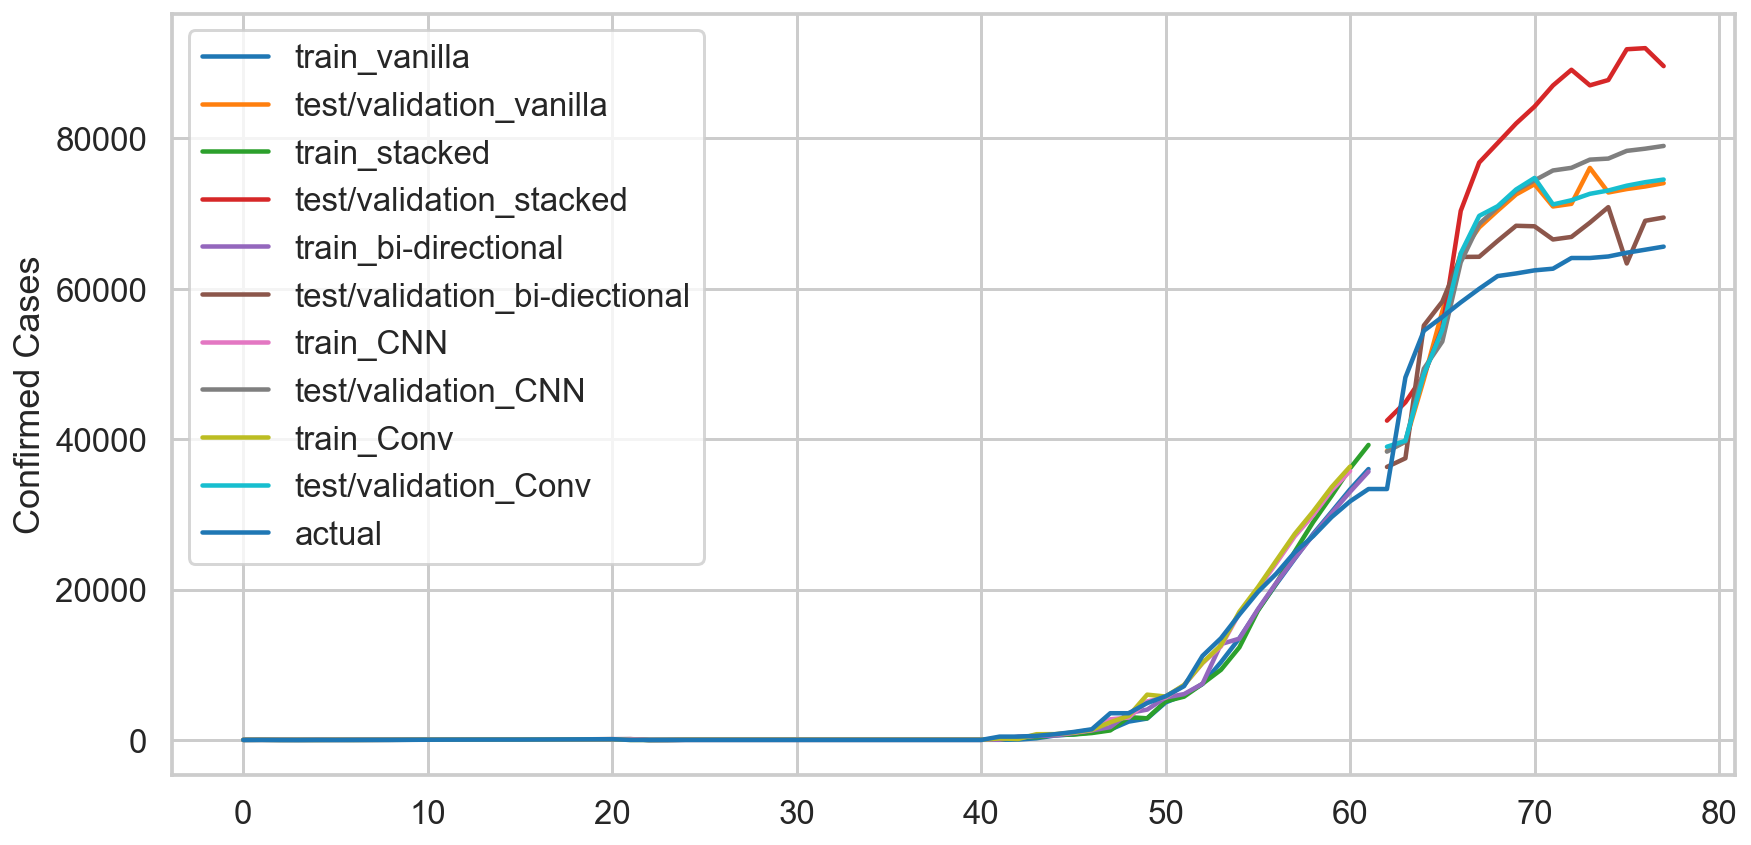

In [321]:
plt.figure(figsize=(14,7))
plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat, label = 'test/validation_vanilla')
plt.plot(y_train_pred_2, label = 'train_stacked')
plt.plot(range(len(y_train_pred), len(y)), yhat_2, label = 'test/validation_stacked')
plt.plot(y_train_pred_3, label = 'train_bi-directional')
plt.plot(range(len(y_train_pred), len(y)), yhat_3, label = 'test/validation_bi-diectional')
plt.plot(y_train_pred_4, label = 'train_CNN')
plt.plot(range(len(y_train_pred), len(y)), yhat_4, label = 'test/validation_CNN')
plt.plot(y_train_pred_5, label = 'train_Conv')
plt.plot(range(len(y_train_pred), len(y)), yhat_5, label = 'test/validation_Conv')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

**Conv seems to perform slightly better than CNN, on par with vanilla, not as well as bi-directional.**

**CNN-LSTM test predictions are much closer to actual cases as compared to the other models. This may be because I am using lag = 4 instead of lag = 3 as in previous cases. Also need to offset predictions to lag.**

## China, All Provinces

China, all ~31 provinces with reported cases

In [192]:
china_df = df.loc[df['country'] == 'China'].reset_index(drop=True)
print(len(china_df.loc_id.unique()))
china_df.head()

31


Province/State                   city_county_state country  hospital beds  physicians  GDP_per_capita  SPAR_index  IVDI_score     city_pop  effective_dist   geo_dist  ann_pass_flux  connected_airports       date  confirmed_cases  loc_id
0          Anhui  Lianhua Community, 合肥政务文化新区, Anhui   China            4.2      1.7855    18236.612982   94.307692    0.676294  1389.908204        5.802647  483.46519   4.596527e+06           35.288462 2019-12-08              0.0      44
1          Anhui  Lianhua Community, 合肥政务文化新区, Anhui   China            4.2      1.7855    18236.612982   94.307692    0.676294  1389.908204        5.802647  483.46519   4.596527e+06           35.288462 2019-12-09              0.0      44
2          Anhui  Lianhua Community, 合肥政务文化新区, Anhui   China            4.2      1.7855    18236.612982   94.307692    0.676294  1389.908204        5.802647  483.46519   4.596527e+06           35.288462 2019-12-10              0.0      44
3          Anhui  Lianhua Community, 合肥政务文化新区, Anhui   China            4.2      1.7855    18236.612982   94.307692    0.676294  1389.908204        5.802647  483.46519   4.596527e+06           35.288462 2019-12-11              0.0      44
4          Anhui  Lianhua Community, 合肥政务文化新区, Anhui   China            4.2      1.7855    18236.612982   94.307692    0.676294  1389.908204        5.802647  483.46519   4.596527e+06           35.288462 2019-12-12              0.0      44

### Multiple input series, vanilla, lag = 3

Two or more parallel input time series and an output time series that is dependent on the input time series.

Input time series are parallel because each series has an observation at the same time steps. This applies to each of our locations reported to have a number of coronavirus cases on a given date.

- Split the data into samples maintaining the order of observations across the different input sequences.

**This is used to predict total based on multiple inputs.** Does not predict what will happen at a specific location. We can apply any type of LSTM to this data format.

In [398]:
input_seqs = {loc:array(china_df.loc[china_df.loc_id == loc].confirmed_cases) 
              for loc in china_df.loc_id.unique()}
print(input_seqs[44].shape) # loc_id = 44, 82 time steps for each location

output_seq = np.empty(0)
for i in range(len(input_seqs[44])):
    output_i = 0
    for key, val in input_seqs.items():
        output_i += val[i]
    output_seq = np.append(output_seq, output_i)
print(output_seq.shape)

# convert to [rows, columns] structure
output_seq = output_seq.reshape((len(output_seq), 1))
print(output_seq.shape)

for key, val in input_seqs.items():
    input_seqs[key] = val.reshape((len(val), 1))
print(input_seqs[44].shape)

(81,)
(81,)
(81, 1)
(81, 1)


In [399]:
# horizontally stack columns
ar = np.empty(input_seqs[44].shape)
for i in input_seqs:
    inp = input_seqs[i]
    ar = np.append(ar, inp, axis=1)

ar = np.append(ar, output_seq, axis=1)

ar.shape

(81, 33)

In [312]:
n_steps = 3

X, y = split_sequences(ar, n_steps)
print(X.shape, y.shape)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

(79, 3, 32) (79,)


In [323]:
# Vanilla
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 47ms/step - loss: 120115956.6452 - val_loss: 4301308928.0000
Epoch 2/200
62/62 [==============================] - 0s 307us/step - loss: 116678811.8710 - val_loss: 4188657152.0000
Epoch 3/200
62/62 [==============================] - 0s 302us/step - loss: 110988647.7419 - val_loss: 4101402624.0000
Epoch 4/200
62/62 [==============================] - 0s 383us/step - loss: 108449593.0323 - val_loss: 4001990912.0000
Epoch 5/200
62/62 [==============================] - 0s 392us/step - loss: 105643260.3871 - val_loss: 3475698432.0000
Epoch 6/200
62/62 [==============================] - 0s 524us/step - loss: 97557608.7742 - val_loss: 3405788672.0000
Epoch 7/200
62/62 [==============================] - 0s 444us/step - loss: 93799681.5484 - val_loss: 3303721984.0000
Epoch 8/200
62/62 [==============================] - 0s 318us/step - loss: 90457840.9032 - val_loss: 3216672000.0000
Epoch 9/200
62/6

Epoch 71/200
62/62 [==============================] - 0s 403us/step - loss: 1503725.2258 - val_loss: 168487680.0000
Epoch 72/200
62/62 [==============================] - 0s 361us/step - loss: 1503212.5121 - val_loss: 163847648.0000
Epoch 73/200
62/62 [==============================] - 0s 447us/step - loss: 1506072.7903 - val_loss: 167549296.0000
Epoch 74/200
62/62 [==============================] - 0s 436us/step - loss: 1498808.9879 - val_loss: 175681568.0000
Epoch 75/200
62/62 [==============================] - 0s 396us/step - loss: 1499062.3629 - val_loss: 174538928.0000
Epoch 76/200
62/62 [==============================] - 0s 331us/step - loss: 1496009.4274 - val_loss: 174988096.0000
Epoch 77/200
62/62 [==============================] - 0s 307us/step - loss: 1496486.7823 - val_loss: 175657856.0000
Epoch 78/200
62/62 [==============================] - 0s 294us/step - loss: 1492160.7036 - val_loss: 174934400.0000
Epoch 79/200
62/62 [==============================] - 0s 332us/step - lo

**Loss is high compared to best univariate models.**

In [324]:
yhat_6 = model.predict(testX, verbose=1)
y_train_pred_6 = model.predict(trainX, verbose = 1)

62/62 [==============================] - 0s 103us/step


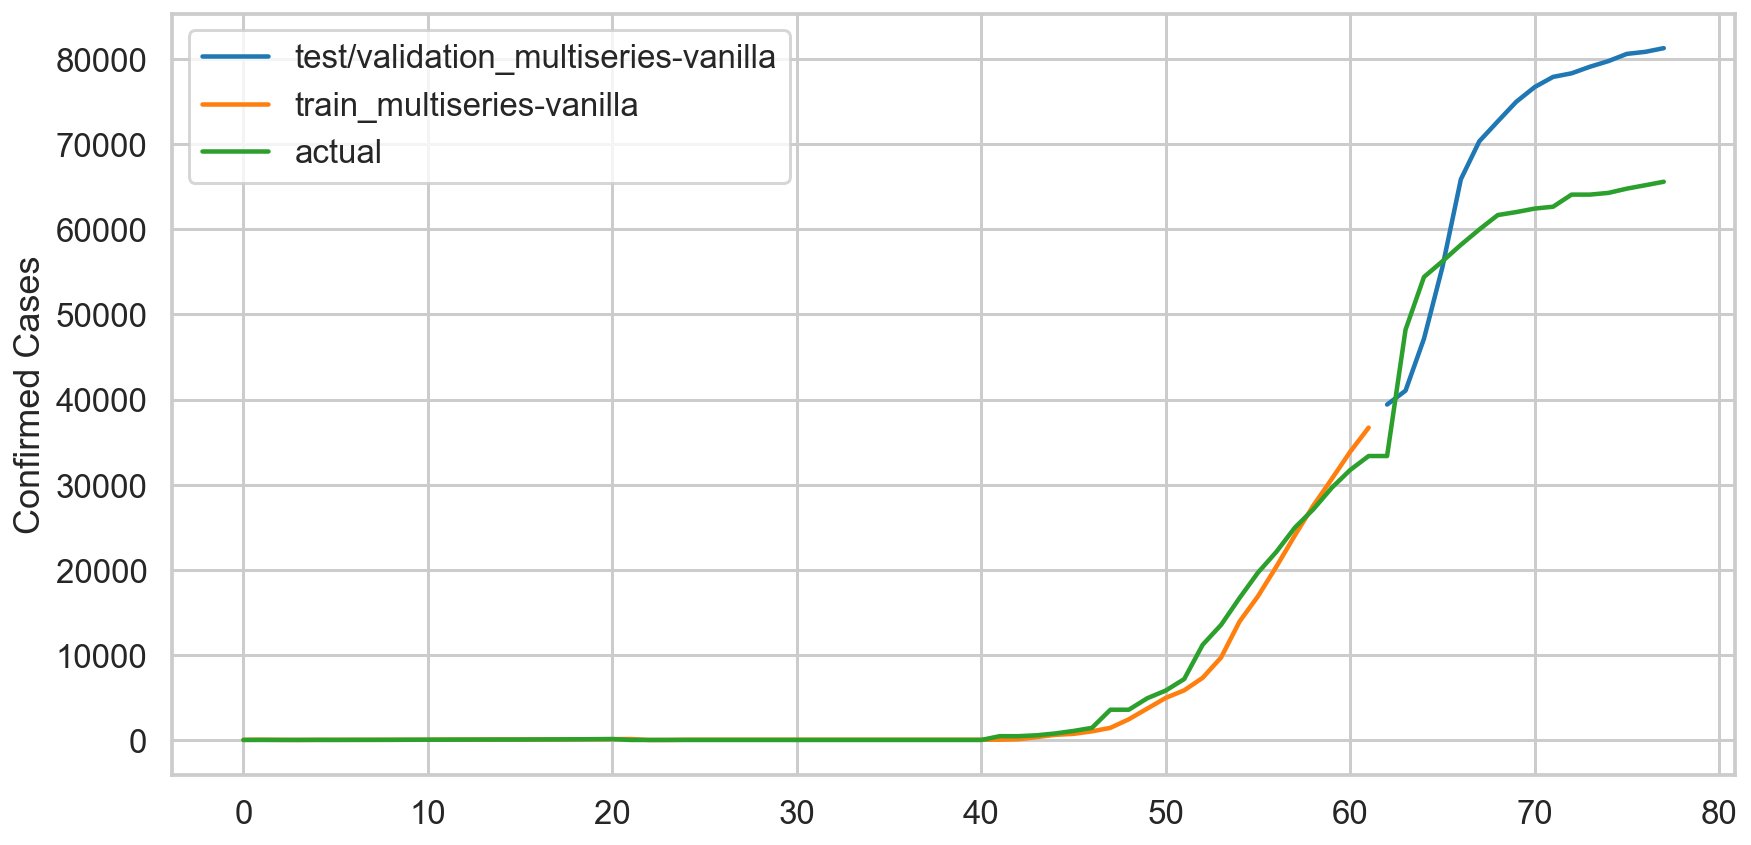

In [326]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat_6, label = 'test/validation_multiseries-vanilla')
plt.plot(y_train_pred_6, label = 'train_multiseries-vanilla')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

### Multiple parallel series

Where there are multiple parallel time series and a value must be predicted for each - multivariate forecasting.

The main difference appears to size of dense layer, or total number of features requiring predictions.

Use the same format of data as above.

In [337]:
# Vanilla, 100 LSTMs, lag = 3

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_8 = model.predict(testX, verbose=1)
y_train_pred_8 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 47ms/step - loss: 89800299.6129 - val_loss: 3228726784.0000
Epoch 2/200
62/62 [==============================] - 0s 319us/step - loss: 87187031.7419 - val_loss: 3166421504.0000
Epoch 3/200
62/62 [==============================] - 0s 342us/step - loss: 86476822.1935 - val_loss: 3121029632.0000
Epoch 4/200
62/62 [==============================] - 0s 698us/step - loss: 85201322.0645 - val_loss: 3032515584.0000
Epoch 5/200
62/62 [==============================] - 0s 372us/step - loss: 83683509.5484 - val_loss: 2956624896.0000
Epoch 6/200
62/62 [==============================] - 0s 357us/step - loss: 81186472.7742 - val_loss: 2808981504.0000
Epoch 7/200
62/62 [==============================] - 0s 377us/step - loss: 77933833.2903 - val_loss: 2591361536.0000
Epoch 8/200
62/62 [==============================] - 0s 365us/step - loss: 73994315.8710 - val_loss: 2413250560.0000
Epoch 9/200
62/62 [==

62/62 [==============================] - 0s 460us/step - loss: 1325513.9476 - val_loss: 160829568.0000
Epoch 142/200
62/62 [==============================] - 0s 469us/step - loss: 1332229.6129 - val_loss: 149334016.0000
Epoch 143/200
62/62 [==============================] - 0s 412us/step - loss: 1335864.4395 - val_loss: 145067184.0000
Epoch 144/200
62/62 [==============================] - 0s 429us/step - loss: 1251306.6935 - val_loss: 150465776.0000
Epoch 145/200
62/62 [==============================] - 0s 430us/step - loss: 1212485.1573 - val_loss: 148783056.0000
Epoch 146/200
62/62 [==============================] - 0s 321us/step - loss: 1195107.2157 - val_loss: 146648928.0000
Epoch 147/200
62/62 [==============================] - 0s 388us/step - loss: 1203954.5343 - val_loss: 148679456.0000
Epoch 148/200
62/62 [==============================] - 0s 437us/step - loss: 1184566.6532 - val_loss: 154844384.0000
Epoch 149/200
62/62 [==============================] - 0s 429us/step - loss: 1

In [338]:
# Stacked, 100 LSTMs, lag = 3

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_7 = model.predict(testX, verbose=1)
y_train_pred_7 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 54ms/step - loss: 93477296.5161 - val_loss: 3339173888.0000
Epoch 2/200
62/62 [==============================] - 0s 563us/step - loss: 90292401.0323 - val_loss: 3281580800.0000
Epoch 3/200
62/62 [==============================] - 0s 697us/step - loss: 86391500.9032 - val_loss: 3101777920.0000
Epoch 4/200
62/62 [==============================] - 0s 562us/step - loss: 84414012.6452 - val_loss: 3005681152.0000
Epoch 5/200
62/62 [==============================] - 0s 461us/step - loss: 81184803.0968 - val_loss: 2809109504.0000
Epoch 6/200
62/62 [==============================] - 0s 549us/step - loss: 77809486.1935 - val_loss: 2632930048.0000
Epoch 7/200
62/62 [==============================] - 0s 644us/step - loss: 74051789.4194 - val_loss: 2532375808.0000
Epoch 8/200
62/62 [==============================] - 0s 737us/step - loss: 71403345.4194 - val_loss: 2336746496.0000
Epoch 9/200
62/62 [==

62/62 [==============================] - 0s 507us/step - loss: 911916.6754 - val_loss: 123644240.0000
Epoch 142/200
62/62 [==============================] - 0s 563us/step - loss: 808522.6331 - val_loss: 113698080.0000
Epoch 143/200
62/62 [==============================] - 0s 495us/step - loss: 907334.5706 - val_loss: 54367440.0000
Epoch 144/200
62/62 [==============================] - 0s 500us/step - loss: 958503.7319 - val_loss: 26668884.0000
Epoch 145/200
62/62 [==============================] - 0s 546us/step - loss: 914496.9274 - val_loss: 113857568.0000
Epoch 146/200
62/62 [==============================] - 0s 492us/step - loss: 927099.1028 - val_loss: 152506992.0000
Epoch 147/200
62/62 [==============================] - 0s 471us/step - loss: 937723.9839 - val_loss: 176229536.0000
Epoch 148/200
62/62 [==============================] - 0s 505us/step - loss: 1002182.7863 - val_loss: 139166416.0000
Epoch 149/200
62/62 [==============================] - 0s 517us/step - loss: 905029.915

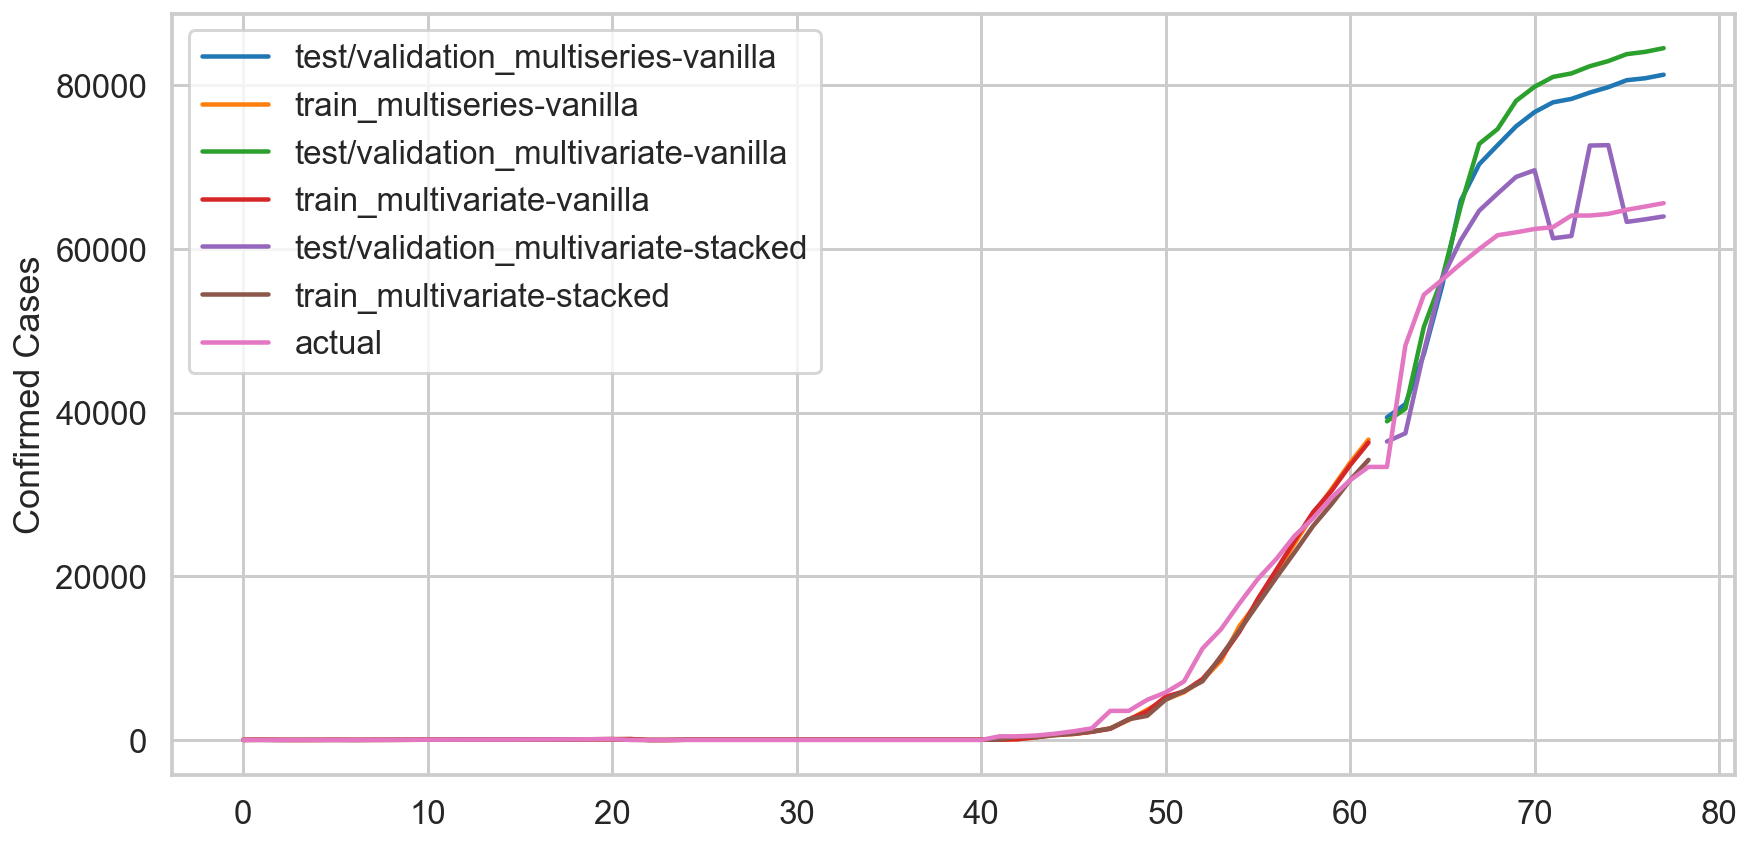

In [339]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat_6, label = 'test/validation_multiseries-vanilla')
plt.plot(y_train_pred_6, label = 'train_multiseries-vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_8, label = 'test/validation_multivariate-vanilla')
plt.plot(y_train_pred_8, label = 'train_multivariate-vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_7, label = 'test/validation_multivariate-stacked')
plt.plot(y_train_pred_7, label = 'train_multivariate-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [341]:
yhat_7

array([[36469.41 ],
       [37473.81 ],
       [47456.617],
       [56436.87 ],
       [61063.2  ],
       [64677.855],
       [66771.65 ],
       [68802.37 ],
       [69616.57 ],
       [61304.727],
       [61582.598],
       [72637.68 ],
       [72686.61 ],
       [63305.617],
       [63620.113],
       [63973.473]], dtype=float32)

In this example we are still predicting total cases in China by first predicting cases per location.

## Univariate Multi-Step

Predicting multiple time steps into the future. 

In [379]:
seq = hubei_df.confirmed_cases # start with univariate

n_steps_in, n_steps_out = 3, 2

X, y = split_sequence_multistep(seq, n_steps_in, n_steps_out)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [380]:
trainX.shape

(61, 3, 1)

### Vector Output

In [381]:
# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [382]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_44 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________


In [383]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 4s 73ms/step - loss: 88448590.2951 - val_loss: 3424561920.0000
Epoch 2/200
61/61 [==============================] - 0s 634us/step - loss: 87572580.9836 - val_loss: 3408214784.0000
Epoch 3/200
61/61 [==============================] - 0s 690us/step - loss: 87241756.6557 - val_loss: 3389490176.0000
Epoch 4/200
61/61 [==============================] - 0s 731us/step - loss: 86702488.7869 - val_loss: 3351252736.0000
Epoch 5/200
61/61 [==============================] - 0s 692us/step - loss: 85580808.0000 - val_loss: 3319981056.0000
Epoch 6/200
61/61 [==============================] - 0s 545us/step - loss: 84735987.4098 - val_loss: 3258683648.0000
Epoch 7/200
61/61 [==============================] - 0s 539us/step - loss: 83306117.2459 - val_loss: 3204780032.0000
Epoch 8/200
61/61 [==============================] - 0s 822us/step - loss: 82585561.4426 - val_loss: 3115282432.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 657us/step - loss: 3035096.3443 - val_loss: 501394176.0000
Epoch 72/200
61/61 [==============================] - 0s 566us/step - loss: 2758472.8525 - val_loss: 333042720.0000
Epoch 73/200
61/61 [==============================] - 0s 582us/step - loss: 2878279.2213 - val_loss: 337181440.0000
Epoch 74/200
61/61 [==============================] - 0s 740us/step - loss: 2733777.6127 - val_loss: 319043648.0000
Epoch 75/200
61/61 [==============================] - 0s 745us/step - loss: 2637204.6988 - val_loss: 340585856.0000
Epoch 76/200
61/61 [==============================] - 0s 776us/step - loss: 2657063.3484 - val_loss: 332033440.0000
Epoch 77/200
61/61 [==============================] - 0s 679us/step - loss: 2625571.2500 - val_loss: 347708064.0000
Epoch 78/200
61/61 [==============================] - 0s 763us/step - loss: 2550794.9467 - val_loss: 338673984.0000
Epoch 79/200
61/61 [==============================] - 0s 674us/step - loss: 2717598.6

In [384]:
yhat_9 = model.predict(testX, verbose=1)
y_train_pred_9 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 169us/step


In [385]:
# Vanilla
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [386]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________


In [387]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_10 = model.predict(testX, verbose=1)
y_train_pred_10 = model.predict(trainX, verbose = 1)

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 4s 63ms/step - loss: 84514365.5082 - val_loss: 3160479232.0000
Epoch 2/200
61/61 [==============================] - 0s 379us/step - loss: 81178518.2951 - val_loss: 3016621056.0000
Epoch 3/200
61/61 [==============================] - 0s 429us/step - loss: 78584015.8033 - val_loss: 2938279168.0000
Epoch 4/200
61/61 [==============================] - 0s 382us/step - loss: 75799361.7049 - val_loss: 2627264512.0000
Epoch 5/200
61/61 [==============================] - 0s 470us/step - loss: 71611925.2459 - val_loss: 2304095232.0000
Epoch 6/200
61/61 [==============================] - 0s 380us/step - loss: 67886419.8033 - val_loss: 2429728768.0000
Epoch 7/200
61/61 [==============================] - 0s 419us/step - loss: 66982809.8361 - val_loss: 2350622208.0000
Epoch 8/200
61/61 [==============================] - 0s 414us/step - loss: 64479984.6557 - val_loss: 1883568128.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 432us/step - loss: 2140266.8566 - val_loss: 261218480.0000
Epoch 72/200
61/61 [==============================] - 0s 407us/step - loss: 2135241.8197 - val_loss: 258094112.0000
Epoch 73/200
61/61 [==============================] - 0s 476us/step - loss: 2135689.2992 - val_loss: 252735696.0000
Epoch 74/200
61/61 [==============================] - 0s 451us/step - loss: 2134076.0758 - val_loss: 253435744.0000
Epoch 75/200
61/61 [==============================] - 0s 372us/step - loss: 2123244.0999 - val_loss: 251835840.0000
Epoch 76/200
61/61 [==============================] - 0s 442us/step - loss: 2119507.2582 - val_loss: 252305376.0000
Epoch 77/200
61/61 [==============================] - 0s 459us/step - loss: 2116099.7787 - val_loss: 253341088.0000
Epoch 78/200
61/61 [==============================] - 0s 411us/step - loss: 2106852.8402 - val_loss: 253067888.0000
Epoch 79/200
61/61 [==============================] - 0s 400us/step - loss: 2102603.3

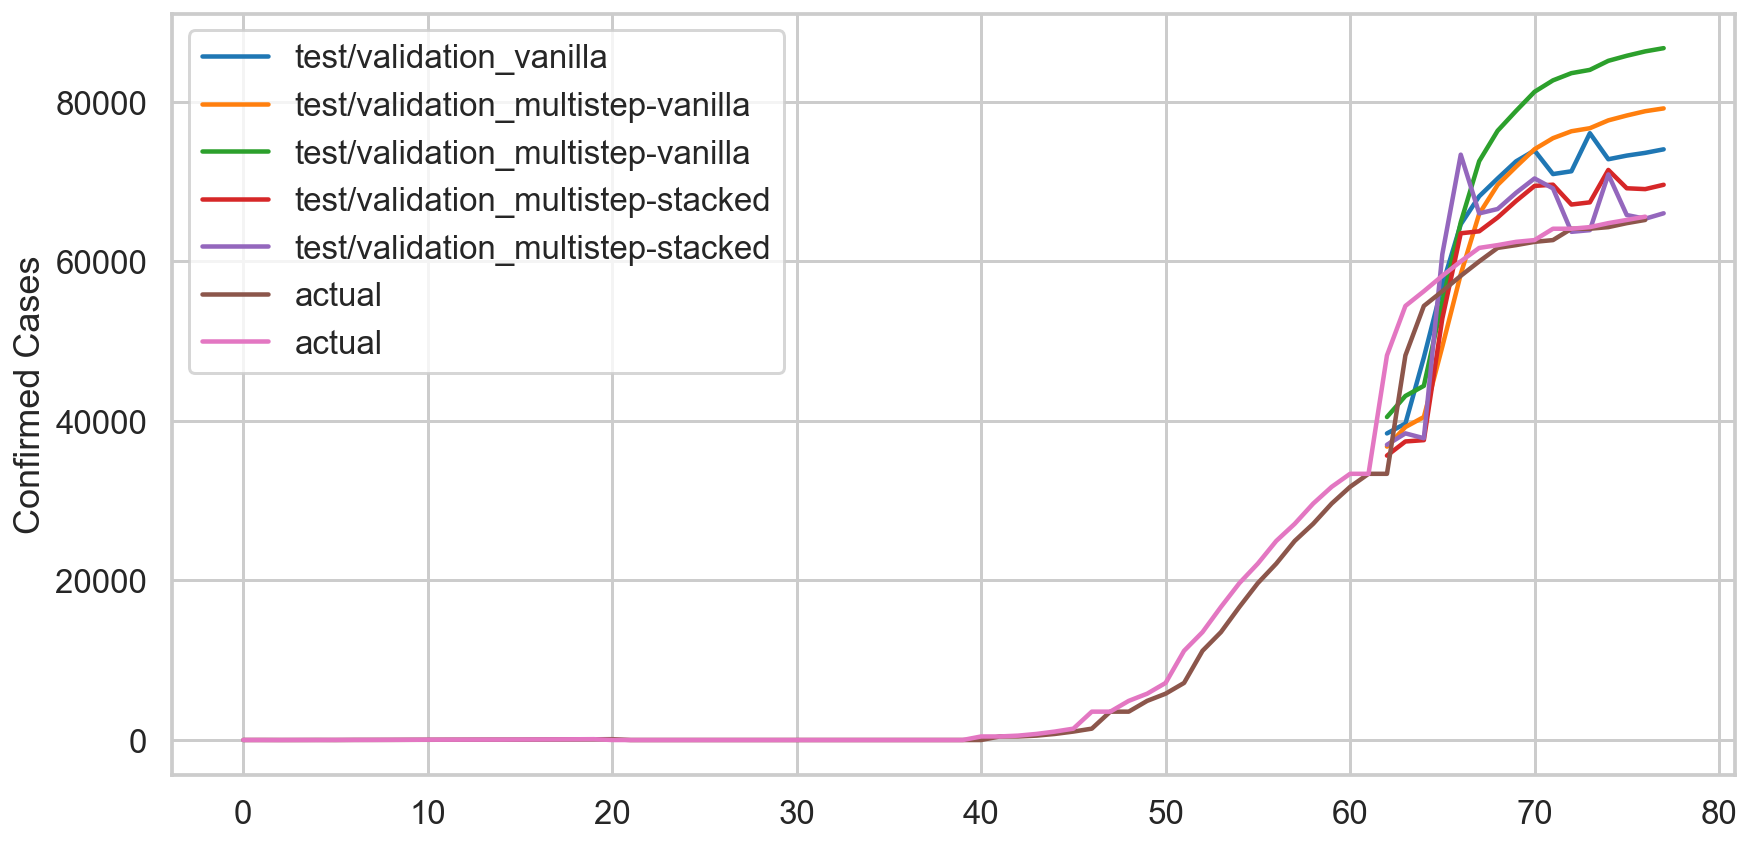

In [391]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat, label = 'test/validation_vanilla')
# plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_10, label = 'test/validation_multistep-vanilla')
# plt.plot(y_train_pred_10, label = 'train_multistep-vanilla')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_9, label = 'test/validation_multistep-stacked')
# plt.plot(y_train_pred_9, label = 'train_multistep-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [393]:
yhat_10

array([[36775.844, 40485.33 ],
       [39227.605, 43123.562],
       [40486.875, 44393.07 ],
       [49300.543, 54920.688],
       [58386.684, 64890.445],
       [65953.18 , 72552.61 ],
       [69580.05 , 76365.23 ],
       [71858.37 , 78856.19 ],
       [74053.63 , 81248.766],
       [75436.27 , 82682.86 ],
       [76304.086, 83586.07 ],
       [76686.26 , 83996.11 ],
       [77667.84 , 85131.31 ],
       [78278.22 , 85764.86 ],
       [78817.625, 86313.48 ],
       [79166.69 , 86719.95 ]], dtype=float32)

In [395]:
y[-16:]

array([[33366., 33366.],
       [33366., 48206.],
       [48206., 54406.],
       [54406., 56249.],
       [56249., 58182.],
       [58182., 59989.],
       [59989., 61682.],
       [61682., 62031.],
       [62031., 62442.],
       [62442., 62662.],
       [62662., 64084.],
       [64084., 64084.],
       [64084., 64287.],
       [64287., 64786.],
       [64786., 65187.],
       [65187., 65596.]])

### Encoder-Decoder

Forecasting variable length output sequences - not needed in this case

## Multivariate Multi-Step

### Multiple Input, Multi-Step Output

Assumes no relationship among provinces.

In [400]:
# 'ar' is a column stack of all china province time series, last column = sum all time points for each location 

n_steps_in, n_steps_out = 3, 2
dataset = ar
X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2] # number of provinces

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_11 = model.predict(testX, verbose=1)
y_train_pred_11 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 5s 75ms/step - loss: 159653101.4194 - val_loss: 4973594112.0000
Epoch 2/200
62/62 [==============================] - 0s 645us/step - loss: 159133452.6452 - val_loss: 4917453312.0000
Epoch 3/200
62/62 [==============================] - 0s 656us/step - loss: 155892164.6452 - val_loss: 4723893760.0000
Epoch 4/200
62/62 [==============================] - 0s 633us/step - loss: 154992716.9032 - val_loss: 4478444544.0000
Epoch 5/200
62/62 [==============================] - 0s 634us/step - loss: 153373734.1935 - val_loss: 4325367296.0000
Epoch 6/200
62/62 [==============================] - 0s 658us/step - loss: 144648701.4194 - val_loss: 4151736832.0000
Epoch 7/200
62/62 [==============================] - 0s 753us/step - loss: 141385695.4839 - val_loss: 4051640832.0000
Epoch 8/200
62/62 [==============================] - 0s 651us/step - loss: 136762511.4839 - val_loss: 3598446592.0000
Epoch 9/200
6

62/62 [==============================] - 0s 647us/step - loss: 259360.6794 - val_loss: 47493628.0000
Epoch 143/200
62/62 [==============================] - 0s 640us/step - loss: 246469.7752 - val_loss: 53084288.0000
Epoch 144/200
62/62 [==============================] - 0s 644us/step - loss: 239330.0464 - val_loss: 56923312.0000
Epoch 145/200
62/62 [==============================] - 0s 706us/step - loss: 246259.7505 - val_loss: 56837040.0000
Epoch 146/200
62/62 [==============================] - 0s 641us/step - loss: 248754.0862 - val_loss: 52650768.0000
Epoch 147/200
62/62 [==============================] - 0s 649us/step - loss: 246612.2772 - val_loss: 54140208.0000
Epoch 148/200
62/62 [==============================] - 0s 651us/step - loss: 245569.4980 - val_loss: 52084008.0000
Epoch 149/200
62/62 [==============================] - 0s 660us/step - loss: 249003.3105 - val_loss: 53353364.0000
Epoch 150/200
62/62 [==============================] - 0s 633us/step - loss: 237036.6270 - val

**This is the lowest loss of all models so far.**

### Multiple Parallel Input, Multi-Step Output

In [403]:
dataset = ar

n_steps_in, n_steps_out = 3, 2

X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_12 = model.predict(testX, verbose=1)
y_train_pred_12 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 4s 71ms/step - loss: 162301681.2903 - val_loss: 4945119232.0000
Epoch 2/200
62/62 [==============================] - 0s 544us/step - loss: 159958462.4516 - val_loss: 4842165248.0000
Epoch 3/200
62/62 [==============================] - 0s 741us/step - loss: 159175030.4516 - val_loss: 4866066432.0000
Epoch 4/200
62/62 [==============================] - 0s 683us/step - loss: 157540277.1613 - val_loss: 4761122816.0000
Epoch 5/200
62/62 [==============================] - 0s 683us/step - loss: 154202032.5161 - val_loss: 4678981120.0000
Epoch 6/200
62/62 [==============================] - 0s 633us/step - loss: 152804664.0000 - val_loss: 4651025920.0000
Epoch 7/200
62/62 [==============================] - 0s 626us/step - loss: 149896200.2581 - val_loss: 4539082240.0000
Epoch 8/200
62/62 [==============================] - 0s 741us/step - loss: 147548352.5161 - val_loss: 4383941632.0000
Epoch 9/200
6

Epoch 142/200
62/62 [==============================] - 0s 858us/step - loss: 428307.4536 - val_loss: 23363436.0000
Epoch 143/200
62/62 [==============================] - 0s 653us/step - loss: 894936.6048 - val_loss: 55350016.0000
Epoch 144/200
62/62 [==============================] - 0s 678us/step - loss: 1106649.2117 - val_loss: 22506858.0000
Epoch 145/200
62/62 [==============================] - 0s 787us/step - loss: 299258.7883 - val_loss: 22935948.0000
Epoch 146/200
62/62 [==============================] - 0s 748us/step - loss: 929083.1230 - val_loss: 26944906.0000
Epoch 147/200
62/62 [==============================] - 0s 714us/step - loss: 788222.2762 - val_loss: 20444432.0000
Epoch 148/200
62/62 [==============================] - 0s 688us/step - loss: 381457.9062 - val_loss: 20745608.0000
Epoch 149/200
62/62 [==============================] - 0s 757us/step - loss: 342927.8810 - val_loss: 25787160.0000
Epoch 150/200
62/62 [==============================] - 0s 870us/step - loss: 31

**This model has even better loss!**

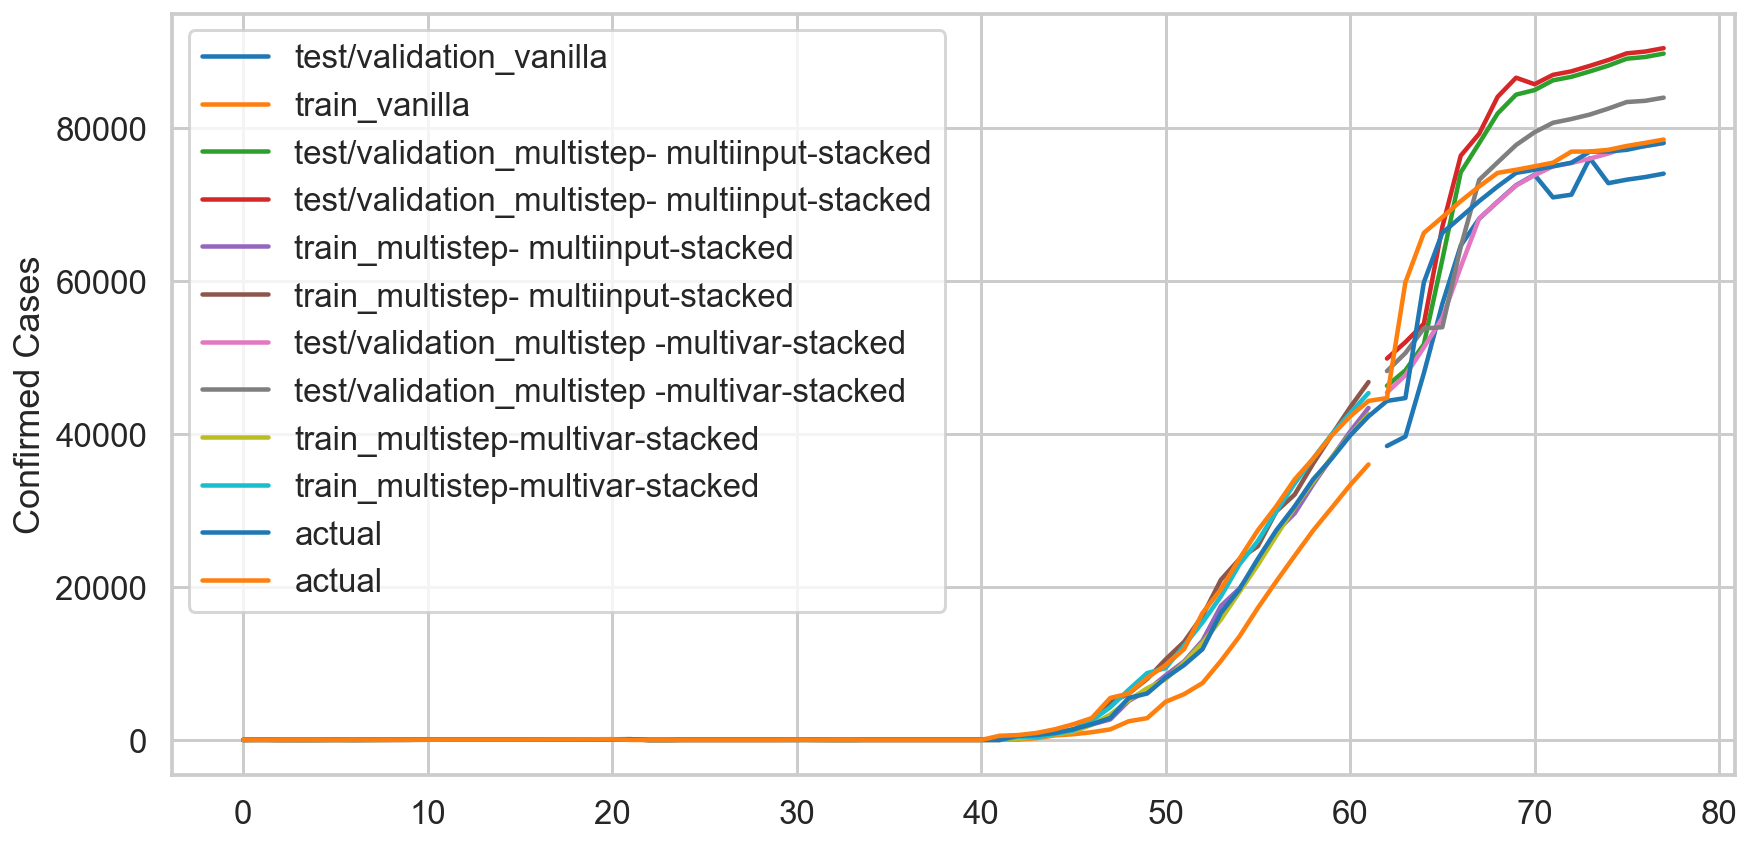

In [405]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat, label = 'test/validation_vanilla')
plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_11, label = 'test/validation_multistep- multiinput-stacked')
plt.plot(y_train_pred_11, label = 'train_multistep- multiinput-stacked')
plt.plot(range(len(y_train_pred), len(y)), yhat_12, label = 'test/validation_multistep -multivar-stacked')
plt.plot(y_train_pred_12, label = 'train_multistep-multivar-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

## Multi-step Multivariate Conv2D, lag = 3

### China

In [409]:
dataset = ar

n_steps_in, n_steps_out = 4, 2

X, y = split_sequences_multistep(ar, n_steps_in, n_steps_out)
X.shape

(77, 4, 32)

In [419]:
n_features = X.shape[2]
n_seq = 2

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_out, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [420]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_split = 0.1)

yhat_13 = model.predict(testX, verbose=1)
y_train_pred_13 = model.predict(trainX, verbose = 1)

Train on 54 samples, validate on 7 samples
Epoch 1/200
54/54 [==============================] - 5s 102ms/step - loss: 13651506.6759 - val_loss: 764085568.0000
Epoch 2/200
54/54 [==============================] - 0s 390us/step - loss: 13329736.4444 - val_loss: 736791616.0000
Epoch 3/200
54/54 [==============================] - 0s 353us/step - loss: 13177142.0000 - val_loss: 706068352.0000
Epoch 4/200
54/54 [==============================] - 0s 820us/step - loss: 12960846.7407 - val_loss: 679468928.0000
Epoch 5/200
54/54 [==============================] - 0s 605us/step - loss: 12732646.7037 - val_loss: 648769536.0000
Epoch 6/200
54/54 [==============================] - 0s 427us/step - loss: 12511333.7778 - val_loss: 635232064.0000
Epoch 7/200
54/54 [==============================] - 0s 394us/step - loss: 12327706.5370 - val_loss: 625508224.0000
Epoch 8/200
54/54 [==============================] - 0s 384us/step - loss: 12063416.4074 - val_loss: 614522304.0000
Epoch 9/200
54/54 [==========

Epoch 142/200
54/54 [==============================] - 0s 509us/step - loss: 122701.7627 - val_loss: 158451040.0000
Epoch 143/200
54/54 [==============================] - 0s 479us/step - loss: 121305.6953 - val_loss: 178517424.0000
Epoch 144/200
54/54 [==============================] - 0s 338us/step - loss: 121294.9699 - val_loss: 178807408.0000
Epoch 145/200
54/54 [==============================] - 0s 404us/step - loss: 121184.1377 - val_loss: 179876336.0000
Epoch 146/200
54/54 [==============================] - 0s 445us/step - loss: 120996.8662 - val_loss: 181449056.0000
Epoch 147/200
54/54 [==============================] - 0s 467us/step - loss: 120883.3657 - val_loss: 183394960.0000
Epoch 148/200
54/54 [==============================] - 0s 536us/step - loss: 120428.6202 - val_loss: 182542608.0000
Epoch 149/200
54/54 [==============================] - 0s 379us/step - loss: 120547.7025 - val_loss: 186074912.0000
Epoch 150/200
54/54 [==============================] - 0s 414us/step - l

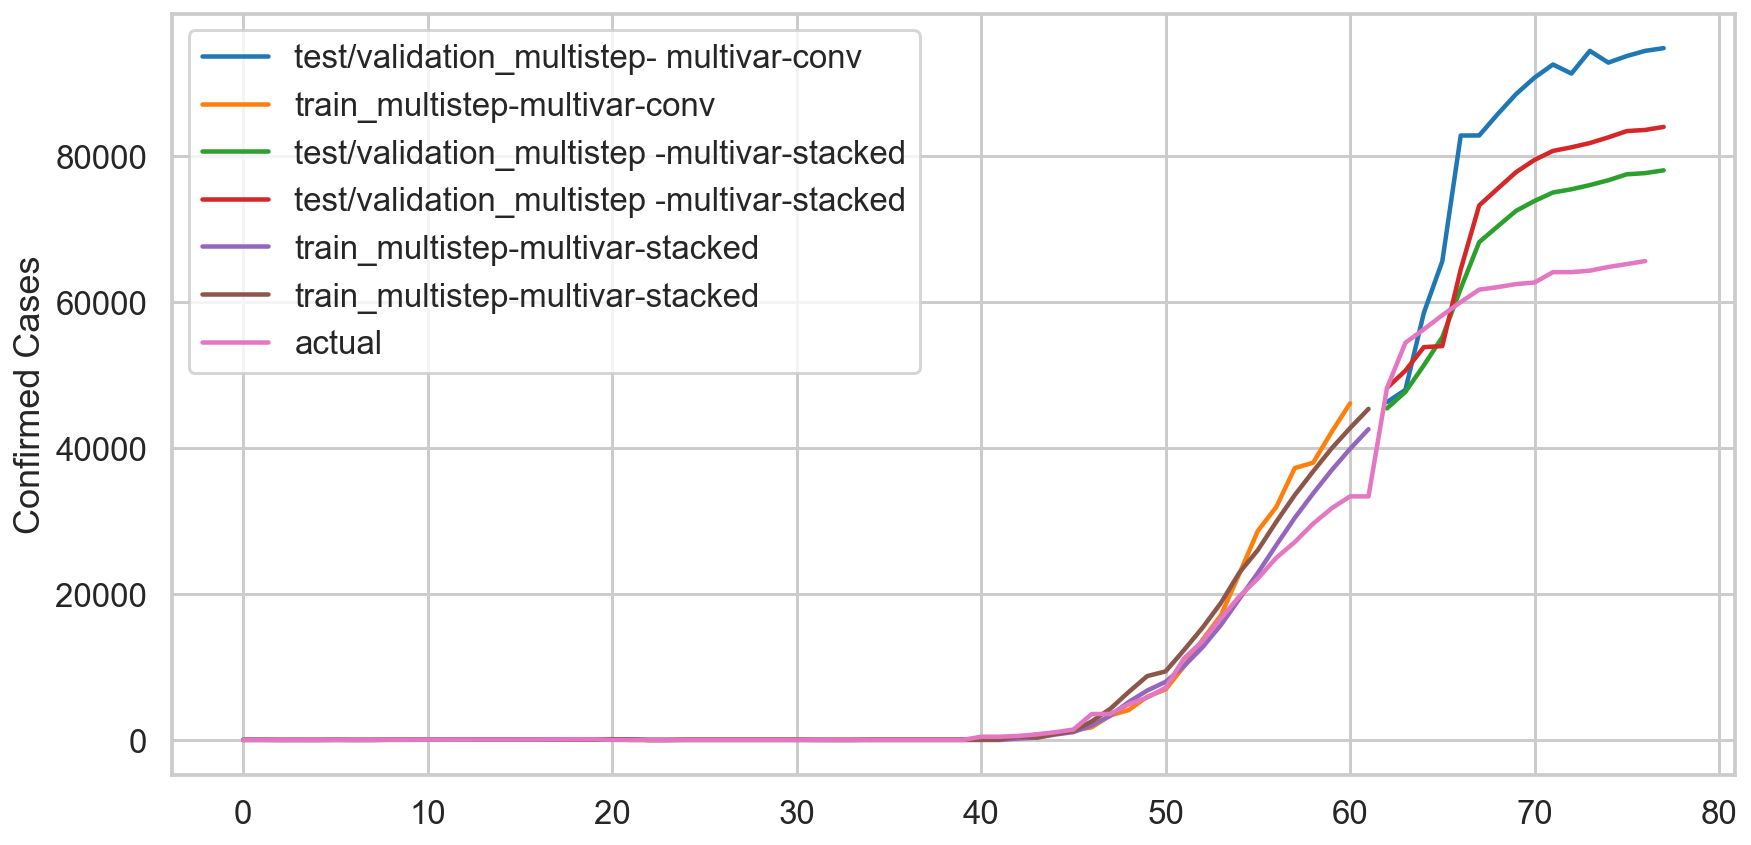

In [423]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat_13, label = 'test/validation_multistep- multivar-conv')
plt.plot(y_train_pred_13, label = 'train_multistep-multivar-conv')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_12, label = 'test/validation_multistep -multivar-stacked')
plt.plot(y_train_pred_12, label = 'train_multistep-multivar-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

### World

In [429]:
input_seqs = {loc:array(df.loc[df.loc_id == loc].confirmed_cases) 
              for loc in df.loc_id.unique()}
print(input_seqs[44].shape) # loc_id = 44, 82 time steps for each location

output_seq = np.empty(0)
for i in range(len(input_seqs[44])):
    output_i = 0
    for key, val in input_seqs.items():
        output_i += val[i]
    output_seq = np.append(output_seq, output_i)
print(output_seq.shape)

# convert to [rows, columns] structure
output_seq = output_seq.reshape((len(output_seq), 1))
print(output_seq.shape)

for key, val in input_seqs.items():
    input_seqs[key] = val.reshape((len(val), 1))
print(input_seqs[44].shape)

# horizontally stack columns
ar = np.empty(input_seqs[44].shape)
for i in input_seqs:
    inp = input_seqs[i]
    ar = np.append(ar, inp, axis=1)

w_ar = np.append(ar, output_seq, axis=1)

w_ar.shape

(81,)
(81,)
(81, 1)
(81, 1)


(81, 106)

In [436]:
dataset = w_ar

n_steps_in, n_steps_out = 4, 2
n_seq = 2

X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)
X.shape

(77, 4, 105)

In [437]:
n_features = X.shape[2]
X = X.reshape(X.shape[0], n_seq, 1, n_steps, n_features)

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_out, n_features)))
model.add(Flatten())
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 1, 1, 64)          86784     
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 130       
Total params: 86,914
Trainable params: 86,914
Non-trainable params: 0
_________________________________________________________________


Train on 54 samples, validate on 7 samples
Epoch 1/200
54/54 [==============================] - 0s 659us/step - loss: 104832.2653 - val_loss: 227618224.0000
Epoch 2/200
54/54 [==============================] - 0s 796us/step - loss: 104461.2066 - val_loss: 225262416.0000
Epoch 3/200
54/54 [==============================] - 0s 407us/step - loss: 101849.3015 - val_loss: 222336000.0000
Epoch 4/200
54/54 [==============================] - 0s 471us/step - loss: 100250.6788 - val_loss: 217358240.0000
Epoch 5/200
54/54 [==============================] - 0s 447us/step - loss: 98821.9337 - val_loss: 213141744.0000
Epoch 6/200
54/54 [==============================] - 0s 685us/step - loss: 97547.5347 - val_loss: 208887024.0000
Epoch 7/200
54/54 [==============================] - 0s 692us/step - loss: 97066.6908 - val_loss: 204931152.0000
Epoch 8/200
54/54 [==============================] - 0s 584us/step - loss: 96379.3979 - val_loss: 201869072.0000
Epoch 9/200
54/54 [==============================

54/54 [==============================] - 0s 577us/step - loss: 64991.4062 - val_loss: 126331576.0000
Epoch 144/200
54/54 [==============================] - 0s 447us/step - loss: 64039.6832 - val_loss: 129842120.0000
Epoch 145/200
54/54 [==============================] - 0s 415us/step - loss: 63729.8547 - val_loss: 132693688.0000
Epoch 146/200
54/54 [==============================] - 0s 501us/step - loss: 62538.3313 - val_loss: 133252208.0000
Epoch 147/200
54/54 [==============================] - 0s 513us/step - loss: 62048.2080 - val_loss: 133466096.0000
Epoch 148/200
54/54 [==============================] - 0s 467us/step - loss: 61189.2922 - val_loss: 132827816.0000
Epoch 149/200
54/54 [==============================] - 0s 523us/step - loss: 60678.6357 - val_loss: 131913944.0000
Epoch 150/200
54/54 [==============================] - 0s 473us/step - loss: 60810.6479 - val_loss: 130816120.0000
Epoch 151/200
54/54 [==============================] - 0s 566us/step - loss: 59818.0503 - val_

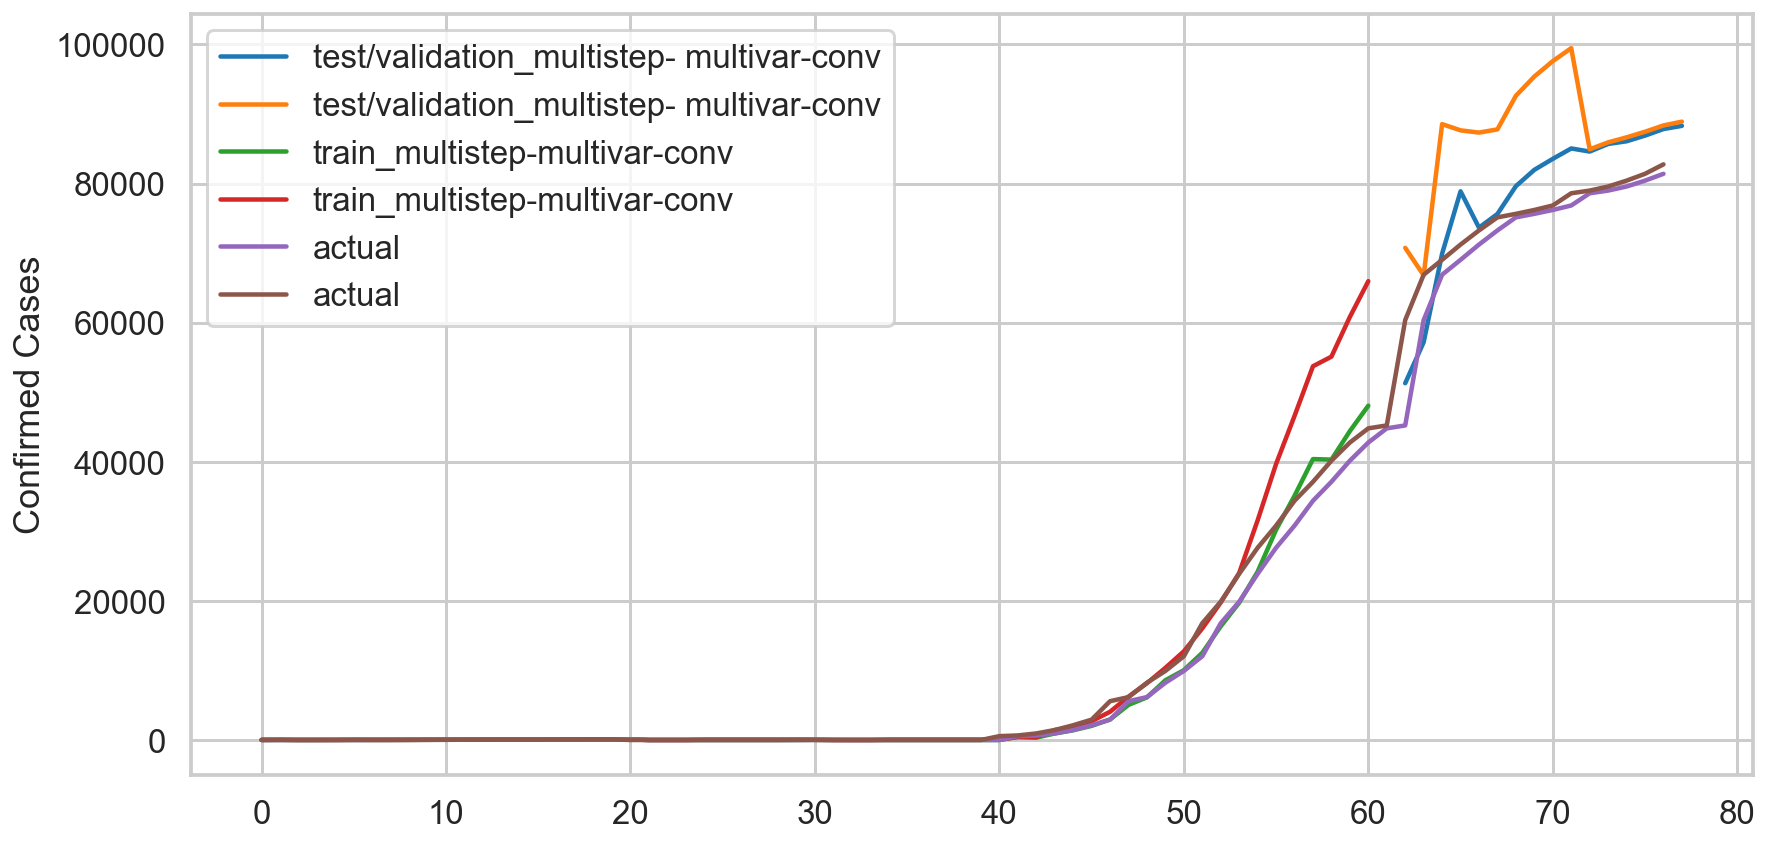

In [439]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_split = 0.1)

yhat_14 = model.predict(testX, verbose=1)
y_train_pred_14 = model.predict(trainX, verbose = 1)

plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat_14, label = 'test/validation_multistep- multivar-conv')
plt.plot(y_train_pred_14, label = 'train_multistep-multivar-conv')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# SIR Epidemic Models

Susceptible, infectious, and recovered individuals as f(t)provided transition rates between compartments.
- Nonlinear system - Monte Carlo, Gillespie algorithm
- Ro (reproduction ratio) is critical
- Idea is that the end of an epidemic is caused by the decline in the number of infected individuals rather than an absolute lack of susceptible subjects
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

## The basic model

Python code for curves
https://en.wikipedia.org/wiki/Gillespie_algorithm

Used in city coronavirus model here
https://lexparsimon.github.io/coronavirus/

In [32]:
import math
import random

# Input parameters ####################

# int; total population
N = 350

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = 100.0

# float; rate of infection after contact
_alpha = 10.0

# float; rate of cure
_beta = 0.5

# int; initial infected population
n_I = 1

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = _alpha * n_S * n_I / V
    w2 = _beta * n_I
    W = w1 + w2

    dt = -math.log(random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))

with open('SIR_data.txt', 'w+') as fp:
    fp.write('\n'.join('%f %i %i %i' % x for x in SIR_data))

plt.plot(SIR_data[t], n_S)

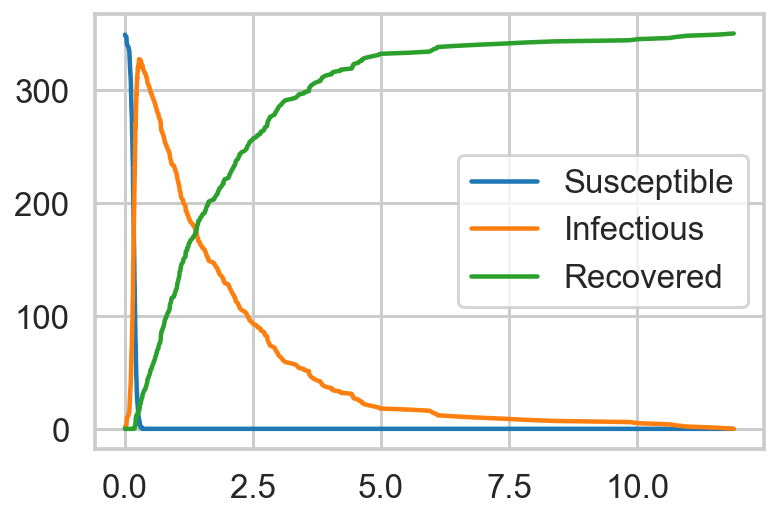

In [42]:
t = []
n_S = []
n_I = []
n_R = []

for index, val in enumerate(SIR_data):
    t.append(SIR_data[index][0])
    n_S.append(SIR_data[index][1])
    n_I.append(SIR_data[index][2])
    n_R.append(SIR_data[index][3])

plt.plot(t, n_S, label = 'Susceptible')
plt.plot(t, n_I, label = 'Infectious')
plt.plot(t, n_R, label = 'Recovered')
plt.legend()
plt.show()

In [41]:
SIR_data[1]

(0.005117699519555275, 348, 2, 0)

## SIR + origin-destination flow matrices
Modeling coronavirus based on traffic patterns in a given city -- requires an origin-destination flow matrix, which can be mathematically inferred from flux between locations within a network...https://onlinelibrary.wiley.com/doi/full/10.1002/atr.187
- Transmission rate beta randomly assigned for given location on given day
- Modal share (constant across city) or the intensity of public transport is factored in as a variable that can be adjusted to observe effects of halting transit.

Python code for running the model:
https://lexparsimon.github.io/coronavirus/

In [ ]:
# Here, the OD matrix can be pass_flux?
# a 2d matrix documenting passenger flux between distinct locations


In [ ]:
import numpy as np

# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                 # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,0] = N_k                      # initialize the S group with the respective populations

first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

# initialize parameters
beta = 1.6
gamma = 0.04
public_trans = 0.5                                 # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(1.6, 2, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
from tqdm import tqdm_notebook
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm_notebook(range(100)):
  infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
  OD_infected = np.round(OD*infected_mat)
  inflow_infected = OD_infected.sum(axis=0)
  inflow_infected = np.round(inflow_infected*public_trans_vec)
  print('total infected inflow: ', inflow_infected.sum())
  new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
  new_recovered = gamma_vec*SIR_sim[:, 1]
  new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
  SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
  SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
  SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
  SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
  # recompute the normalized SIR matrix
  row_sums = SIR_sim.sum(axis=1)
  SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
  S = SIR_sim[:,0].sum()/N_k.sum()
  I = SIR_sim[:,1].sum()/N_k.sum()
  R = SIR_sim[:,2].sum()/N_k.sum()
  print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
  print('\n')
  infected_pop_norm.append(I)
  susceptible_pop_norm.append(S)
  recovered_pop_norm.append(R)

# All features, Conv2d LSTM

Here, the input at each time step with a 3d numpy array of features organized by location (lat, long). 
The training prediction or output is a 2d array with predicted cases by location, which varies over time unlike the static feature space.

**Input shape**

4D tensor with shape: (batch, channels, rows, cols) if data_format is "channels_first" or 4D tensor with shape: (batch, rows, cols, channels) if data_format is "channels_last".

**Output shape**

4D tensor with shape: (batch, filters, new_rows, new_cols) if data_format is "channels_first" or 4D tensor with shape: (batch, new_rows, new_cols, filters) if data_format is "channels_last". rows and cols values might have changed due to padding.



## Input feature array

In [4]:
features_df = pd.read_csv('fs_df.csv', index_col = 0)
features_df.head()


Lat   Long  latest_hosp_beds_per_1000  latest_doctors_per_1000  GDP_per_capita  SPAR_index  IVDI_score     city_pop  effective_dist     geo_dist  ann_pass_flux  connected_airports
0  43.9   12.5                        3.8                   6.1468    13536.794829   32.846154    0.696439   811.059130       12.909125  8530.463669   3.312232e+06           54.719512
1  24.0   54.0                        1.2                   2.3944    75075.257411   94.615385    0.718802  1210.169908       12.417796  5798.434510   9.665304e+06           70.277778
2  21.0   57.0                        1.6                   1.9697    41859.934477  100.000000    0.617149  1085.491700       11.108324  5690.297304   8.373158e+06           72.250000
3  29.5   47.8                        2.0                   2.5789    72897.562345   55.615385    0.668414  1290.116059       13.896034  6180.024430   2.496246e+06           28.187500
4  15.0  101.0                        2.1                   0.8096    19051.333382   79.461538    0.687330  1862.299400        7.352859  2074.761769   6.238800e+06           32.937500

In [6]:
hosp_beds = features_df.pivot('Lat','Long', 'latest_hosp_beds_per_1000').fillna(0).values
phys = features_df.pivot('Lat','Long', 'latest_doctors_per_1000').fillna(0).values
GDP = features_df.pivot('Lat','Long', 'GDP_per_capita').fillna(0).values
SPAR = features_df.pivot('Lat','Long', 'SPAR_index').fillna(0).values
IVDI = features_df.pivot('Lat','Long', 'IVDI_score').fillna(0).values
city_pop = features_df.pivot('Lat','Long', 'city_pop').fillna(0).values
eff_dist = features_df.pivot('Lat','Long', 'effective_dist').fillna(0).values
geo_dist = features_df.pivot('Lat','Long', 'geo_dist').fillna(0).values
pass_flux = features_df.pivot('Lat','Long', 'ann_pass_flux').fillna(0).values
conn_airports = features_df.pivot('Lat','Long', 'connected_airports').fillna(0).values

hosp_beds

array([[0. , 0. , 0. , ..., 3.8, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 3.8, 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [70]:
feats_3d = np.dstack((hosp_beds, phys, GDP, SPAR, IVDI, city_pop, eff_dist, geo_dist, pass_flux,
                             conn_airports))
feats_3d.shape

(91, 101, 10)

## Output array

In [55]:
ts_df = pd.read_csv('ts_lat_long_df.csv', index_col = 0)
ts_df = ts_df.round({'Lat': 1, 'Long':1})
ts_df.head()

Lat   Long  12/08/19  12/09/19  12/10/19  12/11/19  12/12/19  12/13/19  12/14/19  12/15/19  12/16/19  12/17/19  12/18/19  12/19/19  12/20/19  12/21/19  12/22/19  12/23/19  12/24/19  12/25/19  12/26/19  12/27/19  12/28/19  12/29/19  12/30/19  12/31/19  01/01/20  01/02/20  01/03/20  01/04/20  01/05/20  01/06/20  01/07/20  01/08/20  01/09/20  1/10/20  01/11/20  01/12/20  01/13/20  01/14/20  01/15/20  01/16/20  01/17/20  01/18/20  01/19/20  01/20/20  01/21/20  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20
0  43.9   12.5       0.0         0         0       0.0       0.0         0         0       0.0         0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0         0         0         0         0         0         0         0         0         0      0.0         0         0         0         0         0         0         0         0         0         0         0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0
1  24.0   54.0       0.0         0         0       0.0       0.0         0         0       0.0         0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0         0         0         0         0         0         0         0         0         0      0.0         0         0         0         0         0         0         0         0         0         0         0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      4.0      4.0      4.0     4.0     5.0     5.0     5.0     5.0     5.0     5.0     7.0     7.0      8.0      8.0      8.0      8.0      8.0      8.0      9.0      9.0      9.0      9.0      9.0      9.0     13.0     13.0     13.0     13.0     13.0     13.0
2  21.0   57.0       0.0         0         0       0.0       0.0         0         0       0.0         0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0         0         0         0         0         0         0         0         0         0      0.0         0         0         0         0         0         0         0         0         0         0         0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      2.0      2.0      4.0      4.0
3  29.5   47.8       0.0         0         0       0.0       0.0         0         0       0.0         0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0       0.0         0         0         0         0         0         0         0         0         0      0.0         0         0         0         0         0         0         0         0         0         0         0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0     11.0     26.0     43.0
4  15.0  101.0       0.0         0         0       0.0       0.0

In [56]:
date_list = ts_df.columns.to_list()
date_list.remove('Lat')
date_list.remove('Long')

In [57]:
dct = {}
for index, date in enumerate(date_list):
    dct[index] = ts_df.pivot('Lat','Long', date).fillna(0).values

In [58]:
dct[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
len(dct)

82

In [59]:
dct[0].shape # want size (91, 101, 82 (len(dct)))

(91, 101)

## Integrating each time point into X and y

In [67]:
ts_np = np.empty(dct[0].shape)
for i in dct:
    inp = dct[i]
    ts_np = np.dstack((ts_np, inp))

ts_np.shape

(91, 101, 83)

In [72]:
ts_np[:,:,0:].shape # remove empty 2d array stacked at bottom to initiate the loop above

(91, 101, 82)

In [76]:
ts_np = ts_np[:,:,0:]

In [80]:
feats_3d.shape # want size (91, 101, 10*len(dct) = 820)

(91, 101, 10)

In [103]:
feats_time = np.empty(feats_3d.shape)
for i in dct:
    inp = feats_3d
    feats_time = np.dstack((feats_time, inp))

feats_time.shape

(91, 101, 830)

In [104]:
feats_time[:,:,10:].shape

(91, 101, 820)

In [105]:
feats_time = feats_time[:,:,10:]

In [129]:
X = feats_time
y = ts_np

## Time lag and train/test split

In [130]:
n_steps = 3

In [131]:
# need 3 y observations concatenated and 3 x observations concatenated before any stacking in order to 
# make predictions based on more than one previous time step

In [132]:
# chopping the time dimension for train/test split
lenX = X.shape[2]
leny =y.shape[2]
train_size = 0.82 # choose a number divisible by len(dct) = 82   

trainX = X[:, :, :int(train_size*lenX)]
trainy = y[:, :, :int(train_size*leny)]
testX = X[:, :, int(train_size*lenX):]
testy = y[:, :, int(train_size*leny):]

In [133]:
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(91, 101, 672) (91, 101, 66)
(91, 101, 148) (91, 101, 15)


In [117]:
# min/max scaling 



(91, 101, 672) (91, 101, 66)
(91, 101, 148) (91, 101, 15)


## Model design

In [119]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

In [134]:
# testX.reshape(1, testX.shape[0], testX.shape[1], testX.shape[2])
testX.shape

(91, 101, 148)

In [126]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(91, 101, 672), data_format = 'channels_last'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 89, 99, 32)        193568    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 87, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 48, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 41, 46, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 39, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 26752)             0         
__________

In [127]:
model.fit(trainX, trainy, batch_size=10, epochs=200, verbose=1, validation_split = 0.2)
score = model.evaluate(testX, testy, batch_size=10)

ValueError: Error when checking input: expected conv2d_14_input to have 4 dimensions, but got array with shape (91, 101, 672)

## Model evaluation

In [ ]:
yhat_6 = model.predict(testX, verbose=1)
y_train_pred_6 = model.predict(trainX, verbose = 1)

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat_6, label = 'test/validation_multiseries-vanilla')
plt.plot(y_train_pred_6, label = 'train_multiseries-vanilla')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# NARX in PyNeurGen

Begin by following getting started tutorial here:
http://pyneurgen.sourceforge.net/tutorial_nn.html

In [137]:
import random
import math

import matplotlib.pyplot as plt
# from pylab import plot, legend, subplot, grid, xlabel, ylabel, show, title
import pyneurgen
# from pyneurgen.neuralnet import NeuralNet
# from pyneurgen.nodes import BiasNode, Connection

In [139]:
#   all samples are drawn from this population
pop_len = 200
factor = 1.0 / float(pop_len)
population = [[i, math.sin(float(i) * factor * 10.0) + \
                random.gauss(float(i) * factor, .2)]
                    for i in range(pop_len)]

all_inputs = []
all_targets = []

def population_gen(population):
    """
    This function shuffles the values of the population and yields the
    items in a random fashion.

    """

    pop_sort = [item for item in population]
    random.shuffle(pop_sort)

    for item in pop_sort:
        yield item

#   Build the inputs
for position, target in population_gen(population):
    pos = float(position)
    all_inputs.append([random.random(), pos * factor])
    all_targets.append([target])

In [141]:
net = pyneurgen.neuralnet.NeuralNet()
net.init_layers(2, [10], 1)

net.randomize_network()
net.set_halt_on_extremes(True)

#   Set to constrain beginning weights to -.5 to .5
#       Just to show we can
net.set_random_constraint(.5)
net.set_learnrate(.1)

AttributeError: module 'pyneurgen' has no attribute 'neuralnet'

Modules appear deprecated.

# NARX in fireTS

Look at code here to get started: https://pypi.org/project/fireTS/

## Test package import and example code for functionality

In [142]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

In [143]:
# Random training data
x = np.random.randn(100, 2)
y = np.random.randn(100)

# Build a non-linear autoregression model with exogenous inputs
# using Random Forest regression as the base model
mdl1 = NARX(
    RandomForestRegressor(n_estimators=10),
    auto_order=2,
    exog_order=[2, 2],
    exog_delay=[1, 1])
mdl1.fit(x, y)
ypred1 = mdl1.predict(x, y, step=3)

# Build a general autoregression model and make multi-step prediction directly
# using XGBRegressor as the base model
mdl2 = DirectAutoRegressor(
    XGBRegressor(n_estimators=10),
    auto_order=2,
    exog_order=[2, 2],
    exog_delay=[1, 1],
    pred_step=3)
mdl2.fit(x, y)
ypred2 = mdl2.predict(x, y)

[13:40:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [144]:
from fireTS.models import NARX
from sklearn.ensemble import RandomForestRegressor
import numpy as np

x = np.random.randn(100, 1)
y = np.random.randn(100)

# DirectAutoRegressor can do grid search as well
mdl = NARX(RandomForestRegressor(), auto_order=2, exog_order=[2], exog_delay=[1])

# Grid search
para_grid = {'n_estimators': [10, 30, 100]}
mdl.grid_search(x, y, para_grid, verbose=2)

# Best hyper-parameters are set after grid search, print the model to see the difference
print(mdl)

# Fit the model and make the prediction
mdl.fit(x, y)
ypred = mdl.predict(x, y, step=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.0s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   0.0s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   0.0s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   0.1s
NARX(auto_order=2,
     base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=10, n_jobs=None,
    

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished


**Great, this runs at least!**

Now look at these two more extensive examples and try to adapt to our case:

Blood glucose prediction
https://github.com/jxx123/fireTS/blob/master/examples/Basic%20usage%20of%20NARX%20and%20DirectAutoregressor.ipynb


Grid searching for same example as above
https://github.com/jxx123/fireTS/blob/master/examples/Use%20Grid%20Search%20to%20tune%20the%20hyper-parameter%20of%20base%20model.ipynb

## Single exogenous variable

Import example and single location coronavirus data for example replication in parallel  :)

In [181]:
from fireTS.models import NARX
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

### Data prep

In [182]:
# data is formatted with columns as time, features time series

data = pd.read_csv('adolescent#001.csv')
data = data.set_index('Time')
data.index = pd.to_datetime(data.index)
data.columns

Index(['BG', 'CGM', 'CHO', 'insulin', 'LBGI', 'HBGI', 'Risk'], dtype='object')

In [183]:
# can we try this example with wuhan_df in parallel?

hubei_df = hubei_df.set_index('date').drop(columns = ['Province/State', 'city_county_state', 'country'])
hubei_df.index = pd.to_datetime(hubei_df.index)
hubei_df.columns

Index(['hospital beds', 'physicians', 'GDP_per_capita', 'SPAR_index', 'IVDI_score', 'city_pop', 'effective_dist', 'geo_dist', 'ann_pass_flux', 'connected_airports', 'confirmed_cases'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a323dfb00>,
      dtype=object)

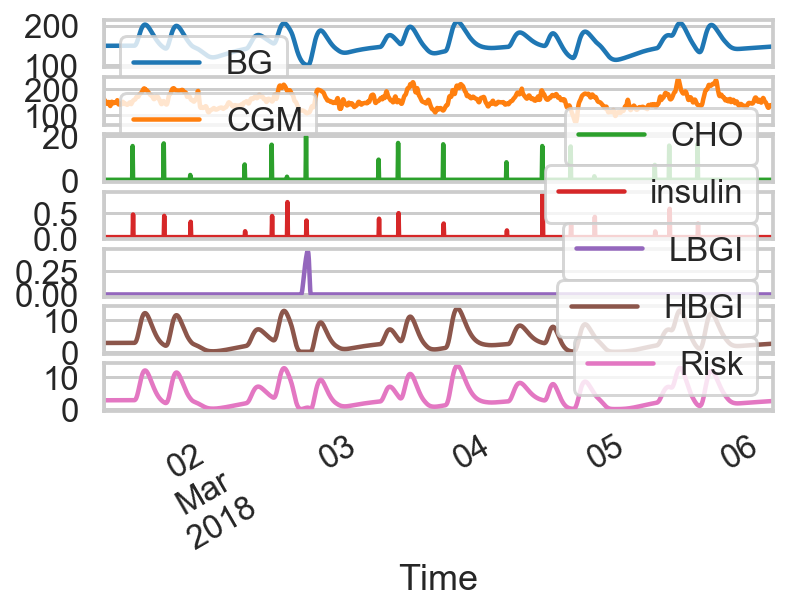

In [184]:
data.plot(subplots=True)

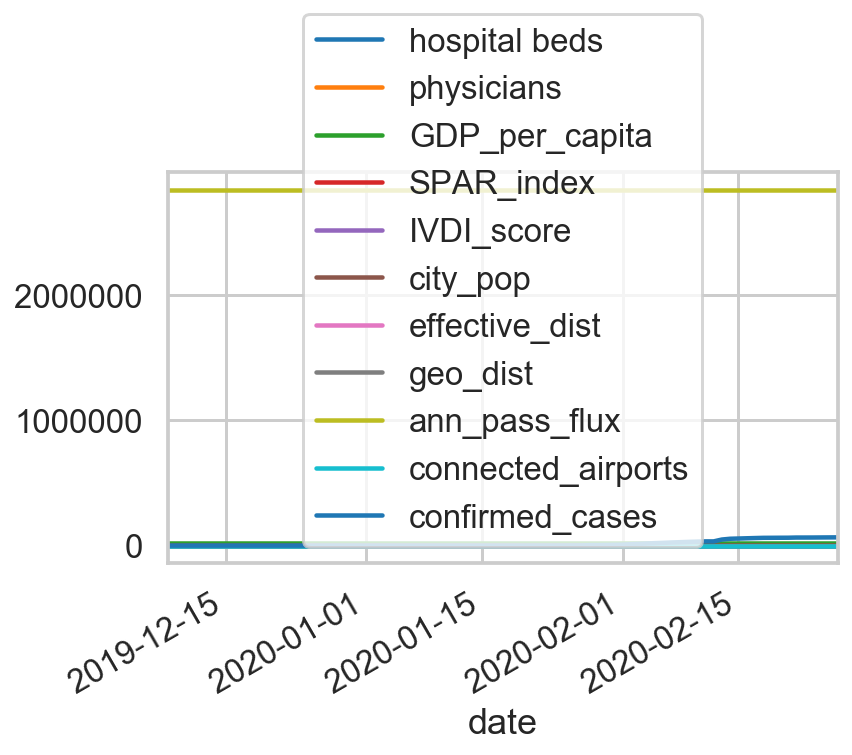

In [185]:
hubei_df.plot() # as expected, all of our features for a singe location are constant

In [222]:
# Predict the blood glucose level measured by the Continuous Glucose Monitor (CGM) 
# using insulin and meal as the exogenous inputs.

ytrain = data['CGM'].iloc[:1000]
Xtrain = data.loc[:, ['insulin', 'CGM']].iloc[:1000, :] # both y and x are included here with y as last var

ytest = data['CGM'].iloc[1000:-1]
Xtest = data.loc[:, ['insulin', 'CGM']].iloc[1000:-1, :]

print(ytrain.shape, Xtrain.shape, ytest.shape, Xtest.shape)

(1000,) (1000, 2) (440,) (440, 2)


In [292]:
# Predict cases of coronavirus using all variables as exogenous inputs

train_size = 0.8

trainy = hubei_df['confirmed_cases'].iloc[:int(len(hubei_df)*train_size)]
trainX = hubei_df.loc[:, ['ann_pass_flux', 'confirmed_cases']].iloc[:int(len(hubei_df)*train_size), :]

testy = hubei_df['confirmed_cases'].iloc[int(len(hubei_df)*train_size):-1]
testX = hubei_df.loc[:, ['ann_pass_flux', 'confirmed_cases']].iloc[int(len(hubei_df)*train_size):-1, :]

print(trainy.shape, trainX.shape, testy.shape, testX.shape)

(64,) (64, 2) (16,) (16, 2)


### Build the NARX model

Here linearRegression is used as base model. The time series model we are building becomes an Autoregression with Exogenous Inputs (ARX) model. The autoregression order is set to 6, the orders of the exogenous inputs are both set to 3 and the delays of the exogenous inputs are both set to 0.

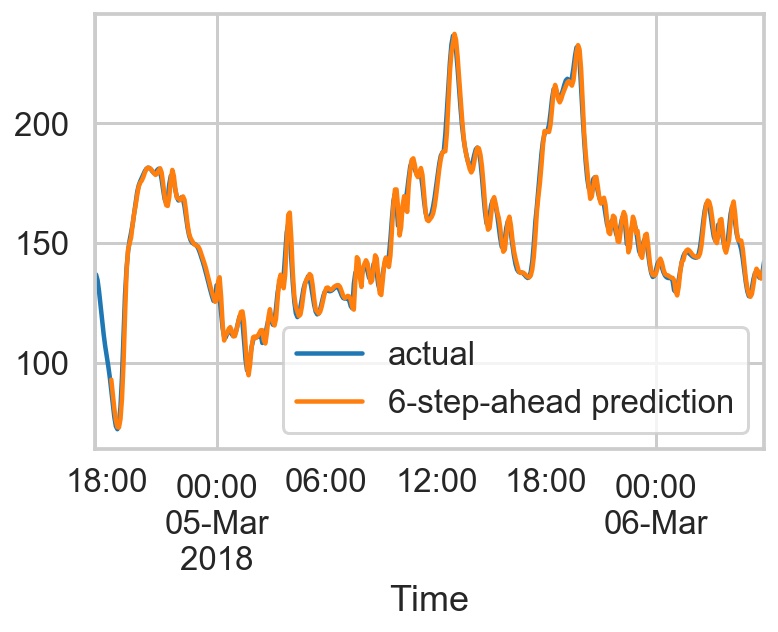

In [224]:
# predicting glucose 6 steps ahead

narx_mdl = NARX(LinearRegression(), auto_order=6, exog_order=[3, 3], exog_delay=[0, 0])

narx_mdl.fit(Xtrain, ytrain)

ypred_narx = narx_mdl.predict(Xtest, ytest, step=6)
ypred_narx = pd.Series(ypred_narx, index=ytest.index)

ytest.plot(label='actual')
ypred_narx.plot(label='6-step-ahead prediction')
plt.legend()

In [225]:
narx_mdl.score(Xtest, ytest, step=6, method='mse')

9.16250543263012

In [226]:
narx_mdl.score(Xtest, ytest, step=6, method='r2')

0.9895663461567726

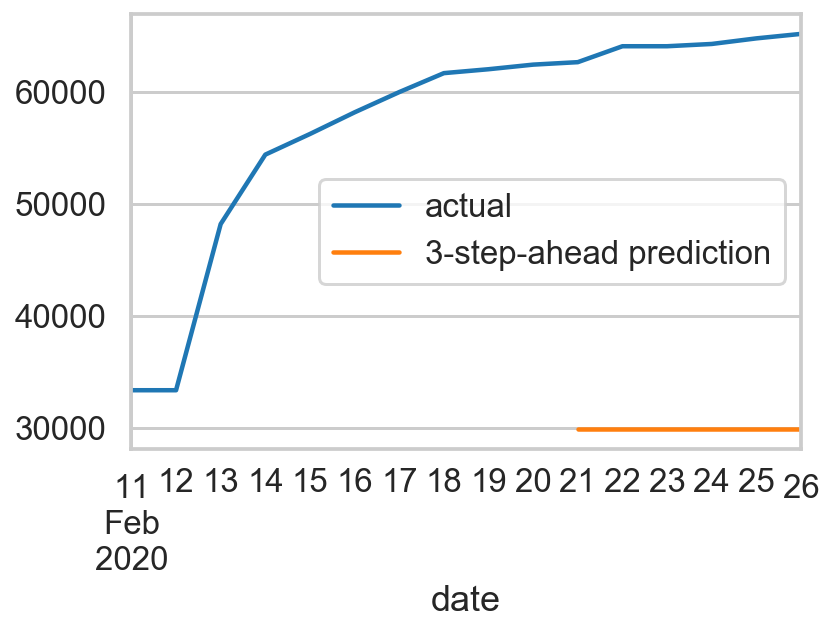

In [294]:
# predicting coronavirus 3 steps ahead
from sklearn.ensemble import RandomForestRegressor
narx_mdl = NARX(RandomForestRegressor(n_estimators = 300, max_depth=3), auto_order=8, exog_order=[3,3], exog_delay=[0, 0])

narx_mdl.fit(trainX, trainy)

pred_narx = narx_mdl.predict(testX, testy, step=3)
pred_narx = pd.Series(pred_narx, index=testy.index)

testy.plot(label='actual')
pred_narx.plot(label='3-step-ahead prediction')
plt.legend()

In [227]:
narx_mdl.score(testX, testy, step=3, method='mse')

116494400387.57704

In [228]:
narx_mdl.score(testX, testy, step=3, method='r2')

-98353.78056700708

### Build the DirectAutoRegressor for Comparison

The prediction step size must be specified in the constructor.

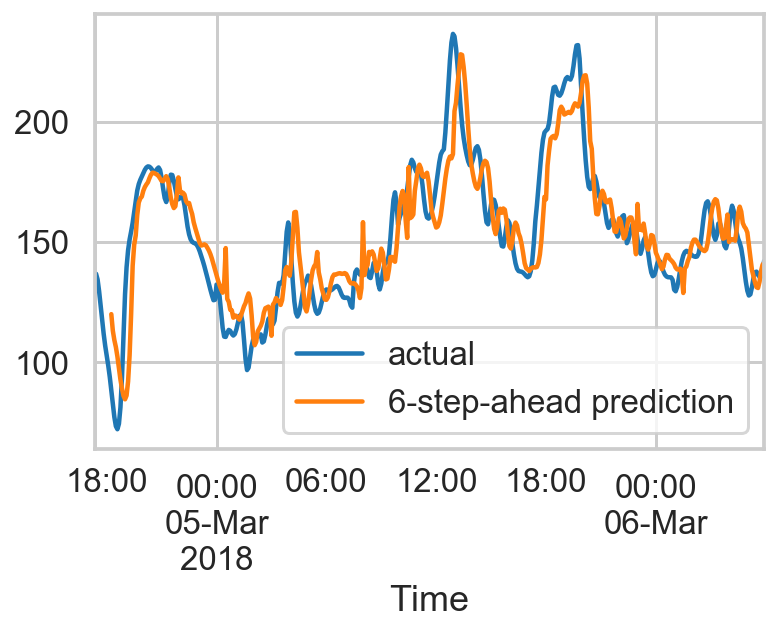

In [208]:
direct_mdl = DirectAutoRegressor(LinearRegression(), 
                                 auto_order=6, 
                                 exog_order=[3, 3], 
                                 exog_delay=[0, 0], 
                                 pred_step=6)

# No prediction step can be set in the predict method.

direct_mdl.fit(Xtrain, ytrain)
ypred_direct = direct_mdl.predict(Xtest, ytest)
ypred_direct = pd.Series(ypred_direct, index=ytest.index)

ytest.plot(label='actual')
ypred_direct.plot(label='6-step-ahead prediction')
plt.legend()

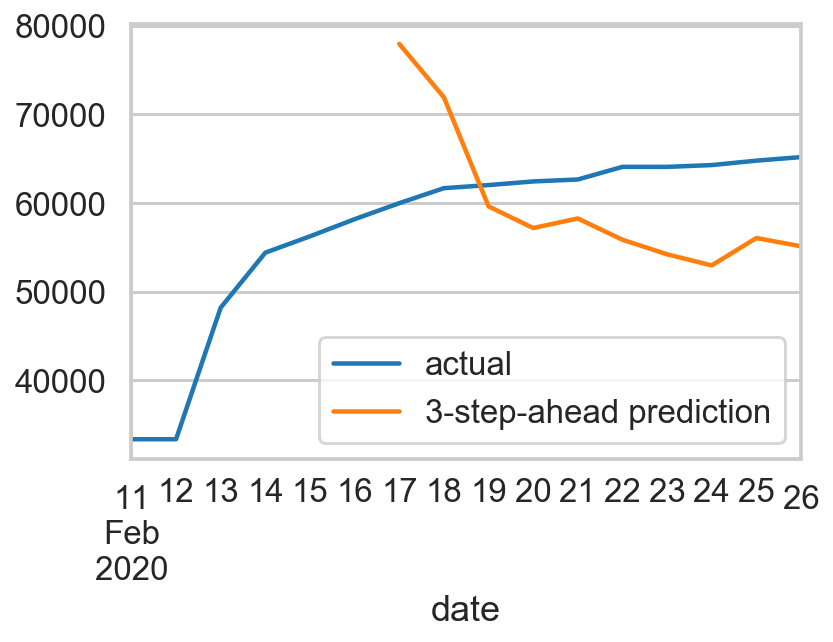

In [236]:
direct_mdl = DirectAutoRegressor(LinearRegression(), 
                                 auto_order=4, 
                                 exog_order=[3, 3], 
                                 exog_delay=[0, 0], 
                                 pred_step=3)

# No prediction step can be set in the predict method.

direct_mdl.fit(trainX, trainy)
pred_direct = direct_mdl.predict(testX, testy)
pred_direct = pd.Series(pred_direct, index=testy.index)

testy.plot(label='actual')
pred_direct.plot(label='3-step-ahead prediction')
plt.legend()

### Trial grid searching parameters

In [237]:
# for blood sugar example

para_grid = {
    'gamma': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015, 0.03, 0.05],
    'C': [0.1, 0.3, 1, 3, 10, 30, 100],
    'epsilon': [0.001, 0.003, 0.005, 0.008, 0.01, 0.015, 0.03]
}

tsmdl = NARX(SVR(kernel='rbf'), auto_order=6, exog_order=[3, 3], exog_delay=[0, 0])
tsmdl.grid_search(Xtrain, ytrain, para_grid, verbose=2)

Fitting 3 folds for each of 392 candidates, totalling 1176 fits
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.005 ...............................
[CV] ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=0.1, epsilon=0.001, gamma=0.005, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.005 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.005, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.01 ................................
[CV] ................. C=0.1, epsilon=0.001, gamma=0.01, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.01 ................................
[CV] ................. C=0.1, epsilon=0.001, gamma=0.01, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.01 ................................
[CV] .

[CV] ................. C=0.1, epsilon=0.005, gamma=0.03, total=   0.1s
[CV] C=0.1, epsilon=0.005, gamma=0.03 ................................
[CV] ................. C=0.1, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=0.1, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=0.1, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=0.1, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=0.1, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.008, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.008, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.008, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.008, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.008, gamma=0.001 ...............................
[CV] .

[CV] ................ C=0.1, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.005 ...............................
[CV] ................ C=0.1, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.005 ...............................
[CV] ................ C=0.1, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.008 ...............................
[CV] ................ C=0.1, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=0.1, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=0.1, epsilon=0.015, gamma=0.01 ................................
[CV] .

[CV] ................ C=0.3, epsilon=0.001, gamma=0.015, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.015 ...............................
[CV] ................ C=0.3, epsilon=0.001, gamma=0.015, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.03 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.03, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.03 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.03, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.03 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.03, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.05 ................................
[CV] .

[CV] ................ C=0.3, epsilon=0.008, gamma=0.005, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.005 ...............................
[CV] ................ C=0.3, epsilon=0.008, gamma=0.005, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=0.3, epsilon=0.008, gamma=0.008, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=0.3, epsilon=0.008, gamma=0.008, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=0.3, epsilon=0.008, gamma=0.008, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.01 ................................
[CV] ................. C=0.3, epsilon=0.008, gamma=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.01 ................................
[CV] ................. C=0.3, epsilon=0.008, gamma=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.008, gamma=0.01 ................................
[CV] .

[CV] ................. C=0.3, epsilon=0.015, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.05 ................................
[CV] ................. C=0.3, epsilon=0.015, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.001 ................................
[CV] ................. C=0.3, epsilon=0.03, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.001 ................................
[CV] ................. C=0.3, epsilon=0.03, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.001 ................................
[CV] ................. C=0.3, epsilon=0.03, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.003 ................................
[CV] ................. C=0.3, epsilon=0.03, gamma=0.003, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.003 ................................
[CV] ................. C=0.3, epsilon=0.03, gamma=0.003, total=   0.0s
[CV] C=0.3, epsilon=0.03, gamma=0.003 ................................
[CV] .

[CV] .................. C=1, epsilon=0.003, gamma=0.008, total=   0.0s
[CV] C=1, epsilon=0.003, gamma=0.01 ..................................
[CV] ................... C=1, epsilon=0.003, gamma=0.01, total=   0.1s
[CV] C=1, epsilon=0.003, gamma=0.01 ..................................
[CV] ................... C=1, epsilon=0.003, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.003, gamma=0.01 ..................................
[CV] ................... C=1, epsilon=0.003, gamma=0.01, total=   0.1s
[CV] C=1, epsilon=0.003, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.003, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.003, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.003, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.003, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.003, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.003, gamma=0.03 ..................................
[CV] .

[CV] ................... C=1, epsilon=0.01, gamma=0.003, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.003 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.003, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.003 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.003, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.005 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.005, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.005 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.005, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.005 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.005, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.008 ..................................
[CV] ................... C=1, epsilon=0.01, gamma=0.008, total=   0.0s
[CV] C=1, epsilon=0.01, gamma=0.008 ..................................
[CV] .

[CV] .................... C=1, epsilon=0.03, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.03 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.03 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.03 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.05 ...................................
[CV] .

[CV] .................. C=3, epsilon=0.005, gamma=0.003, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.003 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.003, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.005, total=   0.1s
[CV] C=3, epsilon=0.005, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.005, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.005, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.008 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.008, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.008 .................................
[CV] .................. C=3, epsilon=0.005, gamma=0.008, total=   0.0s
[CV] C=3, epsilon=0.005, gamma=0.008 .................................
[CV] .

[CV] ................... C=3, epsilon=0.01, gamma=0.015, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.03 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.03, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.03 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.03, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.03 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.03, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.05 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.05, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.05 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.05, total=   0.0s
[CV] C=3, epsilon=0.01, gamma=0.05 ...................................
[CV] .................... C=3, epsilon=0.01, gamma=0.05, total=   0.0s
[CV] C=3, epsilon=0.015, gamma=0.001 .................................
[CV] .

[CV] ................. C=10, epsilon=0.001, gamma=0.003, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.003 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.003, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.005 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.005, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.005 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.005, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.005 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.005, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.008 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.008, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.008 ................................
[CV] ................. C=10, epsilon=0.001, gamma=0.008, total=   0.1s
[CV] C=10, epsilon=0.001, gamma=0.008 ................................
[CV] .

[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.015 ................................
[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.015 ................................
[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.03, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.03, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.03, total=   0.1s
[CV] C=10, epsilon=0.005, gamma=0.05 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.05 .................................
[CV] .

[CV] ................. C=10, epsilon=0.015, gamma=0.001, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.001 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.001, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.003 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.003, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.003 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.003, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.003 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.003, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.005 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.005, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.005 ................................
[CV] ................. C=10, epsilon=0.015, gamma=0.005, total=   0.1s
[CV] C=10, epsilon=0.015, gamma=0.005 ................................
[CV] .

[CV] ................. C=30, epsilon=0.001, gamma=0.008, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.3s
[CV] C=30, epsilon=0.001, gamma=0.015 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.015, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.015 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.015, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.015 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.015, total=   0.2s
[CV] C=30, epsilon=0.001, gamma=0.03 .................................
[CV] .

[CV] .................. C=30, epsilon=0.005, gamma=0.05, total=   0.1s
[CV] C=30, epsilon=0.008, gamma=0.001 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.001, total=   0.1s
[CV] C=30, epsilon=0.008, gamma=0.001 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.001, total=   0.1s
[CV] C=30, epsilon=0.008, gamma=0.001 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.001, total=   0.1s
[CV] C=30, epsilon=0.008, gamma=0.003 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.003, total=   0.1s
[CV] C=30, epsilon=0.008, gamma=0.003 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.003, total=   0.2s
[CV] C=30, epsilon=0.008, gamma=0.003 ................................
[CV] ................. C=30, epsilon=0.008, gamma=0.003, total=   0.2s
[CV] C=30, epsilon=0.008, gamma=0.005 ................................
[CV] .

[CV] ................. C=30, epsilon=0.015, gamma=0.008, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.008, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.008, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.015, gamma=0.01, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.015, gamma=0.01, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.015, gamma=0.01, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.015 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.015, total=   0.2s
[CV] C=30, epsilon=0.015, gamma=0.015 ................................
[CV] .

[CV] ................. C=100, epsilon=0.001, gamma=0.03, total=   0.2s
[CV] C=100, epsilon=0.001, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.001, gamma=0.03, total=   0.3s
[CV] C=100, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.001, gamma=0.05, total=   0.1s
[CV] C=100, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.001, gamma=0.05, total=   0.1s
[CV] C=100, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.001, gamma=0.05, total=   0.1s
[CV] C=100, epsilon=0.003, gamma=0.001 ...............................
[CV] ................ C=100, epsilon=0.003, gamma=0.001, total=   0.2s
[CV] C=100, epsilon=0.003, gamma=0.001 ...............................
[CV] ................ C=100, epsilon=0.003, gamma=0.001, total=   0.2s
[CV] C=100, epsilon=0.003, gamma=0.001 ...............................
[CV] .

[CV] ................ C=100, epsilon=0.008, gamma=0.003, total=   0.4s
[CV] C=100, epsilon=0.008, gamma=0.005 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.005, total=   0.6s
[CV] C=100, epsilon=0.008, gamma=0.005 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.005, total=   0.7s
[CV] C=100, epsilon=0.008, gamma=0.005 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.005, total=   0.6s
[CV] C=100, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.008, total=   0.5s
[CV] C=100, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.008, total=   0.6s
[CV] C=100, epsilon=0.008, gamma=0.008 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.008, total=   0.6s
[CV] C=100, epsilon=0.008, gamma=0.01 ................................
[CV] .

[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.3s
[CV] C=100, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.5s
[CV] C=100, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.5s
[CV] C=100, epsilon=0.015, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.03, total=   0.1s
[CV] C=100, epsilon=0.015, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.03, total=   0.2s
[CV] C=100, epsilon=0.015, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.03, total=   0.2s
[CV] C=100, epsilon=0.015, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.05, total=   0.1s
[CV] C=100, epsilon=0.015, gamma=0.05 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 1176 out of 1176 | elapsed:  2.2min finished


In [238]:
tsmdl

NARX(auto_order=6,
     base_estimator=SVR(C=100, cache_size=200, coef0=0.0, degree=3,
                        epsilon=0.001, gamma=0.001, kernel='rbf', max_iter=-1,
                        shrinking=True, tol=0.001, verbose=False),
     exog_delay=[0, 0], exog_order=[3, 3])

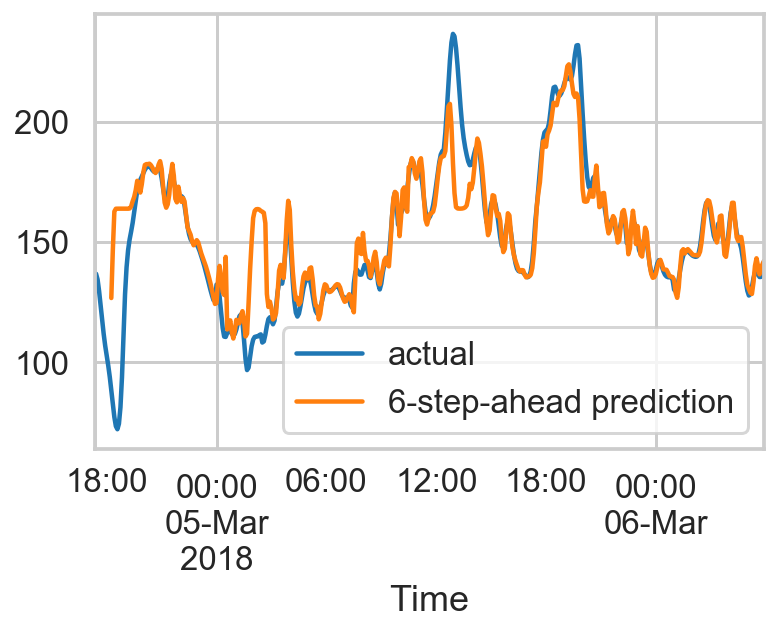

In [239]:
tsmdl.fit(Xtrain, ytrain)
ypred = tsmdl.predict(Xtest, ytest, step=6)
ypred = pd.Series(ypred, index=ytest.index)

ytest.plot(label='actual')
ypred.plot(label='6-step-ahead prediction')
plt.legend()

In [240]:
# using hubei province data

tsmdl = NARX(SVR(kernel='rbf'), auto_order=4, exog_order=[3, 3], exog_delay=[0, 0])
tsmdl.grid_search(trainX, trainy, para_grid, verbose=2)

Fitting 3 folds for each of 392 candidates, totalling 1176 fits
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.001 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.003 ...............................
[CV] ................ C=0.1, epsilon=0.001, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.001, gamma=0.005 ...............................
[CV] ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. C=0.1, epsilon=0.008, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.008, gamma=0.05 ................................
[CV] ................. C=0.1, epsilon=0.008, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.008, gamma=0.05 ................................
[CV] ................. C=0.1, epsilon=0.008, gamma=0.05, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.001 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.001, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.003 ................................
[CV] ................. C=0.1, epsilon=0.01, gamma=0.003, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.003 ................................
[CV] .

[CV] ................. C=0.3, epsilon=0.001, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.001, gamma=0.05 ................................
[CV] ................. C=0.3, epsilon=0.001, gamma=0.05, total=   0.0s
[CV] C=0.3, epsilon=0.003, gamma=0.001 ...............................
[CV] ................ C=0.3, epsilon=0.003, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.003, gamma=0.001 ...............................
[CV] ................ C=0.3, epsilon=0.003, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.003, gamma=0.001 ...............................
[CV] ................ C=0.3, epsilon=0.003, gamma=0.001, total=   0.0s
[CV] C=0.3, epsilon=0.003, gamma=0.003 ...............................
[CV] ................ C=0.3, epsilon=0.003, gamma=0.003, total=   0.0s
[CV] C=0.3, epsilon=0.003, gamma=0.003 ...............................
[CV] .

[CV] ................ C=0.3, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=0.3, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=0.3, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=0.3, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=0.3, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=0.3, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=0.3, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=0.3, epsilon=0.015, gamma=0.03 ................................
[CV] .

[CV] C=1, epsilon=0.005, gamma=0.01 ..................................
[CV] ................... C=1, epsilon=0.005, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.015 .................................
[CV] .................. C=1, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.03 ..................................
[CV] ................... C=1, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.03 ..................................
[CV] ................... C=1, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.005, gamma=0.03 ..................................
[CV] ................... C=1, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C

[CV] .................... C=1, epsilon=0.03, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.01 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.01 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.01, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.015 ..................................
[CV] ................... C=1, epsilon=0.03, gamma=0.015, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.03 ...................................
[CV] .................... C=1, epsilon=0.03, gamma=0.03, total=   0.0s
[CV] C=1, epsilon=0.03, gamma=0.03 ...................................
[CV] .

[CV] .................. C=3, epsilon=0.008, gamma=0.003, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.003 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.003, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.005, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.005, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.005 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.005, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.008 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.008, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.008 .................................
[CV] .................. C=3, epsilon=0.008, gamma=0.008, total=   0.0s
[CV] C=3, epsilon=0.008, gamma=0.008 .................................
[CV] .

[CV] .................. C=10, epsilon=0.005, gamma=0.01, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.01 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.01, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.015 ................................
[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.015 ................................
[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.015 ................................
[CV] ................. C=10, epsilon=0.005, gamma=0.015, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .................. C=10, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=10, epsilon=0.005, gamma=0.03 .................................
[CV] .

[CV] ................. C=30, epsilon=0.001, gamma=0.005, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.001, gamma=0.008, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.01 .................................
[CV] .................. C=30, epsilon=0.001, gamma=0.01, total=   0.0s
[CV] C=30, epsilon=0.001, gamma=0.015 ................................
[CV] .

[CV] ................. C=30, epsilon=0.015, gamma=0.003, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.003 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.003, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.005 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.005 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.005 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.005, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.008 ................................
[CV] ................. C=30, epsilon=0.015, gamma=0.008, total=   0.0s
[CV] C=30, epsilon=0.015, gamma=0.008 ................................
[CV] .

[CV] ................. C=100, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=100, epsilon=0.005, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.005, gamma=0.03, total=   0.0s
[CV] C=100, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=100, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=100, epsilon=0.005, gamma=0.05 ................................
[CV] ................. C=100, epsilon=0.005, gamma=0.05, total=   0.0s
[CV] C=100, epsilon=0.008, gamma=0.001 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.001, total=   0.0s
[CV] C=100, epsilon=0.008, gamma=0.001 ...............................
[CV] ................ C=100, epsilon=0.008, gamma=0.001, total=   0.0s
[CV] C=100, epsilon=0.008, gamma=0.001 ...............................
[CV] .

[CV] C=100, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.01 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.01, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.015 ...............................
[CV] ................ C=100, epsilon=0.015, gamma=0.015, total=   0.0s
[CV] C=100, epsilon=0.015, gamma=0.03 ................................
[CV] ................. C=100, epsilon=0.015, gamma=0.03, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done 1176 out of 1176 | elapsed:    2.6s finished


In [241]:
tsmdl

NARX(auto_order=4,
     base_estimator=SVR(C=0.1, cache_size=200, coef0=0.0, degree=3,
                        epsilon=0.03, gamma=0.001, kernel='rbf', max_iter=-1,
                        shrinking=True, tol=0.001, verbose=False),
     exog_delay=[0, 0], exog_order=[3, 3])

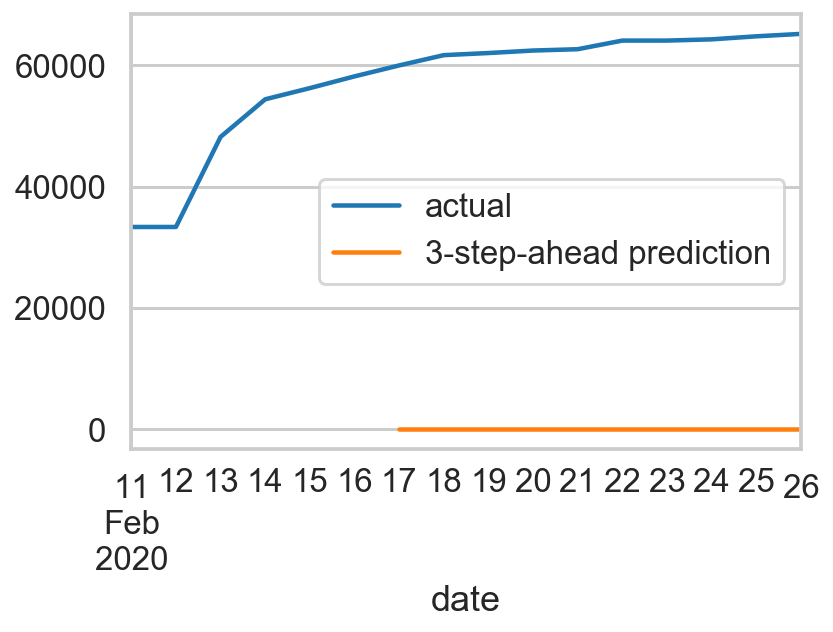

In [242]:
tsmdl.fit(trainX, trainy)
pred = tsmdl.predict(testX, testy, step=3)
pred = pd.Series(pred, index=testy.index)

testy.plot(label='actual')
pred.plot(label='3-step-ahead prediction')
plt.legend()

## Two or more exogenous variables

In [401]:
# Using blood glucose level measured by the Continuous Glucose Monitor (CGM) 
# using insulin and meal as the exogenous inputs.

# Adding 'CHO' exogenous variable

ytrain = data['CGM'].iloc[:1000]
Xtrain = data.loc[:, ['CHO', 'insulin', 'CGM']].iloc[:1000, :] # both y and x are included here with y as last var

ytest = data['CGM'].iloc[1000:-1]
Xtest = data.loc[:, ['CHO', 'insulin', 'CGM']].iloc[1000:-1, :]

print(ytrain.shape, Xtrain.shape, ytest.shape, Xtest.shape)

(1000,) (1000, 3) (440,) (440, 3)


In [402]:
Xtrain.shape

(1000, 3)

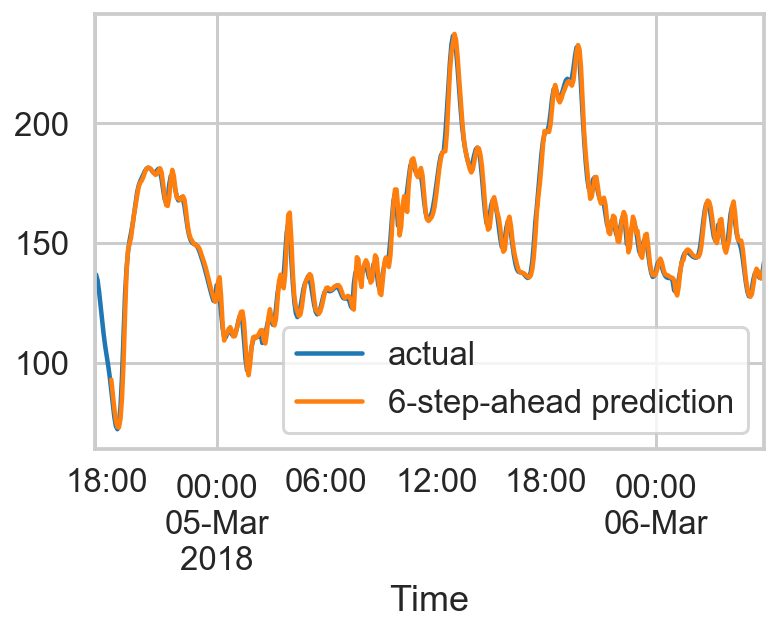

In [403]:
# predicting glucose 6 steps ahead

narx_mdl = NARX(LinearRegression(), auto_order=6, exog_order=[3, 3, 3], exog_delay=[0, 0, 0])

narx_mdl.fit(Xtrain, ytrain)

ypred_narx = narx_mdl.predict(Xtest, ytest, step=6)
ypred_narx = pd.Series(ypred_narx, index=ytest.index)

ytest.plot(label='actual')
ypred_narx.plot(label='6-step-ahead prediction')
plt.legend()

In [404]:
# Predict cases of coronavirus using all variables as exogenous inputs

# Adding 'city_pop' exogenous variable

train_size = 0.8

trainy = hubei_df['confirmed_cases'].iloc[:int(len(hubei_df)*train_size)]
trainX = hubei_df.iloc[:int(len(hubei_df)*train_size), :]

testy = hubei_df['confirmed_cases'].iloc[int(len(hubei_df)*train_size):-1]
testX = hubei_df.iloc[int(len(hubei_df)*train_size):-1, :]

print(trainy.shape, trainX.shape, testy.shape, testX.shape)

(64,) (64, 11) (16,) (16, 11)


In [405]:
# predicting coronavirus 3 steps ahead

# exog_order (list) – the exogenous input order, a list of integers representing the order 
# for each exogenous input, i.e. [q1,q2,...,qm] in equation (1).
exo_order = []
calc = 3
for i in range(trainX.shape[1]):
    exo_order.append(calc)

In [406]:
exo_delay = []
while len(exo_delay) < trainX.shape[1]:
    exo_delay.append(0)

In [407]:
narx_mdl = NARX(LinearRegression(), auto_order=5, exog_order=exo_order, exog_delay=exo_delay)

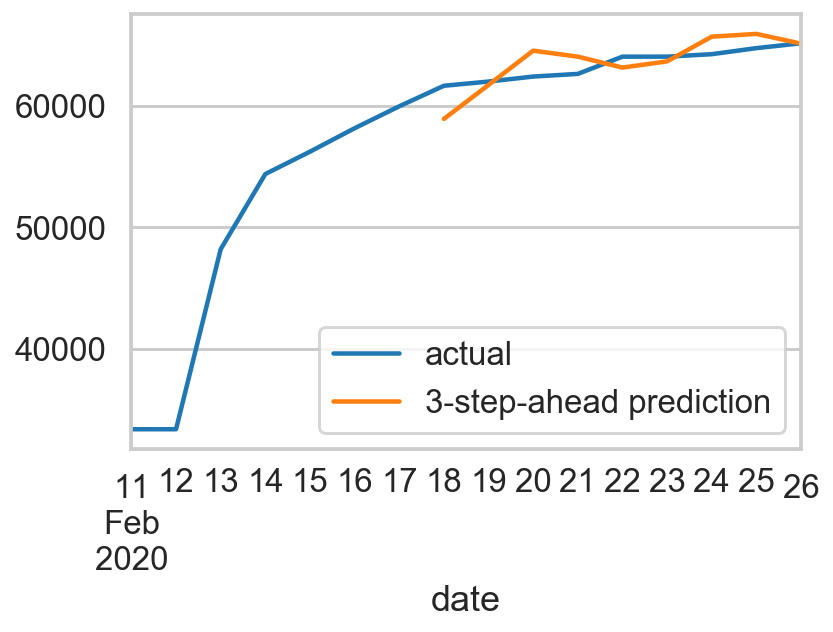

In [408]:
narx_mdl.fit(trainX, trainy)

pred_narx = narx_mdl.predict(testX, testy, step=3)
pred_narx = pd.Series(pred_narx, index=testy.index)

testy.plot(label='actual')
pred_narx.plot(label='3-step-ahead prediction')
plt.legend()

## Two or more locations with all exogenous variables

### Data prep

Here, trying to predict Beijing based on Hubei. Trying with two locations first. 

- See if model will run with the understood data format
- Compare result to Hubei plus all exo variables

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 15 columns):
Province/State        8424 non-null object
city_county_state     8424 non-null object
country               8424 non-null object
hospital beds         8424 non-null float64
physicians            8424 non-null float64
GDP_per_capita        8424 non-null float64
SPAR_index            8424 non-null float64
IVDI_score            8424 non-null float64
city_pop              8424 non-null float64
effective_dist        8424 non-null float64
geo_dist              8424 non-null float64
ann_pass_flux         8424 non-null float64
connected_airports    8424 non-null float64
date                  8424 non-null datetime64[ns]
confirmed_cases       8424 non-null float64
dtypes: datetime64[ns](1), float64(11), object(3)
memory usage: 987.3+ KB


In [302]:
beijing_df = df.loc[df['Province/State'] == 'Beijing']
beijing_df = beijing_df.drop(columns = 
                             ['Province/State', 
                              'city_county_state', 
                              'country']).set_index('date')

beijing_df.index = pd.to_datetime(hubei_df.index)

beijing_df.head()

hospital beds  physicians  GDP_per_capita  SPAR_index  IVDI_score     city_pop  effective_dist     geo_dist  ann_pass_flux  connected_airports  confirmed_cases
date                                                                                                                                                                       
2019-12-08            4.2      1.7855    18236.612982   94.307692    0.676294  1928.254173        5.771801  1042.466853      7961770.0           53.272727              0.0
2019-12-09            4.2      1.7855    18236.612982   94.307692    0.676294  1928.254173        5.771801  1042.466853      7961770.0           53.272727              0.0
2019-12-10            4.2      1.7855    18236.612982   94.307692    0.676294  1928.254173        5.771801  1042.466853      7961770.0           53.272727              0.0
2019-12-11            4.2      1.7855    18236.612982   94.307692    0.676294  1928.254173        5.771801  1042.466853      7961770.0           53.272727              0.0
2019-12-12            4.2      1.7855    18236.612982   94.307692    0.676294  1928.254173        5.771801  1042.466853      7961770.0           53.272727              0.0

In [318]:
# ensure coluumns for both datasets are in same order
print(beijing_df.columns.to_list())
print(hubei_df.columns.to_list())

['hospital beds', 'physicians', 'GDP_per_capita', 'SPAR_index', 'IVDI_score', 'city_pop', 'effective_dist', 'geo_dist', 'ann_pass_flux', 'connected_airports', 'confirmed_cases']
['hospital beds', 'physicians', 'GDP_per_capita', 'SPAR_index', 'IVDI_score', 'city_pop', 'effective_dist', 'geo_dist', 'ann_pass_flux', 'connected_airports', 'confirmed_cases']


In [327]:
# remove confirmed cases from both datasets
# concatenate exogenous features with hubei confirmed cases

bh_df = beijing_df.drop(columns = 'confirmed_cases').join(hubei_df.drop(columns = 'confirmed_cases'), how = 'outer', lsuffix = '_b', rsuffix = '_h')
bh_df = bh_df.join(hubei_df.confirmed_cases, how = 'outer', rsuffix = '_h')
bh_df.head()

hospital beds_b  physicians_b  GDP_per_capita_b  SPAR_index_b  IVDI_score_b   city_pop_b  effective_dist_b   geo_dist_b  ann_pass_flux_b  connected_airports_b  hospital beds_h  physicians_h  GDP_per_capita_h  SPAR_index_h  IVDI_score_h   city_pop_h  effective_dist_h  geo_dist_h  ann_pass_flux_h  connected_airports_h  confirmed_cases
date                                                                                                                                                                                                                                                                                                                                                      
2019-12-08              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              1.0
2019-12-09              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              0.0
2019-12-10              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              0.0
2019-12-11              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              2.0
2019-12-12              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              5.0

In [338]:
scaler = MinMaxScaler()

In [440]:
train_size = 0.8

trainy = bh_df['confirmed_cases'].iloc[:int(len(bh_df)*train_size)]
trainX = bh_df.drop(columns = 'confirmed_cases').iloc[:int(len(bh_df)*train_size), :]

testy = bh_df['confirmed_cases'].iloc[int(len(bh_df)*train_size):-1]
testX = bh_df.drop(columns = 'confirmed_cases').iloc[int(len(bh_df)*train_size):-1, :]

In [441]:
# trainX_s = scaler.fit_transform(trainX.drop(columns = 'confirmed_cases'))
# testX_s = scaler.transform(testX.drop(columns = 'confirmed_cases'))

# trainX_s = pd.DataFrame(trainX_s).join(bh_df['confirmed_cases'].iloc[:int(len(bh_df)*train_size)])
# testX_s = pd.DataFrame(testX_s).join(bh_df['confirmed_cases'].iloc[int(len(bh_df)*train_size):-1])

In [442]:
print(trainy.shape, trainX.shape, testy.shape, testX.shape)

(64,) (64, 20) (16,) (16, 20)


In [374]:
trainX.head()

hospital beds_b  physicians_b  GDP_per_capita_b  SPAR_index_b  IVDI_score_b   city_pop_b  effective_dist_b   geo_dist_b  ann_pass_flux_b  connected_airports_b  hospital beds_h  physicians_h  GDP_per_capita_h  SPAR_index_h  IVDI_score_h   city_pop_h  effective_dist_h  geo_dist_h  ann_pass_flux_h  connected_airports_h  confirmed_cases
date                                                                                                                                                                                                                                                                                                                                                      
2019-12-08              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              1.0
2019-12-09              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              0.0
2019-12-10              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              0.0
2019-12-11              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              2.0
2019-12-12              4.2        1.7855      18236.612982     94.307692      0.676294  1928.254173          5.771801  1042.466853        7961770.0             53.272727              4.2        1.7855      18236.612982     94.307692      0.676294  1154.866872          6.111029  341.482235     2.842581e+06             29.033333              5.0

In [384]:
trainy_ar = np.array(trainy)

In [385]:
trainy_r = trainy_ar.reshape(trainy_ar.shape[0], 1)

In [426]:
trainy_r.shape

(64, 1)

### Designing the model

In [443]:
# predicting coronavirus 3 steps ahead

# exog_order (list) – the exogenous input order, a list of integers representing the order 
# for each exogenous input, i.e. [q1,q2,...,qm] in equation (1).
exo_order = []
calc = 2
for i in range(trainX_s.shape[1]):
    exo_order.append(calc)

exo_delay = []
while len(exo_delay) < (trainX_s.shape[1]):
    exo_delay.append(1)

In [444]:
exo_order

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [445]:
trainX_s.shape

(64, 20)

In [446]:
len(exo_delay)

20

In [447]:
narx_mdl = NARX(LinearRegression(), auto_order=2, exog_order=exo_order, exog_delay=exo_delay)

In [450]:
narx_mdl.fit(trainX, trainy)

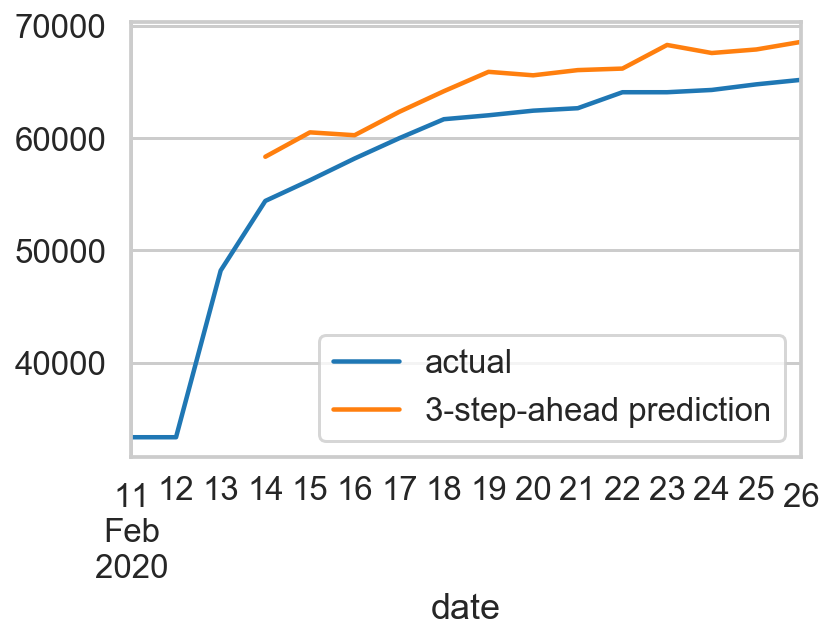

In [451]:
pred_narx = narx_mdl.predict(testX, testy, step=1)
pred_narx = pd.Series(pred_narx, index=testy.index)

testy.plot(label='actual')
pred_narx.plot(label='3-step-ahead prediction')
plt.legend()

In [452]:
narx_mdl.score(testX, testy, step=3, method='mse')

199545238.25694692

In [453]:
narx_mdl.score(testX, testy, step=3, method='r2')

-46.51853480533753

In [456]:
np.sqrt(narx_mdl.score(testX, testy, step=1, method='mse'))

3282.880744488681

In [459]:
narx_mdl.score(testX, testy, step=1, method='r2')

-0.006277604992665831